# Load data

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize

In [139]:
# === Parameters ===
tickers = ["RY.TO", "MEG.TO", "ATH.TO", "CNQ.TO", "SIA.TO", "MFC.TO", "TECK-B.TO", "BHC.TO","GIB-A.TO", "CLS.TO", "NPI.TO", "BEP-UN.TO"]
start_date = '2017-01-01'
end_date = '2025-06-11'

# === Download and process stock data ===
df = yf.download(tickers, start=start_date, end=end_date)['Close'].ffill()
prices_weekly = df.resample('W-FRI').last()
returns = prices_weekly.pct_change().dropna()

# === Benchmark index ===
sptsx = yf.download('^GSPTSE', start=start_date, end=end_date)['Close'].resample('W-FRI').last()
sptsx_returns = sptsx.pct_change().dropna()
sptsx_returns_series = sptsx_returns.squeeze()

# Load and prepare daily RF series
factors = pd.read_csv("North_America_5_Factors_Daily.csv")
factors['Dates'] = pd.to_datetime(factors['Dates'].astype(str), format='%Y%m%d')
factors.set_index('Dates', inplace=True)

# Convert to decimal daily rate
rf_daily = factors['RF'] / 100

# Compute weekly compounded risk-free return
rf_weekly = ((1 + rf_daily).resample('W-FRI').prod()) - 1
rf_weekly = rf_weekly.reindex(sptsx_returns_series.index).ffill()

# # === Export processed data to CSV ===
# prices_weekly.to_csv("prices_weekly.csv")
# returns.to_csv("returns_weekly.csv")
# sptsx_returns_series.to_frame(name="SPTSX_Return").to_csv("sptsx_returns_weekly.csv")
# rf_weekly.to_frame(name="RF_Weekly").to_csv("rf_weekly.csv")

[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
# === Import back CSV files ===
prices_weekly = pd.read_csv("prices_weekly.csv", index_col=0, parse_dates=True)
sptsx_returns_series = pd.read_csv("sptsx_returns_weekly.csv", index_col=0, parse_dates=True).squeeze("columns")
rf_weekly = pd.read_csv("rf_weekly.csv", index_col=0, parse_dates=True).squeeze("columns")

# === Recompute weekly returns from imported prices ===
returns = prices_weekly.pct_change().dropna()

In [ ]:
import ta
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, BatchNormalization

# === Feature Engineering Function ===
def compute_indicators(price_series):
    df = pd.DataFrame({'close': price_series})
    
    df['MA_Port_12'] = df['close'].rolling(window=12).mean()
    df['MACD'] = ta.trend.macd(df['close'])
    df['MACD_Signal'] = ta.trend.macd_signal(df['close'])
    df['MACD_Hist'] = ta.trend.macd_diff(df['close'])
    df['RSI'] = ta.momentum.rsi(df['close'], window=14)
    df['Volatility'] = df['close'].pct_change().rolling(window=12).std()
    df['Momentum'] = df['close'] - df['close'].shift(12)

    return df[['MA_Port_12', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'Volatility']]

# === Sequence Builder ===
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=2, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# === Hyperparameters ===
WINDOW_SIZE = 14
LSTM_UNITS = 32
EPOCHS = 1000
VERBOSE = 0
ROLLING_STEP = 4  # retrain model every 4 weeks (optional)

# === Output folder ===
os.makedirs("LSTM_Portfolio_with_indicators", exist_ok=True)
cl_predicted_returns = pd.DataFrame(index=returns.index, columns=returns.columns)

# === Main Training Loop ===
for ticker in returns.columns:
    print(f"\n📈 Training LSTM model for {ticker}...")

    price_series = prices_weekly[ticker]
    indicators = compute_indicators(price_series)
    return_series = returns[ticker]

    # Combine return and indicators
    df_model = pd.concat([return_series, indicators], axis=1).dropna()
    df_model = df_model.rename(columns={ticker: "Return"})
    df_model['Return_Lag1'] = df_model['Return'].shift(1)
    df_model['Return_Lag2'] = df_model['Return'].shift(2)
    df_model['Return_Lag3'] = df_model['Return'].shift(3)
    df_model = df_model.dropna()

    # Define features and target
    feature_cols = ['MACD', 'MACD_Hist', 
                    'RSI', 'Volatility', 'Return_Lag1', 'Return_Lag2', 'Return_Lag3']
    X_raw = df_model[feature_cols].values
    y_raw = df_model["Return"].values.reshape(-1, 1)

    # ❗️Split raw data first (before any scaling)
    split_idx = int(len(X_raw) * 0.8)
    X_raw_train = X_raw[:split_idx]
    y_raw_train = y_raw[:split_idx]

    # ✅ Fit scalers ONLY on training data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    scaler_X.fit(X_raw_train)
    scaler_y.fit(y_raw_train)

    #  Transform full data (safely)
    X_scaled = scaler_X.transform(X_raw)
    y_scaled = scaler_y.transform(y_raw)

    #  Create sequences from fully scaled data
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, WINDOW_SIZE)

    #  Split sequences into train/test
    split = int(len(X_seq) * 0.7)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    # === LSTM Model Architecture ===
    model = build_model(input_shape=(WINDOW_SIZE, X_train.shape[2]))
    model.compile(optimizer='adam', loss='mse')

    # # Early stopping to prevent overfitting
    # early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        # validation_split=0.1,
        epochs=EPOCHS,
        verbose=VERBOSE
        # callbacks=[early_stop]
    )

    # === Prediction and Evaluation ===
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_actual = scaler_y.inverse_transform(y_test).flatten()

    pred_index = df_model.index[WINDOW_SIZE + split:]

    cl_predicted_returns.loc[pred_index, ticker] = y_pred

    r2 = r2_score(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))

    print(f"R²: {r2:.4f}, RMSE: {rmse:.5f}")

    # === Plot prediction vs actual ===
    plt.figure(figsize=(10, 4))
    plt.plot(pred_index, y_actual, label='Actual')
    plt.plot(pred_index, y_pred, label='Predicted')
    plt.title(f'CNN-LSTM Prediction: {ticker}\nR²={r2:.4f}, RMSE={rmse:.4f}')
    plt.xlabel('Date')
    plt.ylabel('Weekly return')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"CNN_LSTM2_Portfolio_with_indicators/{ticker}_pred.png")
    plt.show()

# Drop rows with missing predictions
cl_predicted_returns = cl_predicted_returns.dropna()


📈 Training LSTM model for ATH.TO...


/home/dylannguyen/anaconda3/envs/py3-TF2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Permute, Multiply, Softmax

class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.query = Dense(units)
        self.key = Dense(units)
        self.value = Dense(units)
        self.softmax = Softmax(axis=-1)

    def call(self, inputs):
        # inputs shape: (batch, time_steps, features)
        Q = self.query(inputs)
        K = self.key(inputs)
        V = self.value(inputs)

        scores = tf.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(self.units, tf.float32))
        weights = self.softmax(scores)
        context = tf.matmul(weights, V)
        return tf.reduce_mean(context, axis=1)  # reduce time axis (optional)


2025-08-01 00:18:27.692821: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 00:18:28.220649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754021908.453669 3601927 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754021908.514522 3601927 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 00:18:29.014063: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

: 

# Model Training

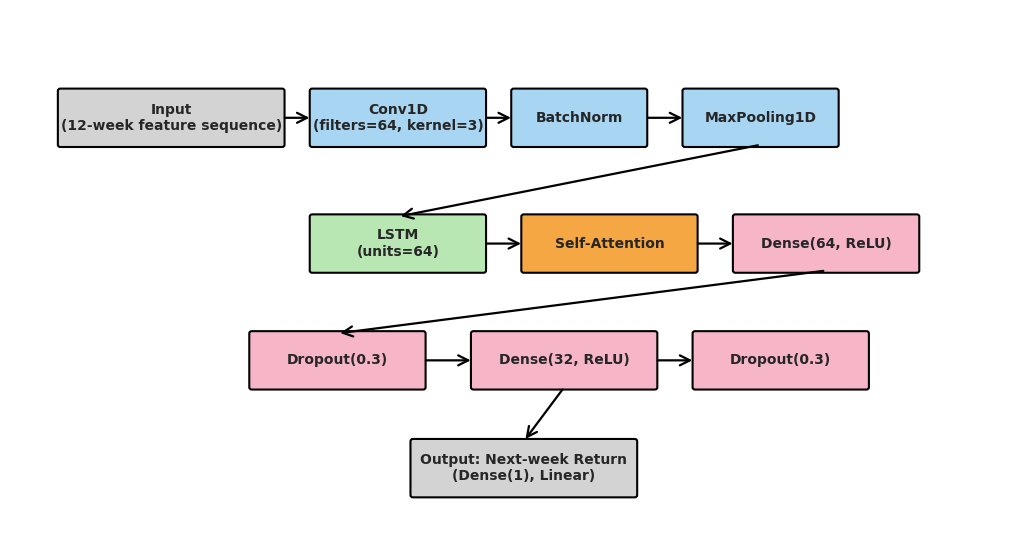

In [189]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Utility to create a rounded box and return anchor points for arrows
def add_box(ax, text, x, y, w, h, fc, ec='black', lw=1.5, fontsize=10):
    """Draw a rounded rectangle box with text and return its anchor points."""
    rect = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.05", fc=fc, ec=ec, lw=lw)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=fontsize, weight='bold', wrap=True)
    # Anchor points: centers on each side and center
    anchors = {
        "left": (x, y + h/2),
        "right": (x + w, y + h/2),
        "top": (x + w/2, y + h),
        "bottom": (x + w/2, y),
        "center": (x + w/2, y + h/2)
    }
    return anchors

def arrow(ax, p_from, p_to):
    ax.annotate("", xy=p_to, xytext=p_from,
                arrowprops=dict(arrowstyle="->", lw=1.6, color="black"))

# Figure setup
fig, ax = plt.subplots(figsize=(13, 7))
ax.set_xlim(0, 20)
ax.set_ylim(0, 12)
ax.axis('off')

# Layout parameters
row_y = {1: 9.0, 2: 6.2, 3: 3.6, 4: 1.2}  # y (bottom) for each row
h = 1.2                                   # uniform height
gap_x = 0.8                           

# Row 1 boxes
x = 1.0
anc_input = add_box(ax, "Input\n(12-week feature sequence)", x, row_y[1], 4.4, h, fc="#D3D3D3")
x += 4.2 + gap_x
anc_conv = add_box(ax, "Conv1D\n(filters=64, kernel=3)", x, row_y[1], 3.4, h, fc="#A8D5F2")
x += 3.2 + gap_x
anc_bn = add_box(ax, "BatchNorm", x, row_y[1], 2.6, h, fc="#A8D5F2")
x += 2.6 + gap_x
anc_pool = add_box(ax, "MaxPooling1D", x, row_y[1], 3.0, h, fc="#A8D5F2")

# Row 2 boxes
x2 = 6.0
anc_lstm = add_box(ax, "LSTM\n(units=64)", x2, row_y[2], 3.4, h, fc="#B9E7B3")
x2 += 3.4 + gap_x
anc_attn = add_box(ax, "Self-Attention", x2, row_y[2], 3.4, h, fc="#F4A742")
x2 += 3.4 + gap_x
anc_dense64 = add_box(ax, "Dense(64, ReLU)", x2, row_y[2], 3.6, h, fc="#F7B5C8")

# Row 3 boxes
anc_drop1 = add_box(ax, "Dropout(0.3)", 4.8, row_y[3], 3.4, h, fc="#F7B5C8")
anc_dense32 = add_box(ax, "Dense(32, ReLU)", 9.2, row_y[3], 3.6, h, fc="#F7B5C8")
anc_drop2 = add_box(ax, "Dropout(0.3)", 13.6, row_y[3], 3.4, h, fc="#F7B5C8")

# Row 4 (Output)
anc_out = add_box(ax, "Output: Next-week Return\n(Dense(1), Linear)", 8.0, row_y[4], 4.4, h, fc="#D3D3D3")

# Arrows row 1 (horizontal)
arrow(ax, anc_input["right"], anc_conv["left"])
arrow(ax, anc_conv["right"], anc_bn["left"])
arrow(ax, anc_bn["right"], anc_pool["left"])

# Diagonal from pooling (row1) to LSTM (row2)
arrow(ax, anc_pool["bottom"], anc_lstm["top"])

# Row 2 horizontal arrows
arrow(ax, anc_lstm["right"], anc_attn["left"])
arrow(ax, anc_attn["right"], anc_dense64["left"])

# Vertical arrow from Dense(64) (row2) to Dropout(0.3) (row3)
arrow(ax, anc_dense64["bottom"], anc_drop1["top"])

# Row 3 horizontal arrows
arrow(ax, anc_drop1["right"], anc_dense32["left"])
arrow(ax, anc_dense32["right"], anc_drop2["left"])

# Arrow from Dense(32) (row3) to Output (row4)
arrow(ax, anc_dense32["bottom"], anc_out["top"])

# Save diagram
plt.savefig("cnn_lstm_architecture_diagram_black_arrows.png", dpi=300, bbox_inches="tight")
plt.savefig("cnn_lstm_architecture_diagram_black_arrows.pdf", dpi=300, bbox_inches="tight")
plt.show()


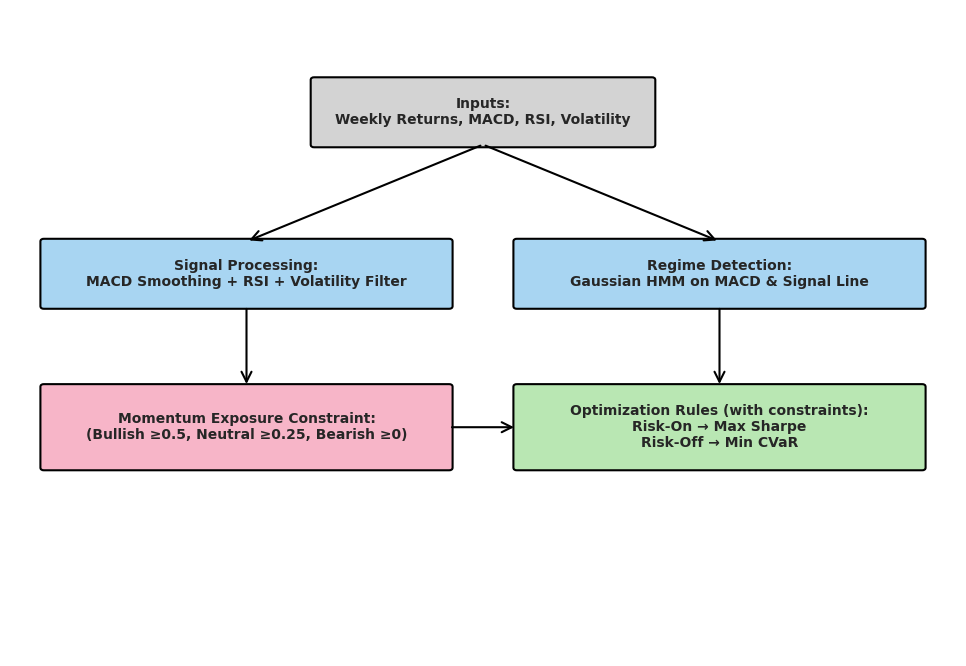

In [192]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

def add_box(ax, text, x, y, w, h, fc="#A8D5F2"):
    box = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.05",
                         fc=fc, ec="black", lw=1.5)
    ax.add_patch(box)
    ax.text(x + w/2, y + h/2, text, ha="center", va="center",
            fontsize=10, weight="bold", wrap=True)
    return {
        "left": (x, y + h/2),
        "right": (x + w, y + h/2),
        "top": (x + w/2, y + h),
        "bottom": (x + w/2, y)
    }

def arrow(ax, start, end):
    ax.annotate("", xy=end, xytext=start,
                arrowprops=dict(arrowstyle="->", lw=1.5, color="black"))

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlim(0, 14)
ax.set_ylim(0, 12)
ax.axis("off")

# Row 1 - Inputs
inputs = add_box(ax, "Inputs:\nWeekly Returns, MACD, RSI, Volatility",
                 4.5, 9.5, 5, 1.2, "#D3D3D3")

# Row 2 - Signal Processing & Regime Detection
signal_proc = add_box(ax, "Signal Processing:\nMACD Smoothing + RSI + Volatility Filter",
                      0.5, 6.5, 6, 1.2)
regime_det = add_box(ax, "Regime Detection:\nGaussian HMM on MACD & Signal Line",
                     7.5, 6.5, 6, 1.2)

# Row 3 - Momentum Constraint & Optimization Rules
momentum_const = add_box(ax, "Momentum Exposure Constraint:\n(Bullish ≥0.5, Neutral ≥0.25, Bearish ≥0)",
                          0.5, 3.5, 6, 1.5, "#F7B5C8")
opt_rules = add_box(ax, "Optimization Rules (with constraints):\nRisk-On → Max Sharpe\nRisk-Off → Min CVaR",
                    7.5, 3.5, 6, 1.5, "#B9E7B3")

# Arrows
arrow(ax, inputs["bottom"], signal_proc["top"])
arrow(ax, inputs["bottom"], regime_det["top"])
arrow(ax, signal_proc["bottom"], momentum_const["top"])
arrow(ax, regime_det["bottom"], opt_rules["top"])
arrow(ax, momentum_const["right"], opt_rules["left"])

# Save
plt.tight_layout()
plt.savefig("hybrid_strategy_schematic.png", dpi=300)
plt.show()


🔁 Walk-forward retraining for ATH.TO
ATH.TO | R²: 0.8382, RMSE: 0.7446


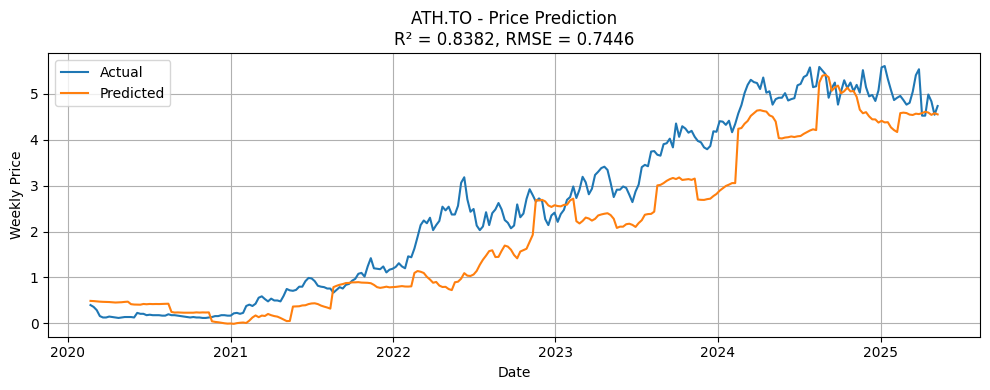

🔁 Walk-forward retraining for BEP-UN.TO
BEP-UN.TO | R²: -0.4790, RMSE: 7.0028


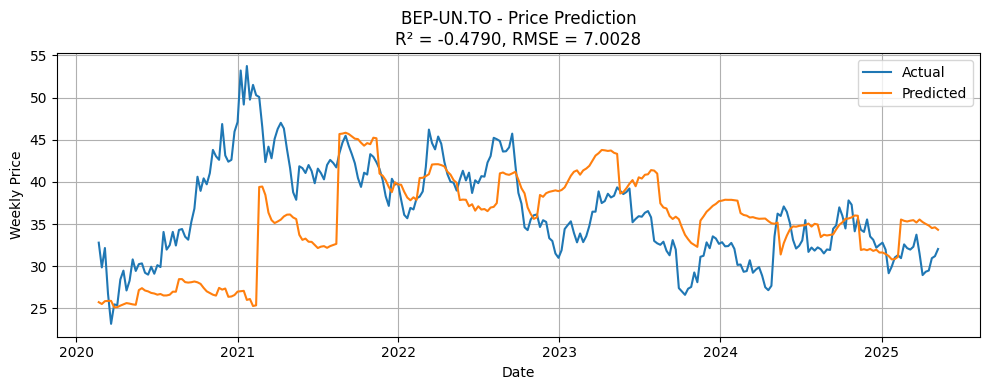

🔁 Walk-forward retraining for BHC.TO
BHC.TO | R²: 0.5692, RMSE: 7.0601


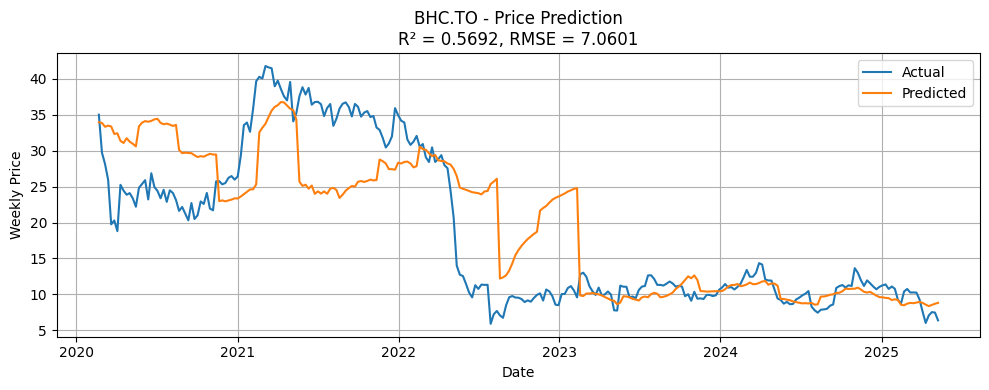

🔁 Walk-forward retraining for CLS.TO
CLS.TO | R²: 0.6907, RMSE: 22.6139


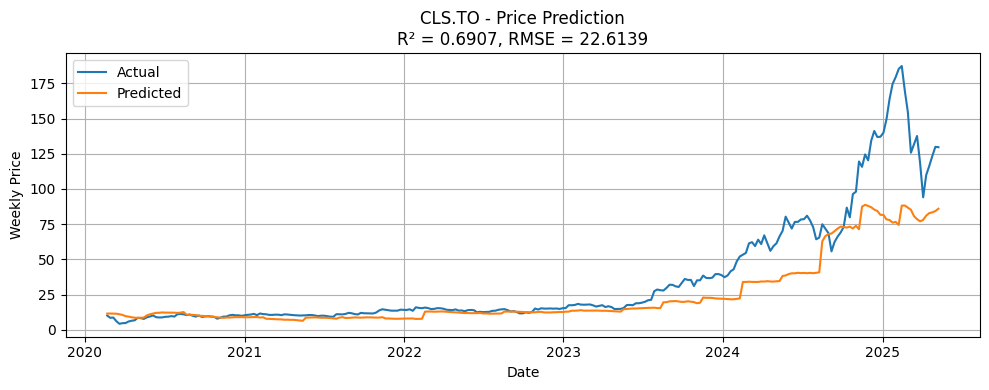

🔁 Walk-forward retraining for CNQ.TO
CNQ.TO | R²: 0.7693, RMSE: 6.3379


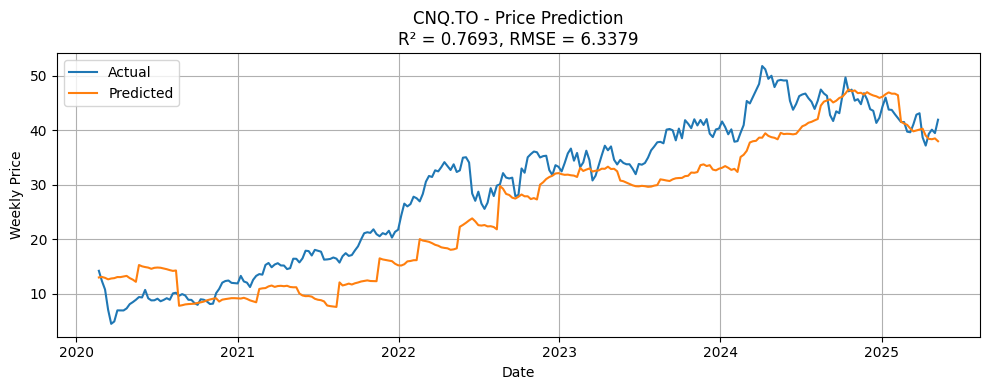

🔁 Walk-forward retraining for GIB-A.TO
GIB-A.TO | R²: 0.6160, RMSE: 14.3387


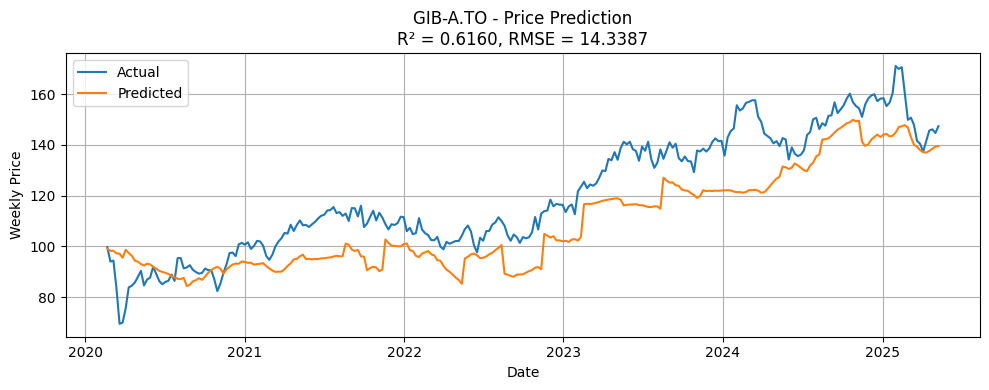

🔁 Walk-forward retraining for MEG.TO
MEG.TO | R²: 0.7458, RMSE: 4.4257


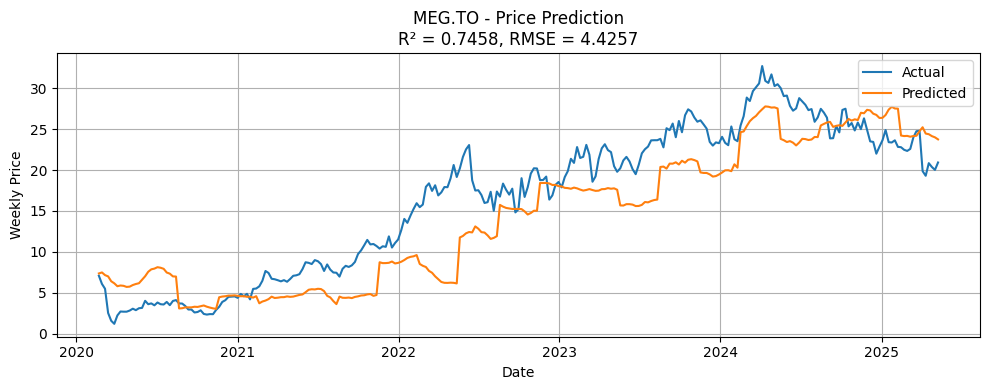

🔁 Walk-forward retraining for MFC.TO
MFC.TO | R²: 0.6398, RMSE: 5.0372


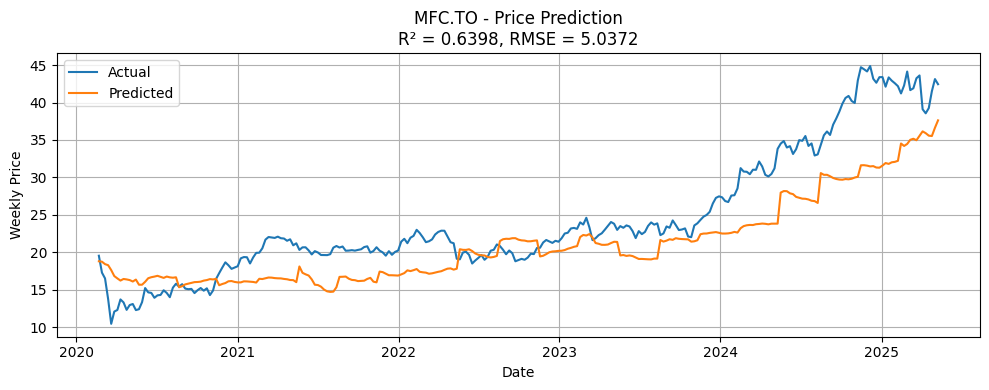

🔁 Walk-forward retraining for NPI.TO


: 

In [48]:
import pandas as pd
import ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

def compute_indicators(price_series):
    """
    Compute technical indicators using price series with the `ta` library.

    Parameters:
    - price_series: pd.Series of prices

    Returns:
    - DataFrame of indicators
    """
    df = pd.DataFrame({'close': price_series})

    # Trend indicators
    df['EMA_12'] = ta.trend.ema_indicator(df['close'], window=12)
    df['EMA_26'] = ta.trend.ema_indicator(df['close'], window=26)
    df['MACD'] = ta.trend.macd(df['close'])
    df['MACD_Signal'] = ta.trend.macd_signal(df['close'])
    df['MACD_Hist'] = ta.trend.macd_diff(df['close'])

    # Momentum indicators
    df['RSI'] = ta.momentum.rsi(df['close'], window=14)

    # Volatility indicator
    df['Volatility'] = ta.volatility.average_true_range(high=df['close'], low=df['close'], close=df['close'], window=14)

    # Bollinger Bands
    bb = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
    df['BB_High'] = bb.bollinger_hband()
    df['BB_Low'] = bb.bollinger_lband()

    return df[['EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Hist',
               'RSI', 'Volatility', 'BB_High', 'BB_Low']]

def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

def build_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        LSTM(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss=Huber())
    return model

def walk_forward_training(prices_weekly, window_size=26, train_window=104, step=13, epochs=100, verbose=0):
    predicted_prices = pd.DataFrame(index=prices_weekly.index, columns=prices_weekly.columns)

    for ticker in prices_weekly.columns:
        print(f"🔁 Walk-forward retraining for {ticker}")
        price_series = prices_weekly[ticker].dropna()
        indicators = compute_indicators(price_series)

        df_model = pd.concat([price_series, indicators], axis=1).dropna()
        df_model.columns = ['Price'] + list(indicators.columns)

        feature_cols = df_model.columns.drop('Price')

        for start in range(0, len(df_model) - train_window - window_size, step):
            end = start + train_window
            test_start = end
            test_end = test_start + step
            if test_end + window_size >= len(df_model):
                break

            scaler_X = MinMaxScaler()
            scaler_y = MinMaxScaler()

            train_df = df_model.iloc[start:end]
            X_train_raw = train_df[feature_cols].values
            y_train_raw = train_df["Price"].values.reshape(-1, 1)
            scaler_X.fit(X_train_raw)
            scaler_y.fit(y_train_raw)

            X_all = scaler_X.transform(df_model[feature_cols].values)
            y_all = scaler_y.transform(df_model["Price"].values.reshape(-1, 1))

            X_seq, y_seq = create_sequences(X_all, y_all, window_size)

            train_X = X_seq[start:test_start]
            train_y = y_seq[start:test_start]
            X_test = X_seq[test_start:test_end]

            model = build_model(input_shape=(window_size, train_X.shape[2]))
            model.fit(
                train_X, train_y,
                validation_split=0.1,
                epochs=epochs,
                verbose=verbose,
                batch_size=64
            )

            y_pred_scaled = model.predict(X_test, verbose=0)
            y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

            pred_index = df_model.index[test_start + window_size:test_end + window_size]
            predicted_prices.loc[pred_index, ticker] = y_pred

        actual = prices_weekly[ticker].loc[predicted_prices.index]
        predicted = predicted_prices[ticker].dropna()

        actual_aligned = actual.loc[predicted.index]
        predicted = predicted.loc[actual_aligned.index]

        if len(actual_aligned) >= 2:
            r2 = r2_score(actual_aligned, predicted)
            rmse = np.sqrt(mean_squared_error(actual_aligned, predicted))
            print(f"{ticker} | R²: {r2:.4f}, RMSE: {rmse:.4f}")

            plt.figure(figsize=(10, 4))
            plt.plot(actual_aligned.index, actual_aligned, label='Actual')
            plt.plot(predicted.index, predicted, label='Predicted')
            plt.title(f"{ticker} - Price Prediction\nR² = {r2:.4f}, RMSE = {rmse:.4f}")
            plt.xlabel("Date")
            plt.ylabel("Weekly Price")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return predicted_prices

# === Example usage ===
predicted_prices = walk_forward_training(prices_weekly, epochs=170, step=13, train_window=104, window_size=26)
predicted_prices.dropna().to_csv("CNN_LSTM_predicted_prices.csv", index=True)


🔁 Walk-forward retraining for ATH.TO


I0000 00:00:1754021917.864047 3601927 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1754021924.302917 3603174 cuda_dnn.cc:529] Loaded cuDNN version 90300


ATH.TO | Walk-forward R²: -1.3149, RMSE: 0.15600


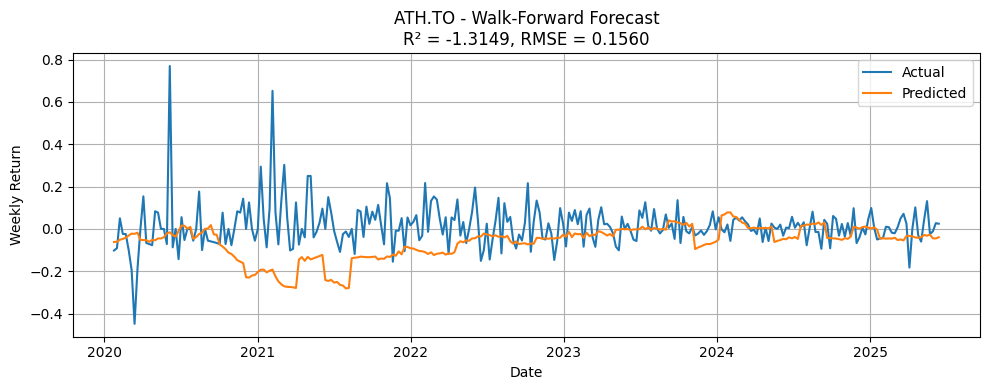

🔁 Walk-forward retraining for BEP-UN.TO
BEP-UN.TO | Walk-forward R²: -0.9737, RMSE: 0.06763


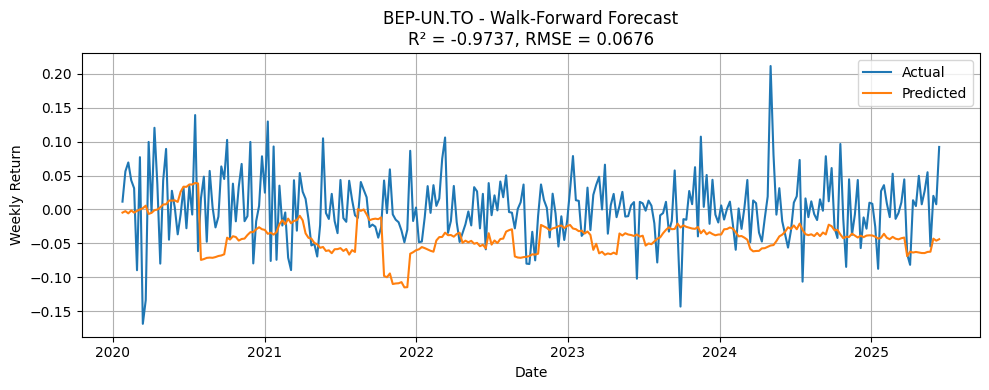

🔁 Walk-forward retraining for BHC.TO
BHC.TO | Walk-forward R²: -1.0591, RMSE: 0.12992


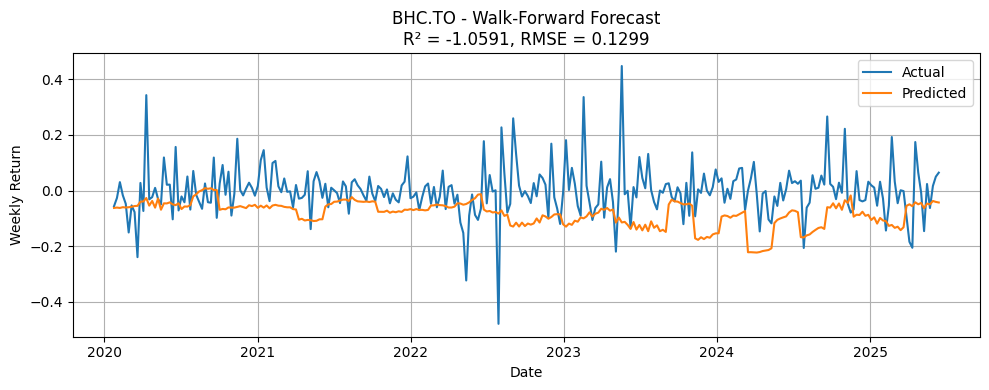

🔁 Walk-forward retraining for CLS.TO
CLS.TO | Walk-forward R²: -0.6078, RMSE: 0.09678


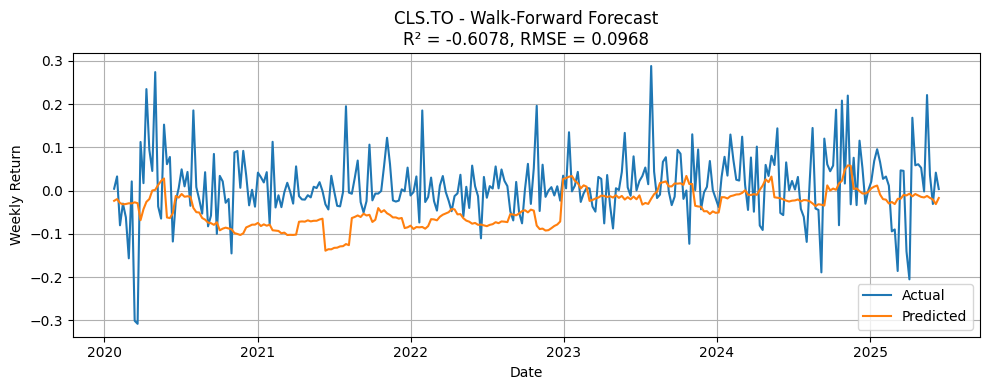

🔁 Walk-forward retraining for CNQ.TO
CNQ.TO | Walk-forward R²: -1.5165, RMSE: 0.10225


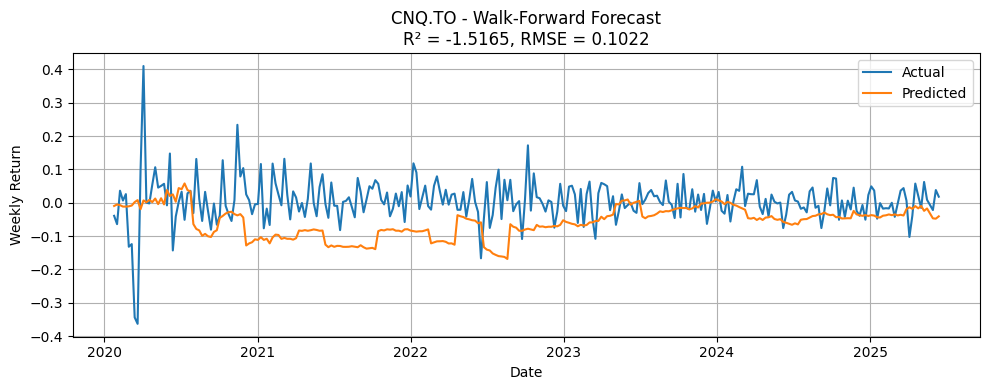

🔁 Walk-forward retraining for GIB-A.TO
GIB-A.TO | Walk-forward R²: -1.1542, RMSE: 0.04457


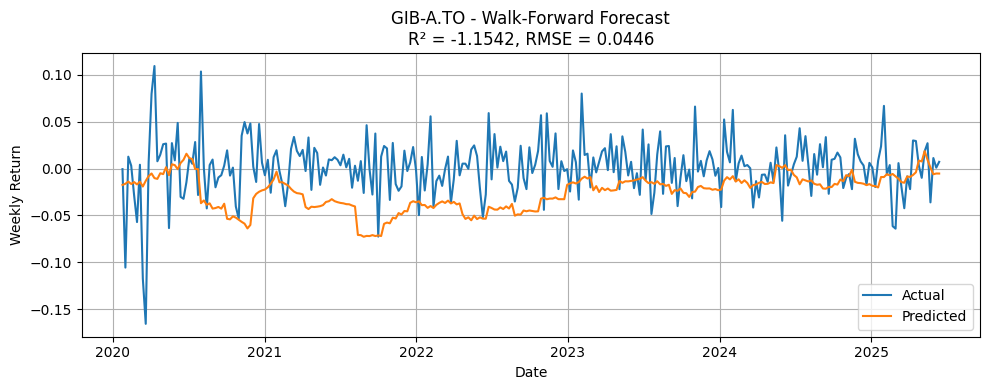

🔁 Walk-forward retraining for MEG.TO
MEG.TO | Walk-forward R²: -1.3122, RMSE: 0.14844


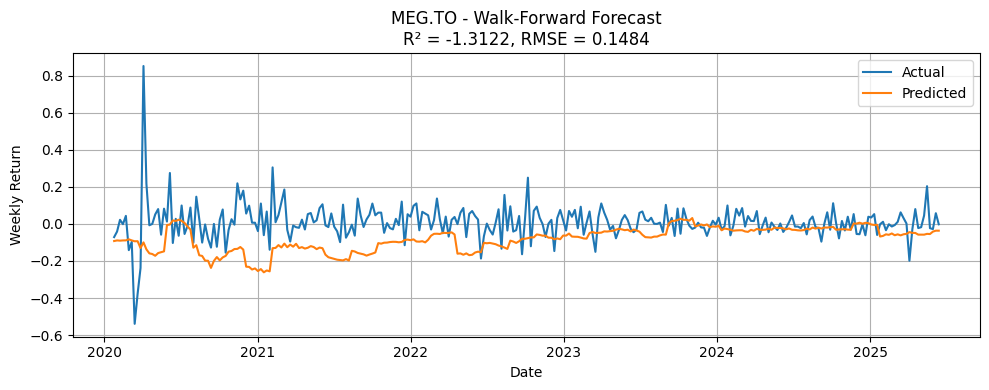

🔁 Walk-forward retraining for MFC.TO


In [ ]:
import ta
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

def compute_indicators(ret_series):
    """
    Compute technical indicators directly from return series.

    Parameters:
    - ret_series: pd.Series of weekly returns

    Returns:
    - DataFrame with return-based technical indicators
    """
    df = pd.DataFrame({'return': ret_series})

    # Moving Averages of Return
    # df['MA_Port_12'] = df['return'].rolling(window=12).mean()
    # df['MA_Port_4'] = df['return'].rolling(window=4).mean()

    # Exponential Moving Averages and MACD
    df['EMA_12'] = df['return'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['return'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

    # Volatility (rolling std)
    df['Volatility'] = df['return'].rolling(window=12).std()

    # RSI approximation (from return series)
    delta = df['return']
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain, index=df.index).rolling(window=14).mean()
    avg_loss = pd.Series(loss, index=df.index).rolling(window=14).mean()
    rs = avg_gain / (avg_loss + 1e-9)  # prevent divide-by-zero
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands (on return)
    ma_20 = df['return'].rolling(window=20).mean()
    std_20 = df['return'].rolling(window=20).std()
    df['BB_High'] = ma_20 + 2 * std_20
    df['BB_Low'] = ma_20 - 2 * std_20

    return df[['MACD', 'MACD_Signal', 'MACD_Hist', 
               'RSI', 'Volatility',
               'BB_High', 'BB_Low']]

# === Sequence Builder ===
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

def build_model(input_shape):
    model = tf.keras.Sequential([
        Input(shape=input_shape),
        Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        LSTM(32, return_sequences=True),       # Output sequence to feed attention
        SelfAttention(units=32),               # Apply attention over LSTM output
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def walk_forward_predict_range(df_model, model, X_seq, scaler_y, start, end, step, window_size):
    """
    Predict a range of returns instead of just one-step ahead after training the model.
    """
    predictions = {}
    for offset in range(step):
        test_idx = end + offset
        if test_idx >= len(df_model):
            break
        test_X = X_seq[end + offset].reshape(1, window_size, -1)
        pred_scaled = model.predict(test_X, verbose=0)
        pred = scaler_y.inverse_transform(pred_scaled)[0, 0]
        pred_date = df_model.index[test_idx]
        predictions[pred_date] = pred
    return predictions

def walk_forward_training(prices_weekly, returns, window_size=12, train_window=104, step=9, epochs=100, verbose=0):
    cl_predicted_returns = pd.DataFrame(index=returns.index, columns=returns.columns)

    for ticker in returns.columns:
        print(f"🔁 Walk-forward retraining for {ticker}")
        return_series = returns[ticker]
        indicators = compute_indicators(return_series)

        df_model = pd.concat([return_series, indicators], axis=1).dropna()
        df_model = df_model.rename(columns={ticker: "Return"})
        df_model['Return_Lag1'] = df_model['Return'].shift(1)
        df_model['Return_Lag2'] = df_model['Return'].shift(2)
        df_model['Return_Lag3'] = df_model['Return'].shift(3)
        df_model['SPTSX_Return'] = sptsx_returns_series.shift(1)
        df_model = df_model.dropna()

        feature_cols = ['MACD', 'MACD_Hist', 'RSI', 'Volatility',
                        'Return_Lag1', 'Return_Lag2', 'Return_Lag3', 
                        'SPTSX_Return', 'BB_High', 'BB_Low']

        for start in range(0, len(df_model) - train_window - window_size, step):
            end = start + train_window
            # === Define test range ===
            test_start = end
            test_end = test_start + step
            if test_start >= len(df_model):
                break

            # Fit scaler on training only
            train_df = df_model.iloc[start:end]
            scaler_X = MinMaxScaler()
            scaler_y = MinMaxScaler()
            X_train_raw = train_df[feature_cols].values
            y_train_raw = train_df["Return"].values.reshape(-1, 1)
            scaler_X.fit(X_train_raw)
            scaler_y.fit(y_train_raw)

            # Transform full data
            X_all = scaler_X.transform(df_model[feature_cols].values)
            y_all = scaler_y.transform(df_model["Return"].values.reshape(-1, 1))

            # Build sequences
            X_seq, y_seq = create_sequences(X_all, y_all, window_size)

            # Training sequences
            train_X = X_seq[start:test_start]
            train_y = y_seq[start:test_start]
            # Prepare test batch
            X_test = X_seq[test_start:test_end]
            y_test = y_seq[test_start:test_end]

            early_stop = EarlyStopping(
                monitor='val_loss',
                patience=80,
                restore_best_weights=True,
                verbose=1
            )

            # Build and fit model
            model = build_model(input_shape=(window_size, train_X.shape[2]))
            model.fit(
                train_X, train_y,
                validation_split=0.1,
                batch_size = 256,
                epochs=epochs,
                verbose=verbose,
                # callbacks=[early_stop]
            )

            # Predict batch
            y_pred_scaled = model.predict(X_test, verbose=0)
            y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

            # Align prediction dates
            pred_index = df_model.index[test_start + window_size:test_end + window_size]
            cl_predicted_returns.loc[pred_index, ticker] = y_pred

        
        # === Evaluation after walk-forward ===
        predicted = cl_predicted_returns[ticker].dropna()
        actual = returns[ticker].loc[cl_predicted_returns.index]

        # Align indexes explicitly
        actual_aligned = actual.loc[predicted.index]
        actual_aligned = actual_aligned.dropna()
        predicted = predicted.loc[actual_aligned.index]

        # Sanity check
        if len(actual_aligned) >= 2:
            r2 = r2_score(actual_aligned, predicted)
            rmse = np.sqrt(mean_squared_error(actual_aligned, predicted))
            print(f"{ticker} | Walk-forward R²: {r2:.4f}, RMSE: {rmse:.5f}")
        else:
            print(f"{ticker} | Not enough data points to compute R²")
            r2, rmse = np.nan, np.nan

        # === Plot Actual vs Predicted ===
        plt.figure(figsize=(10, 4))
        plt.plot(actual_aligned.index, actual_aligned, label='Actual')
        plt.plot(predicted.index, predicted, label='Predicted')
        plt.title(f"{ticker} - Walk-Forward Forecast\nR² = {r2:.4f}, RMSE = {rmse:.4f}")
        plt.xlabel("Date")
        plt.ylabel("Weekly Return")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"WalkForward_Plots_2/{ticker}_walkforward.png")
        plt.show()

    return cl_predicted_returns

cl_predicted_returns = walk_forward_training(prices_weekly, returns, epochs=150, step=9, train_window=124)
cl_predicted_returns = cl_predicted_returns.dropna()

In [ ]:
cl_predicted_returns = cl_predicted_returns.dropna()
cl_predicted_returns

Ticker        ATH.TO BEP-UN.TO    BHC.TO    CLS.TO    CNQ.TO  GIB-A.TO  \
Date                                                                     
2023-04-07  0.054677  0.001518  0.023062  0.017376  0.013146  -0.01238   
2023-06-02 -0.043558  0.008879  0.022987 -0.010372 -0.001813   0.06887   
2023-07-28  0.015977 -0.007749 -0.069371 -0.004902  0.021411  0.005399   
2023-09-22  0.033357  -0.01058 -0.080205 -0.011932  0.054428 -0.002523   
2023-11-17  0.028272  0.015018  0.062448  0.098862  -0.00676 -0.022458   
2024-01-12 -0.000126 -0.067015 -0.015457  0.036865 -0.006557  0.005722   
2024-03-08 -0.029544  0.068717 -0.012358 -0.005542  0.009769 -0.010739   
2024-05-03 -0.023119  0.023533 -0.019797 -0.007044 -0.015188 -0.009887   
2024-06-28  0.020318 -0.024139 -0.023598 -0.045757 -0.045267  0.016824   
2024-08-23 -0.012552  0.001166 -0.027044  0.025687  0.012975  0.000908   
2024-10-18  0.042523  0.002862  0.114838   0.00329 -0.008697 -0.023084   
2024-12-13  0.017934 -0.020286  0.042306  0.039494  0.011486 -0.012235   
2025-02-07  0.020699 -0.037026  0.004038 -0.025744  0.012645  0.002973   
2025-04-04  0.002113 -0.024066 -0.071101 -0.013318  -0.00235  0.012241   
2025-05-30  0.071054 -0.014442 -0.047222 -0.013015  0.005462  -0.03508   

Ticker        MEG.TO    MFC.TO    NPI.TO     RY.TO    SIA.TO TECK-B.TO  
Date                                                                    
2023-04-07  0.005245 -0.008195  0.010873 -0.005116  0.040758  0.076214  
2023-06-02  0.017263  0.014662  0.000002  0.005826  0.007863  0.028759  
2023-07-28  0.011114   0.00293  0.006334  0.010978 -0.003587 -0.040853  
2023-09-22  0.072268 -0.008039 -0.040052  0.014582 -0.019451   0.02382  
2023-11-17  0.011489  0.000864 -0.037772 -0.006919 -0.016938  0.024366  
2024-01-12  0.008067  0.028316 -0.056606  0.024713  -0.01455 -0.032045  
2024-03-08  0.000558 -0.018432 -0.026949   -0.0208  0.045874  0.017161  
2024-05-03  0.003443 -0.033947  0.013196  0.016734  0.006212  0.072583  
2024-06-28  0.006817  0.017552  0.031386 -0.004776 -0.004061  -0.02616  
2024-08-23 -0.010655  0.030369 -0.003817 -0.004514  0.012857 -0.027227  
2024-10-18  -0.03214   0.01555  -0.01094  0.019708  0.017938 -0.049858  
2024-12-13   0.06661  0.007852 -0.022709  0.014996  0.011076  0.007223  
2025-02-07  0.000238 -0.017021  0.029582  0.003089  0.020091 -0.005013  
2025-04-04 -0.008945  0.003232    -0.028 -0.005205  0.002502  0.059024  
2025-05-30 -0.019746 -0.005379 -0.009892 -0.008202 -0.000723   0.02141

In [48]:
cl_predicted_returns = pd.read_csv("CNN_LSTM4_predicted_returns.csv", 
                                  index_col=0)
cl_predicted_returns.tail()

ATH.TO  BEP-UN.TO    BHC.TO    CLS.TO    CNQ.TO  GIB-A.TO  \
Date                                                                      
2025-05-16 -0.039050  -0.041885 -0.054650  0.036483 -0.032682  0.008625   
2025-05-23 -0.036208  -0.039938 -0.083344  0.037445 -0.035573  0.022001   
2025-05-30 -0.034861  -0.045013 -0.063613  0.030621 -0.032514  0.017511   
2025-06-06 -0.013919  -0.040320 -0.051878 -0.077878 -0.026108  0.014484   
2025-06-13 -0.023996  -0.050711 -0.075608 -0.059706 -0.026391  0.015968   

              MEG.TO    MFC.TO    NPI.TO     RY.TO    SIA.TO  TECK-B.TO  
Date                                                                     
2025-05-16 -0.030803 -0.027618 -0.023346 -0.015603 -0.034067  -0.039085  
2025-05-23 -0.048009 -0.028519 -0.017685 -0.015946 -0.031389  -0.033181  
2025-05-30 -0.033295 -0.023077 -0.019786 -0.016402 -0.035030  -0.045521  
2025-06-06 -0.009189  0.004746  0.008174 -0.010473 -0.011621  -0.031972  
2025-06-13 -0.003307  0.019159  0.015366 -0.013008 -0.011653  -0.030173

In [49]:
cl_predicted_returns

ATH.TO  BEP-UN.TO    BHC.TO    CLS.TO    CNQ.TO  GIB-A.TO  \
Date                                                                      
2019-11-29 -0.065575  -0.002497 -0.066824 -0.049596 -0.024825 -0.023607   
2019-12-06 -0.060247  -0.002642 -0.064867 -0.042571 -0.023913 -0.024288   
2019-12-13 -0.063851  -0.004370 -0.062454 -0.046656 -0.025646 -0.024050   
2019-12-20 -0.066335  -0.003488 -0.066919 -0.047273 -0.030465 -0.024951   
2019-12-27 -0.096633  -0.003054 -0.069696 -0.053499 -0.026838 -0.025452   
...              ...        ...       ...       ...       ...       ...   
2025-05-16 -0.039050  -0.041885 -0.054650  0.036483 -0.032682  0.008625   
2025-05-23 -0.036208  -0.039938 -0.083344  0.037445 -0.035573  0.022001   
2025-05-30 -0.034861  -0.045013 -0.063613  0.030621 -0.032514  0.017511   
2025-06-06 -0.013919  -0.040320 -0.051878 -0.077878 -0.026108  0.014484   
2025-06-13 -0.023996  -0.050711 -0.075608 -0.059706 -0.026391  0.015968   

              MEG.TO    MFC.TO    NPI.TO     RY.TO    SIA.TO  TECK-B.TO  
Date                                                                     
2019-11-29 -0.120541 -0.012201 -0.022117 -0.014922 -0.000937  -0.096322  
2019-12-06 -0.109241 -0.006426 -0.019357 -0.012996 -0.004067  -0.087573  
2019-12-13 -0.116172 -0.006709 -0.019918 -0.012948 -0.006233  -0.088631  
2019-12-20 -0.121852 -0.005277 -0.019530 -0.010953 -0.004147  -0.084161  
2019-12-27 -0.128274 -0.007275 -0.021642 -0.012267 -0.002316  -0.091744  
...              ...       ...       ...       ...       ...        ...  
2025-05-16 -0.030803 -0.027618 -0.023346 -0.015603 -0.034067  -0.039085  
2025-05-23 -0.048009 -0.028519 -0.017685 -0.015946 -0.031389  -0.033181  
2025-05-30 -0.033295 -0.023077 -0.019786 -0.016402 -0.035030  -0.045521  
2025-06-06 -0.009189  0.004746  0.008174 -0.010473 -0.011621  -0.031972  
2025-06-13 -0.003307  0.019159  0.015366 -0.013008 -0.011653  -0.030173  

[290 rows x 12 columns]

In [70]:
df_out = pd.read_csv('enhanced_weekly_indicators_with_signal.csv', index_col='Date')
df_out

ATH.TO  BEP-UN.TO    BHC.TO    CLS.TO    CNQ.TO  GIB-A.TO  \
Date                                                                      
2017-04-14 -0.026846   0.013831 -0.017871 -0.021156 -0.005606 -0.018041   
2017-04-21 -0.048276   0.011693 -0.094146  0.015815 -0.005186  0.016438   
2017-04-28  0.000000   0.003371  0.104803  0.009341 -0.014506  0.044554   
2017-05-05 -0.007246   0.017279  0.086166 -0.031362 -0.027599 -0.001214   
2017-05-12 -0.021898   0.014390  0.353712  0.017516 -0.000946  0.011398   
...              ...        ...       ...       ...       ...       ...   
2025-05-16  0.131078   0.054921  0.023511  0.220911  0.008700  0.027127   
2025-05-23 -0.024299  -0.054402 -0.062787  0.035683 -0.006760 -0.036014   
2025-05-30 -0.011494   0.020139  0.016340 -0.030917 -0.022061  0.011311   
2025-06-06  0.027132   0.007666  0.049839  0.041530  0.037917  0.001017   
2025-06-13  0.024528   0.092209  0.064318  0.003625  0.018035  0.007245   

              MEG.TO    MFC.TO    NPI.TO     RY.TO  ...  MACD_Histogram  \
Date                                                ...                   
2017-04-14 -0.011611 -0.026180 -0.004858 -0.027641  ...       -0.000213   
2017-04-21 -0.089574  0.019832 -0.027258  0.008314  ...       -0.000765   
2017-04-28 -0.003226  0.034572  0.012993 -0.011422  ...        0.000296   
2017-05-05 -0.043689  0.025480 -0.022379  0.002888  ...       -0.000096   
2017-05-12  0.006768 -0.030387 -0.000423 -0.013441  ...        0.001673   
...              ...       ...       ...       ...  ...             ...   
2025-05-16  0.203713  0.044077  0.074247  0.049227  ...        0.006938   
2025-05-23 -0.022934 -0.033729 -0.021750  0.001365  ...        0.003275   
2025-05-30 -0.027924  0.020313  0.015753 -0.012154  ...        0.002102   
2025-06-06  0.057868  0.016476  0.014174  0.003622  ...        0.002644   
2025-06-13 -0.001968 -0.013057  0.019759  0.005155  ...        0.002482   

            MACD_Hist_Smooth        RSI  Volatility  Signal  Market_Return  \
Date                                                                         
2017-04-14          0.000533  47.249297    0.016300       0      -0.008400   
2017-04-21         -0.000070  47.389483    0.017356      -1       0.005085   
2017-04-28         -0.000227  56.716181    0.018211       0      -0.001819   
2017-05-05         -0.000188  45.484818    0.012050      -1      -0.000263   
2017-05-12          0.000624  55.877763    0.020715       1      -0.002830   
...                      ...        ...         ...     ...            ...   
2025-05-16          0.004345  58.337551    0.027977       0       0.024221   
2025-05-23          0.004441  49.082030    0.033891       0      -0.003538   
2025-05-30          0.004105  49.822694    0.033986       0       0.011403   
2025-06-06          0.002673  52.066998    0.033484       0       0.009704   
2025-06-13          0.002409  53.775147    0.033205       0      -0.000106   

            MARKET_PREMIUM    RFR    Prob_0        Prob_1  
Date                                                       
2017-04-14       -0.008400  0.000  1.000000  2.856083e-17  
2017-04-21        0.005085  0.000  0.999924  7.554858e-05  
2017-04-28       -0.001819  0.000  0.999920  8.037708e-05  
2017-05-05       -0.000263  0.000  0.999918  8.216806e-05  
2017-05-12       -0.002830  0.000  0.999883  1.166120e-04  
...                    ...    ...       ...           ...  
2025-05-16        0.023221  0.001  0.051063  9.489368e-01  
2025-05-23       -0.004539  0.001  0.664959  3.350407e-01  
2025-05-30        0.010402  0.001  0.874883  1.251170e-01  
2025-06-06        0.008703  0.001  0.910313  8.968676e-02  
2025-06-13       -0.001106  0.001  0.917026  8.297437e-02  

[427 rows x 29 columns]

In [71]:
df_out.index = pd.to_datetime(df_out.index)
cl_predicted_returns.index = pd.to_datetime(cl_predicted_returns.index)

# Signal + Regime change for CNN-LSTM predictions

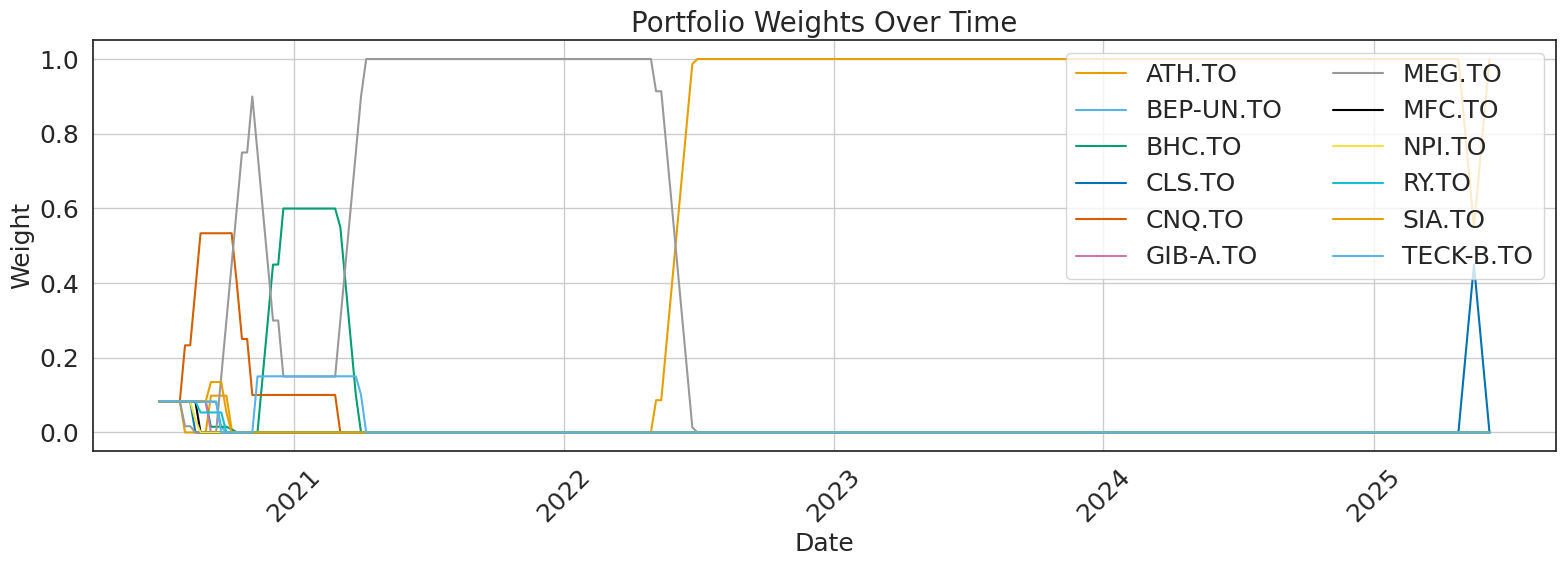

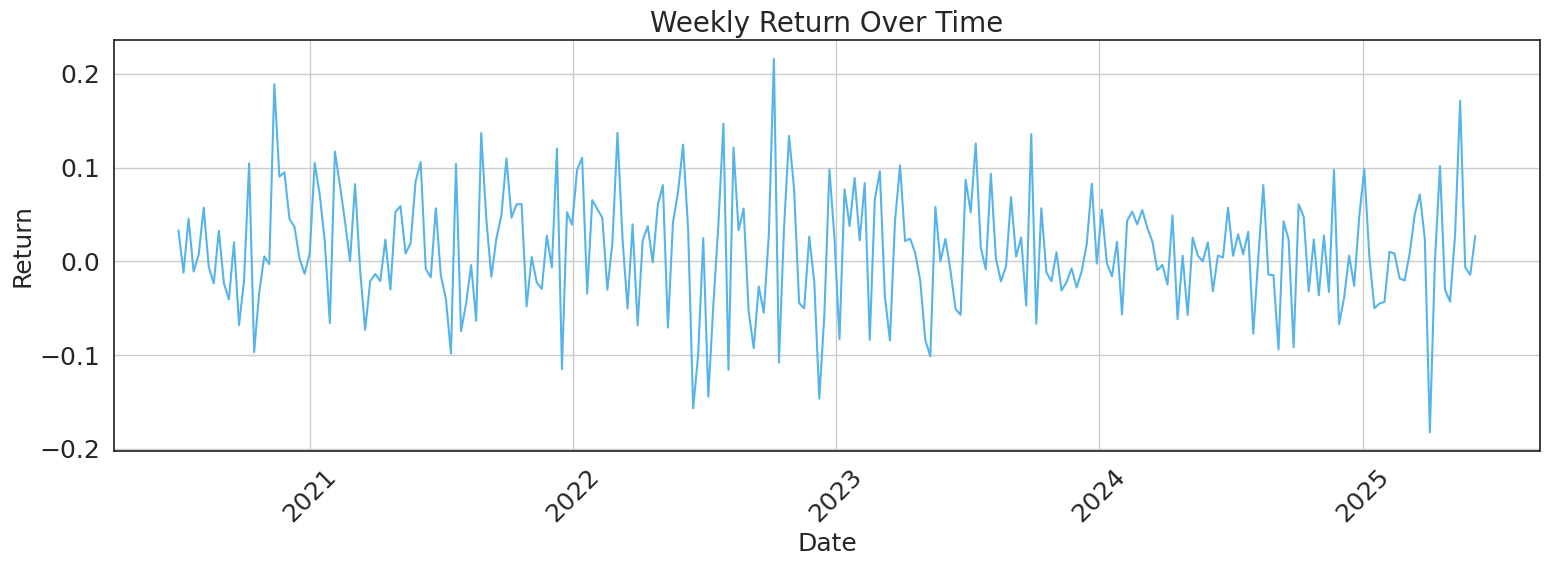

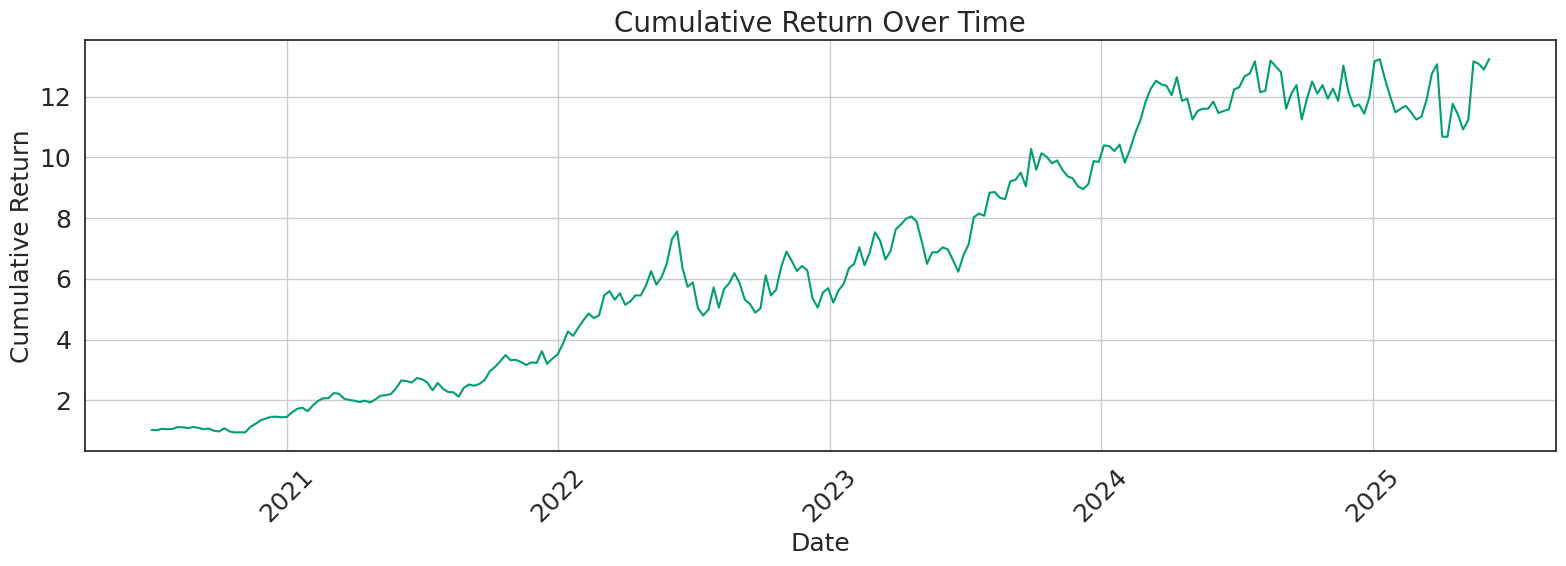

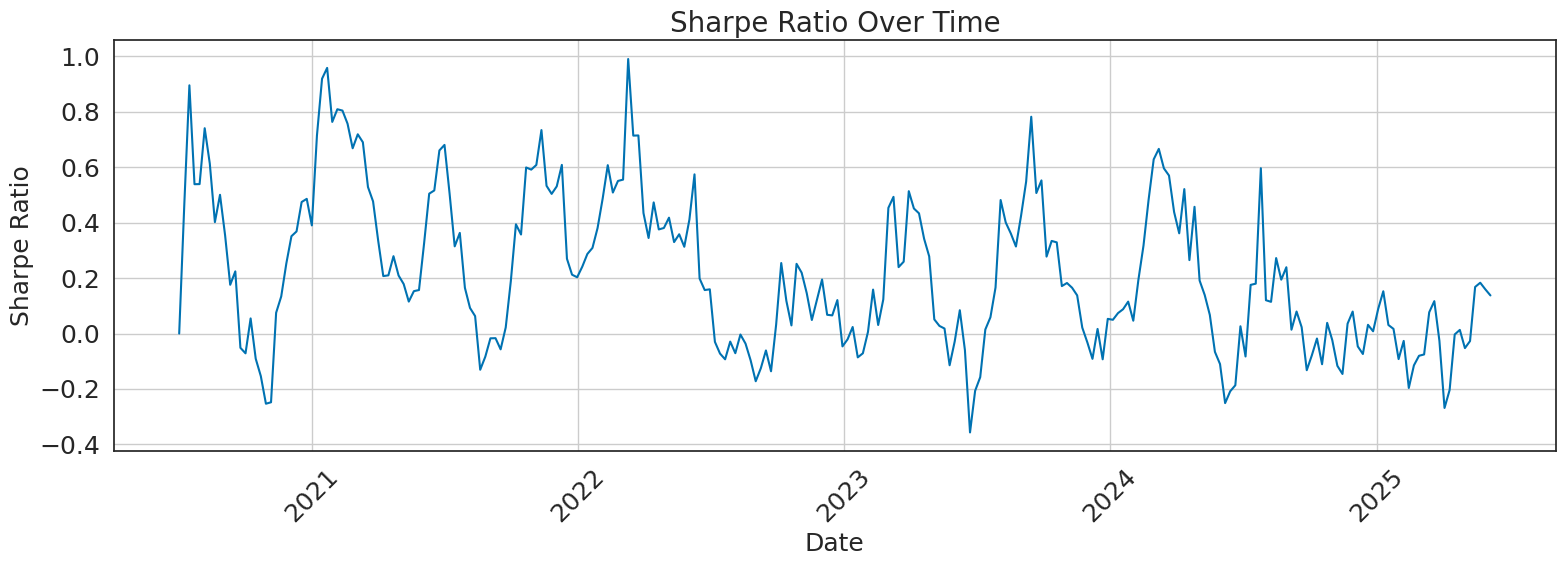

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import statsmodels.api as sm

warnings.filterwarnings('ignore', category=RuntimeWarning)

# === Ensure aligned index ===
common_index = df_out.index.intersection(cl_predicted_returns.index)
df_out_filtered = df_out.loc[common_index]
cl_predicted_returns_filtered = cl_predicted_returns.loc[common_index]

# === Setup ===
stock_columns = cl_predicted_returns_filtered.columns
n_assets = len(stock_columns)
initial_weights = np.ones(n_assets) / n_assets
turnover_limit = 0.3
confidence_level = 0.95
dates = cl_predicted_returns_filtered.index
previous_weights = initial_weights.copy()
cumulative_return = 1

# === Storage ===
hs_weights_history = []
regime_returns_history = []
regime_cumulative_returns_history = []
hs_turnover_history = []
hs_only_signals = []
hs_sharpe_ratio_history = []

# === Parameters for exposure mapping ===
def trend_to_exposure(trend_score, a=5, min_exp=-2, max_exp=3):
    return np.clip(a * trend_score, min_exp, max_exp)

def compute_trend_score(pred_series, i, window=4):
    if i < window:
        return 0
    recent_pred = pred_series.iloc[i - window:i].mean(axis=1).values.reshape(-1, 1)
    time = np.arange(window).reshape(-1, 1)
    lr_model = LinearRegression().fit(time, recent_pred)
    slope = lr_model.coef_[0][0]
    vol = np.std(recent_pred)
    return slope / (vol + 1e-6)

def run_regression(stock_returns, factors):
    df = pd.concat([stock_returns, factors], axis=1).dropna()
    if df.shape[0] < 10:
        return None
    y = df.iloc[:, 0]
    X = sm.add_constant(df.iloc[:, 1:], has_constant='add')
    return sm.OLS(y, X).fit()

def cvar_objective(weights, hist_returns, alpha):
    port_returns = np.dot(hist_returns, weights)
    var = np.percentile(port_returns, 100 * (1 - alpha))
    cvar = port_returns[port_returns <= var].mean()
    return cvar

def negative_sharpe_ratio(weights, predicted_returns, cov_matrix, rf):
    port_return = np.dot(weights, predicted_returns)
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return -(port_return - rf) / port_vol

# === Walk-forward Hybrid Optimization ===
for i in range(n_assets, len(cl_predicted_returns_filtered) - 1):
    current_data = df_out_filtered.iloc[i]
    hist_data = df_out_filtered.iloc[max(0, i - 252):i]
    rf = current_data['RFR']
    betas_ma = []

    # === Regime Detection ===
    prob_0 = current_data['Prob_0']
    prob_1 = current_data['Prob_1']
    regime = 0 if prob_0 > 0.6 else 1

    # === Trend Signal ===
    trend_score = compute_trend_score(cl_predicted_returns_filtered, i)
    target_exposure = trend_to_exposure(trend_score)

    hs_only_signals.append({
        'Date': dates[i],
        'Regime': regime,
        'TrendScore': trend_score,
        'Prob_0': prob_0,
        'Prob_1': prob_1
    })

    # === Betas w.r.t MA_Port_12
    data_subset = df_out_filtered.iloc[:i]
    for stock in stock_columns:
        model = run_regression(
            data_subset[stock] - data_subset['RFR'],
            data_subset[['MARKET_PREMIUM', 'MA_Port_12']]
        )
        beta = model.params.get('MA_Port_12', 0) if model and 'MA_Port_12' in model.params else 0
        betas_ma.append(beta)
    betas_ma = np.array(betas_ma)

    # === Inputs for Optimization ===
    expected_returns = cl_predicted_returns_filtered.iloc[i].values
    cov_matrix = hist_data[stock_columns].ewm(span=63).cov().iloc[-n_assets:].values

    # === Constraints ===
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: turnover_limit - np.sum(np.abs(w - previous_weights))},
        {'type': 'ineq', 'fun': lambda w: np.dot(w, betas_ma) - target_exposure}
    ]
    bounds = [(0, 1)] * n_assets

    # === Optimization ===
    if regime == 0:  # Defensive
        result = minimize(
            cvar_objective,
            previous_weights,
            args=(hist_data[stock_columns].values, confidence_level),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
    else:  # Aggressive
        result = minimize(
            negative_sharpe_ratio,
            previous_weights,
            args=(expected_returns, cov_matrix, rf),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

    weights = result.x if result.success else previous_weights.copy()
    weekly_ret = np.dot(weights, df_out_filtered.iloc[i][stock_columns].values)
    cumulative_return *= (1 + weekly_ret)

    # === Store Results ===
    hs_weights_history.append(weights)
    hs_returns_history.append(weekly_ret)
    hs_turnover_history.append(np.sum(np.abs(weights - previous_weights)))
    rolling = hs_returns_history[-12:] if len(hs_returns_history) >= 12 else hs_returns_history
    sharpe = (np.mean(rolling) - rf) / np.std(rolling) if np.std(rolling) > 0 else 0
    hs_sharpe_ratio_history.append(sharpe)
    previous_weights = weights.copy()

# === Result DataFrames ===
index = dates[n_assets:n_assets + len(hs_weights_history)]
hs_weights_df = pd.DataFrame(hs_weights_history, index=index, columns=stock_columns)
hs_returns_df = pd.DataFrame(hs_returns_history, index=index, columns=['Weekly Return'])
hs_turnover_df = pd.DataFrame(hs_turnover_history, index=index, columns=['Turnover'])
hs_cumulative_df = pd.DataFrame(np.cumprod(1 + np.array(hs_returns_history)), index=index, columns=['Cumulative Return'])
hs_sharpe_df = pd.DataFrame(hs_sharpe_ratio_history, index=index, columns=['Sharpe Ratio'])
hs_signals_df = pd.DataFrame(hs_only_signals).set_index('Date').reindex(index)


# Color-blind-friendly colors (Okabe-Ito & Tableau blend)
cb_colors = [
    "#E69F00", "#56B4E9", "#009E73", "#0072B2",
    "#D55E00", "#CC79A7", "#999999", "#000000",
    "#F0E442", "#17becf"
]

# === 1. Portfolio Weights Over Time ===
plt.figure(figsize=(16, 6))
for i, col in enumerate(hs_weights_df.columns):
    plt.plot(hs_weights_df.index, hs_weights_df[col], label=col, color=cb_colors[i % len(cb_colors)])
plt.title('Portfolio Weights Over Time')
plt.ylabel('Weight')
plt.xlabel('Date')
plt.legend(loc='upper right', ncol=2)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 2. Weekly Return Over Time ===
plt.figure(figsize=(16, 6))
plt.plot(hs_returns_df.index, hs_returns_df['Weekly Return'], color=cb_colors[1])
plt.title('Weekly Return Over Time')
plt.ylabel('Return')
plt.xlabel('Date')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 3. Cumulative Return Over Time ===
plt.figure(figsize=(16, 6))
plt.plot(hs_cumulative_df.index, hs_cumulative_df['Cumulative Return'], color=cb_colors[2])
plt.title('Cumulative Return Over Time')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 4. Sharpe Ratio Over Time ===
plt.figure(figsize=(16, 6))
plt.plot(hs_sharpe_df.index, hs_sharpe_df['Sharpe Ratio'], color=cb_colors[3])
plt.title('Sharpe Ratio Over Time')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Mean-variance only

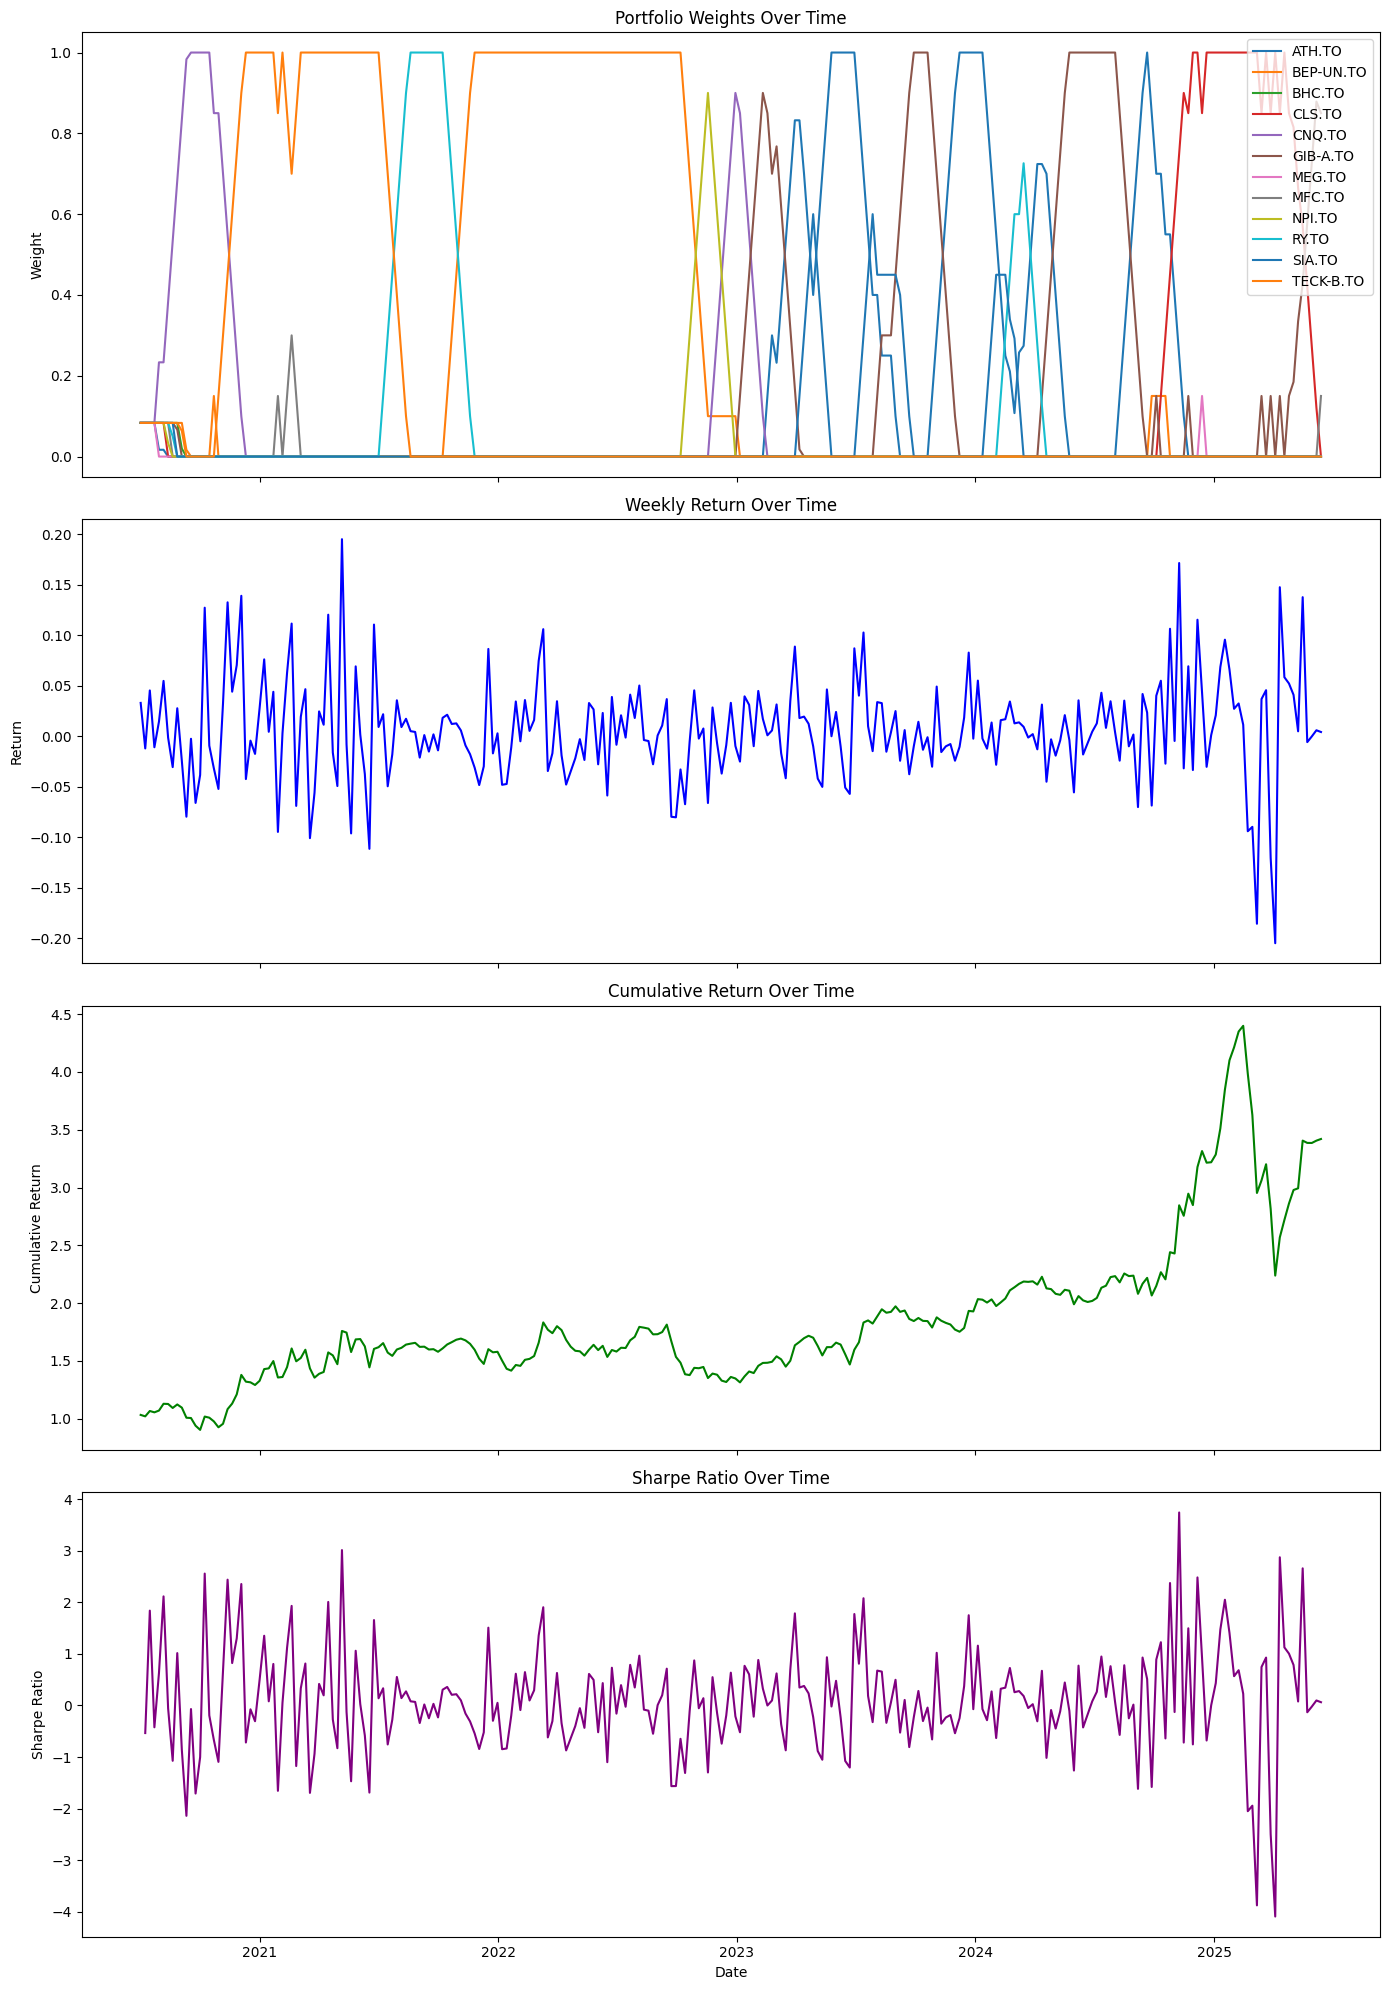

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

# === Assumes you already have: 
df_out = df_out.loc[cl_predicted_returns.index]

stock_columns = cl_predicted_returns.columns
n_assets = len(stock_columns)
dates = cl_predicted_returns.index

# === Initialize ===
initial_weights = np.ones(n_assets) / n_assets
turnover_limit = 0.3
previous_weights = initial_weights.copy()
cumulative_return = 1

# === Storage ===
weights_history = []
returns_history = []
cumulative_returns_history = []
turnover_history = []
sharpe_ratio_history = []

# === Helper Functions ===
def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

def portfolio_std(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, rf):
    port_return = portfolio_return(weights, expected_returns)
    port_vol = portfolio_std(weights, cov_matrix)
    return -((port_return - rf) / port_vol)

# === Rolling Optimization ===
for i in range(n_assets, len(dates)):
    data_subset = df_out.iloc[:i]
    expected_returns = cl_predicted_returns.iloc[i].values
    cov_matrix = data_subset[stock_columns].cov().values
    rf = data_subset['RFR'].iloc[-1]

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: turnover_limit - np.sum(np.abs(w - previous_weights))}
    ]
    bounds = [(0, 1)] * n_assets

    result = minimize(
        negative_sharpe_ratio,
        previous_weights,
        args=(expected_returns, cov_matrix, rf),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    weights = result.x if result.success else previous_weights
    weekly_return = np.dot(weights, df_out.iloc[i][stock_columns].values)
    cumulative_return *= (1 + weekly_return)

    # Store results
    weights_history.append(weights)
    turnover_history.append(np.sum(np.abs(weights - previous_weights)))
    returns_history.append(weekly_return)
    cumulative_returns_history.append(cumulative_return)
    sharpe = (weekly_return - rf) / np.std(returns_history) if np.std(returns_history) > 0 else None
    sharpe_ratio_history.append(sharpe)
    previous_weights = weights

# === Convert to DataFrames ===
index_trimmed = dates[n_assets:]
weights_df = pd.DataFrame(weights_history, index=index_trimmed, columns=stock_columns)
returns_df = pd.DataFrame(returns_history, index=index_trimmed, columns=['Weekly Return'])
cumulative_df = pd.DataFrame(cumulative_returns_history, index=index_trimmed, columns=['Cumulative Return'])
turnover_df = pd.DataFrame(turnover_history, index=index_trimmed, columns=['Turnover'])
sharpe_df = pd.DataFrame(sharpe_ratio_history, index=index_trimmed, columns=['Sharpe Ratio'])

# === Plot ===
fig, axes = plt.subplots(4, 1, figsize=(14, 20), sharex=True)

for col in weights_df.columns:
    axes[0].plot(weights_df.index, weights_df[col], label=col)
axes[0].set_title('Portfolio Weights Over Time')
axes[0].set_ylabel('Weight')
axes[0].legend(loc='upper right')

axes[1].plot(returns_df.index, returns_df['Weekly Return'], color='blue')
axes[1].set_title('Weekly Return Over Time')
axes[1].set_ylabel('Return')

axes[2].plot(cumulative_df.index, cumulative_df['Cumulative Return'], color='green')
axes[2].set_title('Cumulative Return Over Time')
axes[2].set_ylabel('Cumulative Return')

axes[3].plot(sharpe_df.index, sharpe_df['Sharpe Ratio'], color='purple')
axes[3].set_title('Sharpe Ratio Over Time')
axes[3].set_ylabel('Sharpe Ratio')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

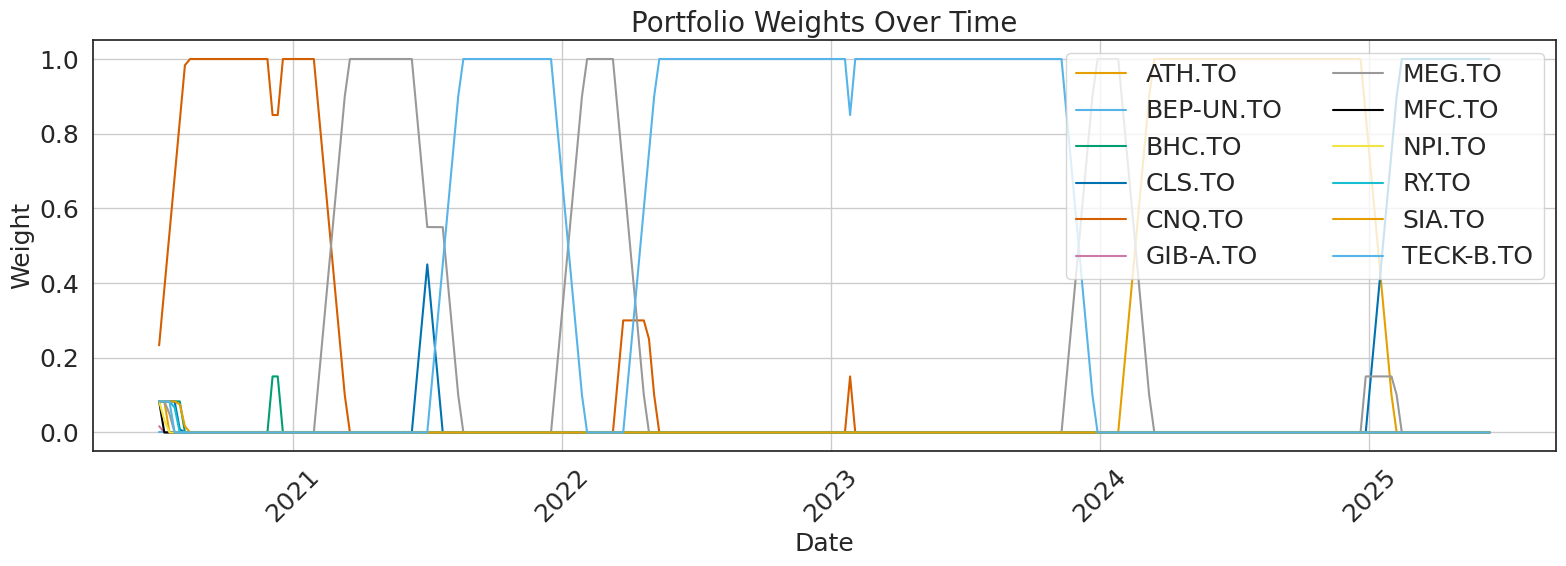

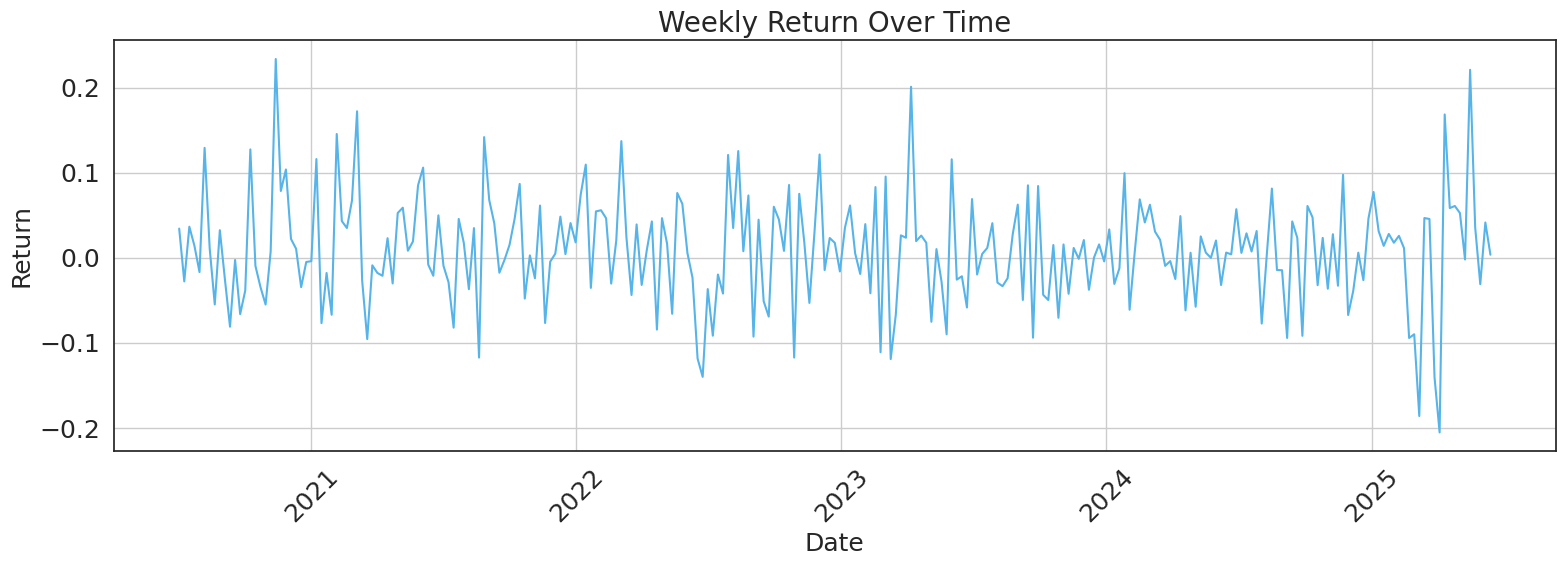

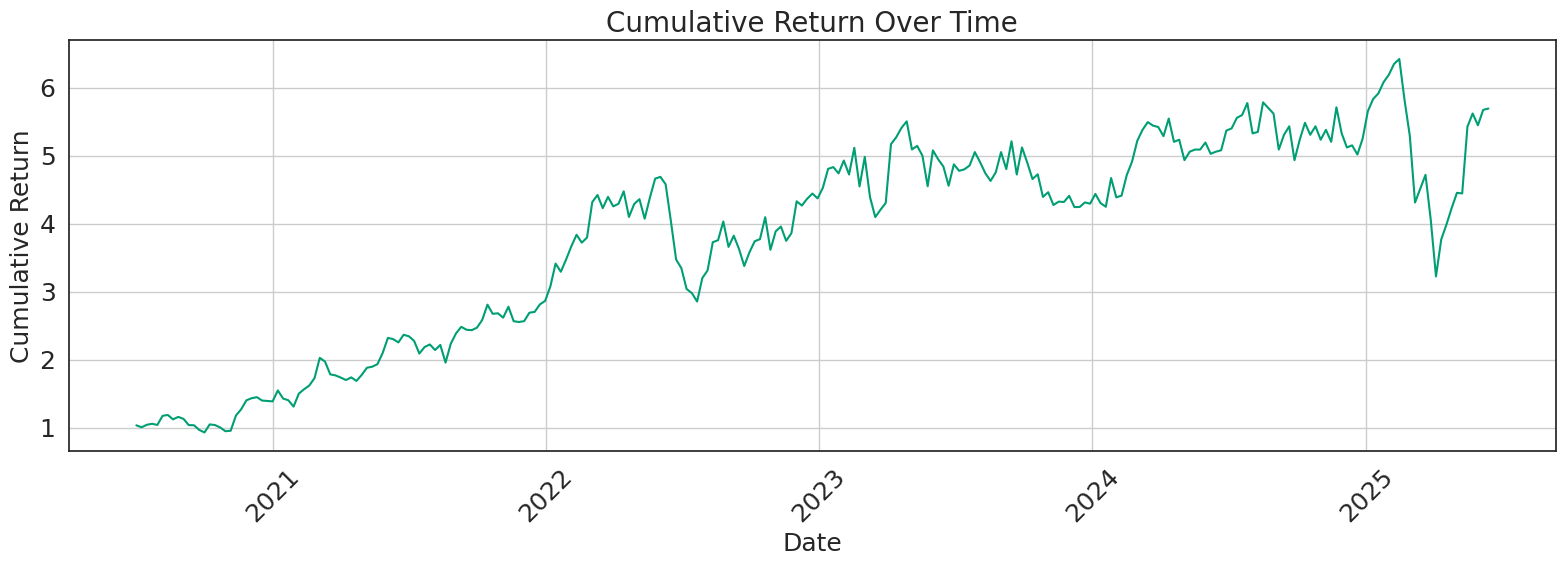

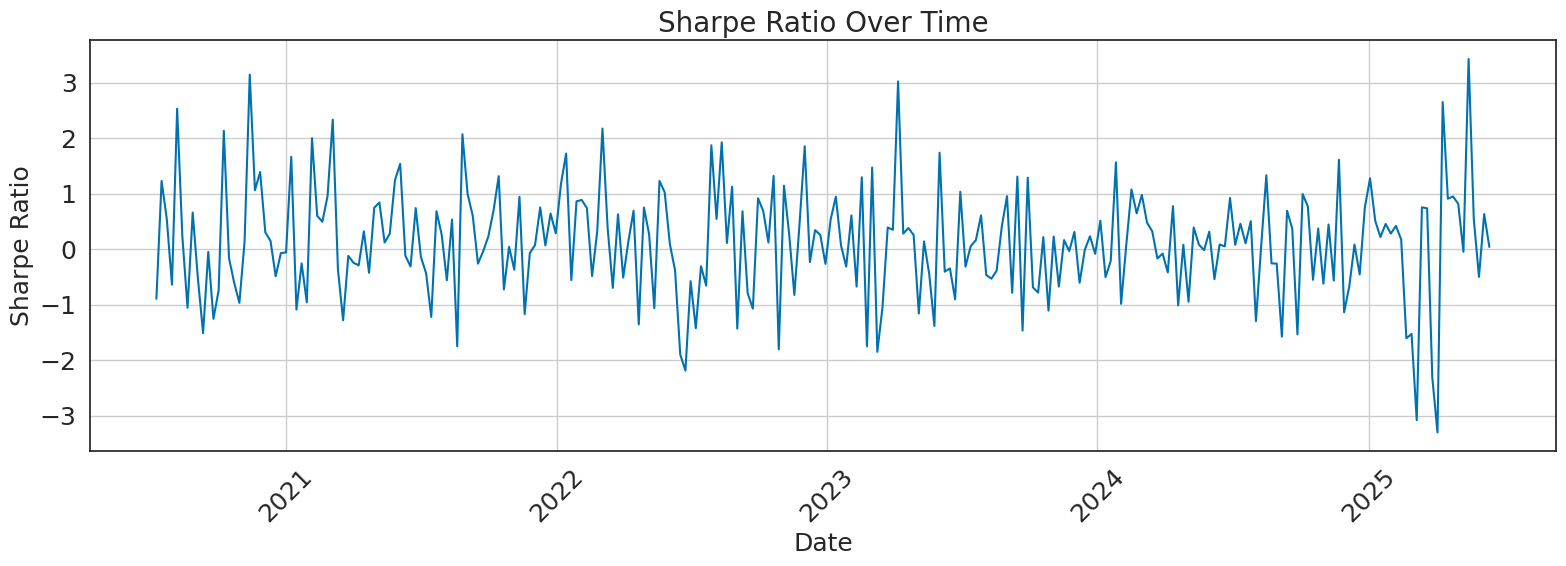

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

# === Assumes you already have: 
df_out = df_out.loc[cl_predicted_returns.index]

stock_columns = cl_predicted_returns.columns
n_assets = len(stock_columns)
dates = cl_predicted_returns.index

# === Initialize ===
initial_weights = np.ones(n_assets) / n_assets
turnover_limit = 0.3
previous_weights = initial_weights.copy()
cumulative_return = 1

# === Storage ===
weights_history = []
returns_history = []
cumulative_returns_history = []
turnover_history = []
sharpe_ratio_history = []
# === Parameters ===
risk_aversion = 1      # You can tune this parameter
confidence_level = 0.95

# === Helper Functions ===
def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

def portfolio_std(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# === New Objective: Excess Return - risk_aversion * CVaR ===
def cvar_penalized_objective(weights, expected_returns, historical_returns, rf, confidence_level, risk_aversion):
    # Excess return
    excess_return = np.dot(weights, expected_returns) - rf
    
    # Portfolio returns (historical)
    port_returns = historical_returns @ weights
    var = np.percentile(port_returns, 100 * (1 - confidence_level))
    cvar = port_returns[port_returns <= var].mean()
    
    # Objective: maximize excess return - risk penalty
    return -(excess_return - risk_aversion * cvar)  # Negative for minimization

# === Rolling Optimization ===
for i in range(n_assets, len(dates)):
    data_subset = df_out.iloc[:i]
    expected_returns = cl_predicted_returns.iloc[i].values
    historical_returns = data_subset[stock_columns].values
    rf = data_subset['RFR'].iloc[-1]

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: turnover_limit - np.sum(np.abs(w - previous_weights))}
    ]
    bounds = [(0, 1)] * n_assets

    result = minimize(
        cvar_penalized_objective,
        previous_weights,
        args=(expected_returns, historical_returns, rf, confidence_level, risk_aversion),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    weights = result.x if result.success else previous_weights
    weekly_return = np.dot(weights, df_out.iloc[i][stock_columns].values)
    cumulative_return *= (1 + weekly_return)

    # Store results
    weights_history.append(weights)
    turnover_history.append(np.sum(np.abs(weights - previous_weights)))
    returns_history.append(weekly_return)
    cumulative_returns_history.append(cumulative_return)
    sharpe = (weekly_return - rf) / np.std(returns_history) if np.std(returns_history) > 0 else None
    sharpe_ratio_history.append(sharpe)
    previous_weights = weights

# === Convert to DataFrames ===
index_trimmed = dates[n_assets:]
weights_df = pd.DataFrame(weights_history, index=index_trimmed, columns=stock_columns)
returns_df = pd.DataFrame(returns_history, index=index_trimmed, columns=['Weekly Return'])
cumulative_df = pd.DataFrame(cumulative_returns_history, index=index_trimmed, columns=['Cumulative Return'])
turnover_df = pd.DataFrame(turnover_history, index=index_trimmed, columns=['Turnover'])
sharpe_df = pd.DataFrame(sharpe_ratio_history, index=index_trimmed, columns=['Sharpe Ratio'])

# Set font sizes globally
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Color-blind-friendly colors (Okabe-Ito & Tableau blend)
cb_colors = [
    "#E69F00", "#56B4E9", "#009E73", "#0072B2",
    "#D55E00", "#CC79A7", "#999999", "#000000",
    "#F0E442", "#17becf"
]

# === 1. Portfolio Weights Over Time ===
plt.figure(figsize=(16, 6))
for i, col in enumerate(weights_df.columns):
    plt.plot(weights_df.index, weights_df[col], label=col, color=cb_colors[i % len(cb_colors)])
plt.title('Portfolio Weights Over Time')
plt.ylabel('Weight')
plt.xlabel('Date')
plt.legend(loc='upper right', ncol=2)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 2. Weekly Return Over Time ===
plt.figure(figsize=(16, 6))
plt.plot(returns_df.index, returns_df['Weekly Return'], color=cb_colors[1])
plt.title('Weekly Return Over Time')
plt.ylabel('Return')
plt.xlabel('Date')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 3. Cumulative Return Over Time ===
plt.figure(figsize=(16, 6))
plt.plot(cumulative_df.index, cumulative_df['Cumulative Return'], color=cb_colors[2])
plt.title('Cumulative Return Over Time')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 4. Sharpe Ratio Over Time ===
plt.figure(figsize=(16, 6))
plt.plot(sharpe_df.index, sharpe_df['Sharpe Ratio'], color=cb_colors[3])
plt.title('Sharpe Ratio Over Time')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# MV portfolio with risk parity

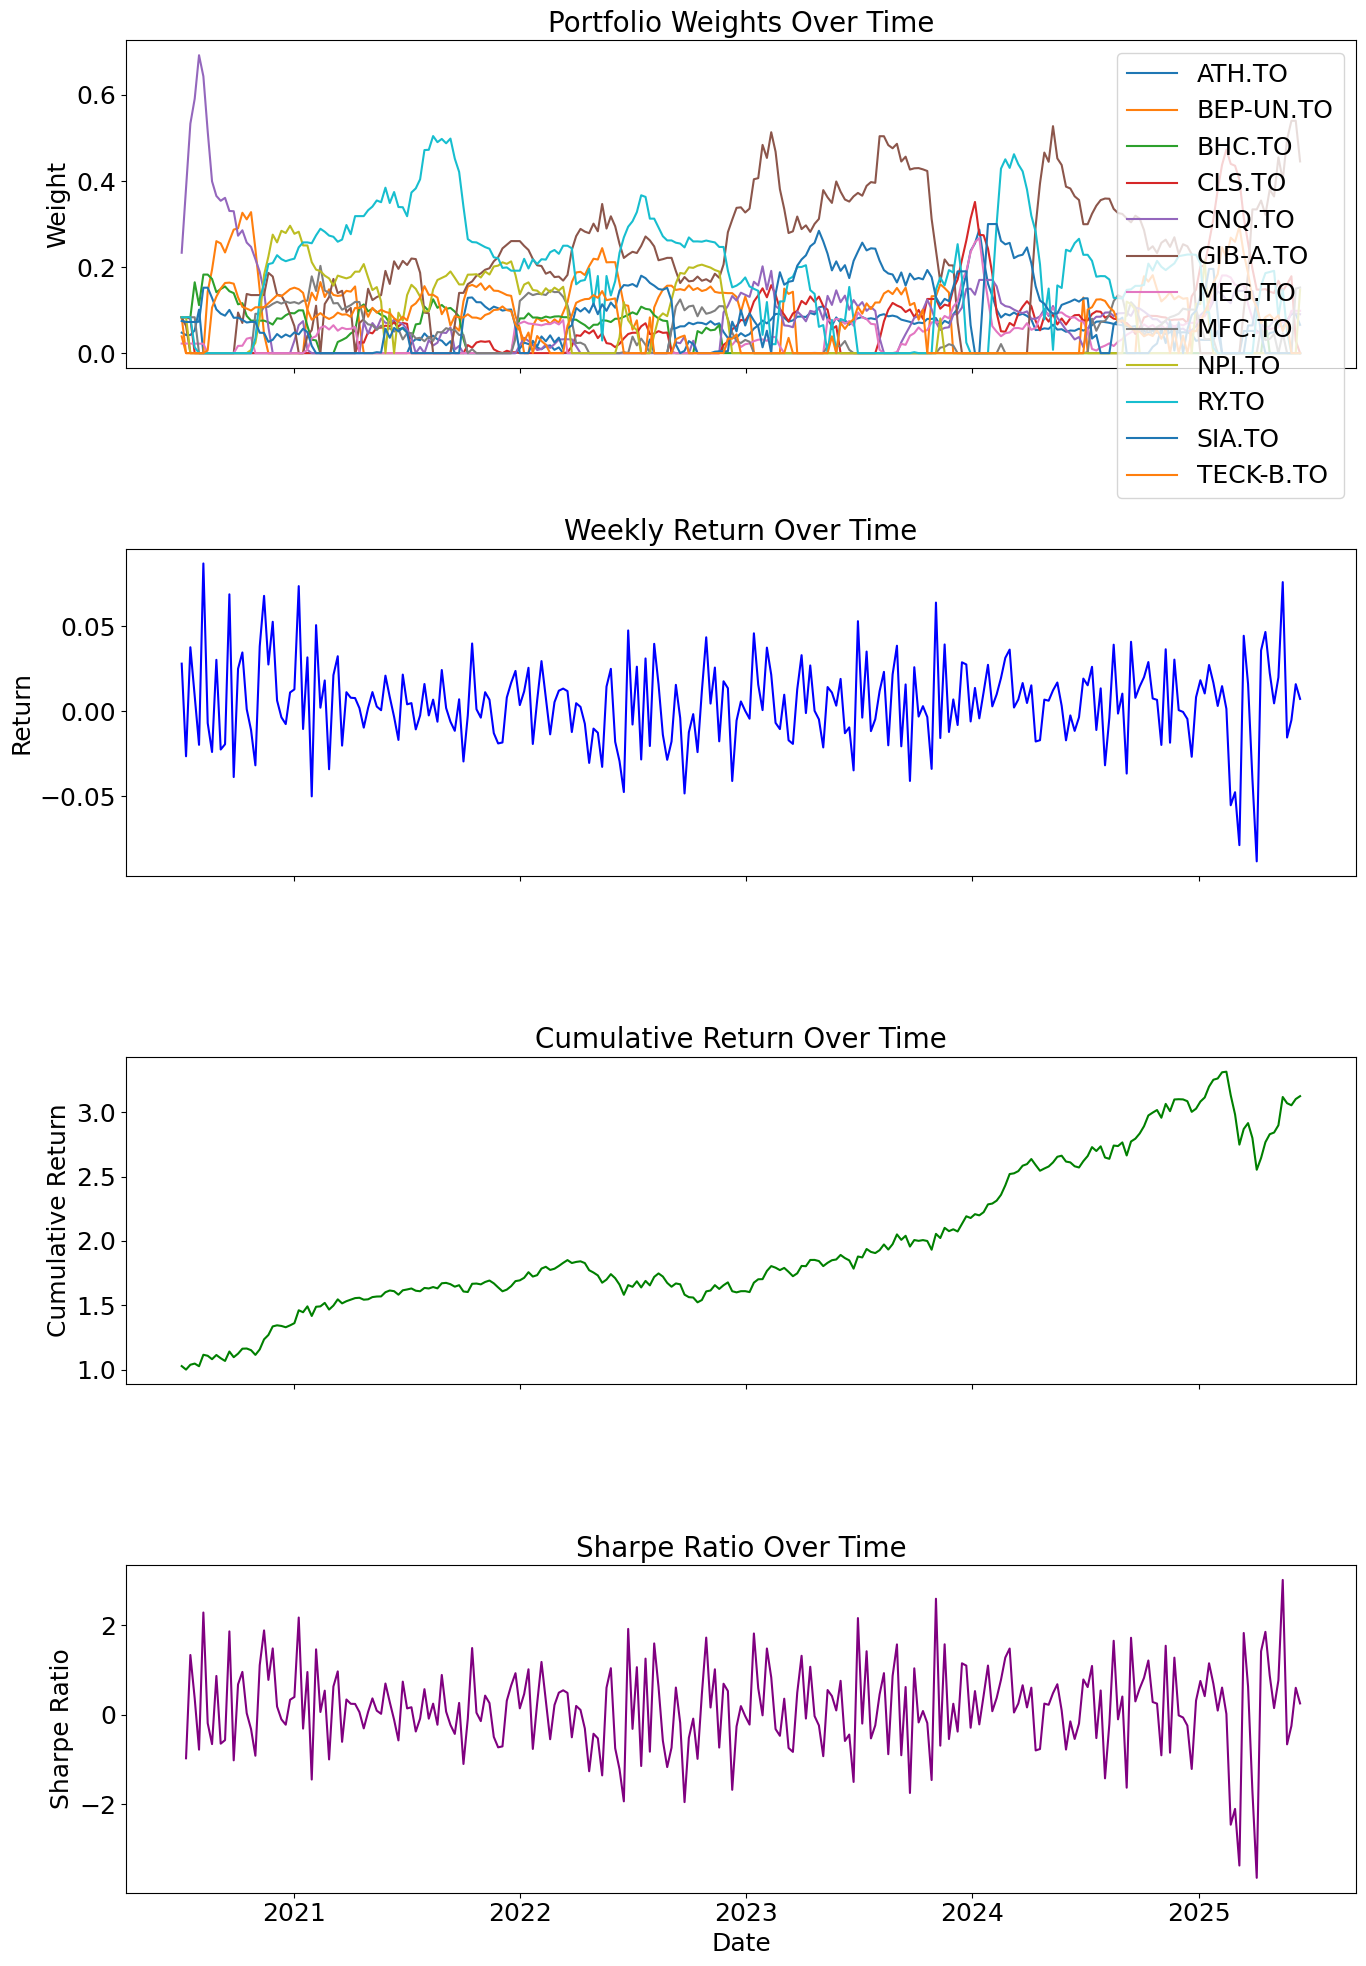

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

# === Assumes you already have: 
df_out = df_out.loc[cl_predicted_returns.index]

stock_columns = cl_predicted_returns.columns
n_assets = len(stock_columns)
dates = cl_predicted_returns.index

# === Initialize ===
initial_weights = np.ones(n_assets) / n_assets
turnover_limit = 0.3
previous_weights = initial_weights.copy()
cumulative_return = 1

# === Storage ===
regime_weights_history = []
regime_returns_history = []
regime_cumulative_returns_history = []
regime_turnover_history = []
regime_sharpe_ratio_history = []
# === Parameters ===
risk_aversion = 0.1      # You can tune this parameter
confidence_level = 0.95

# === Helper Functions ===
def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

def portfolio_std(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# === New Objective: Excess Return - risk_aversion * CVaR ===
def risk_parity_penalized_objective(weights, expected_returns, cov_matrix, rf, risk_aversion):
    # === Excess Return ===
    excess_return = np.dot(weights, expected_returns) - rf

    # === Risk Parity Deviation ===
    port_var = weights.T @ cov_matrix @ weights
    marginal_contrib = cov_matrix @ weights
    risk_contrib = weights * marginal_contrib
    risk_contrib_ratio = risk_contrib / (port_var + 1e-8)  # Avoid divide-by-zero
    risk_parity_penalty = np.sum((risk_contrib_ratio - 1/n_assets)**2)

    # === Final Objective ===
    return -(excess_return - risk_aversion * risk_parity_penalty)

for i in range(n_assets, len(dates)):
    data_subset = df_out.iloc[:i]
    expected_returns = cl_predicted_returns.iloc[i].values
    cov_matrix = data_subset[stock_columns].cov().values
    rf = data_subset['RFR'].iloc[-1]

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: turnover_limit - np.sum(np.abs(w - previous_weights))}
    ]
    bounds = [(0, 1)] * n_assets

    result = minimize(
        risk_parity_penalized_objective,
        previous_weights,
        args=(expected_returns, cov_matrix, rf, risk_aversion),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    weights = result.x if result.success else previous_weights
    weekly_return = np.dot(weights, df_out.iloc[i][stock_columns].values)
    cumulative_return *= (1 + weekly_return)

    # Store results
    weights_history.append(weights)
    turnover_history.append(np.sum(np.abs(weights - previous_weights)))
    returns_history.append(weekly_return)
    cumulative_returns_history.append(cumulative_return)
    sharpe = (weekly_return - rf) / np.std(returns_history) if np.std(returns_history) > 0 else None
    sharpe_ratio_history.append(sharpe)
    previous_weights = weights

# === Convert to DataFrames ===
index_trimmed = dates[n_assets:]
weights_df = pd.DataFrame(weights_history, index=index_trimmed, columns=stock_columns)
returns_df = pd.DataFrame(returns_history, index=index_trimmed, columns=['Weekly Return'])
cumulative_df = pd.DataFrame(cumulative_returns_history, index=index_trimmed, columns=['Cumulative Return'])
turnover_df = pd.DataFrame(turnover_history, index=index_trimmed, columns=['Turnover'])
sharpe_df = pd.DataFrame(sharpe_ratio_history, index=index_trimmed, columns=['Sharpe Ratio'])

# === Plot ===
fig, axes = plt.subplots(4, 1, figsize=(14, 20), sharex=True)

for col in weights_df.columns:
    axes[0].plot(weights_df.index, weights_df[col], label=col)
axes[0].set_title('Portfolio Weights Over Time')
axes[0].set_ylabel('Weight')
axes[0].legend(loc='upper right')

axes[1].plot(returns_df.index, returns_df['Weekly Return'], color='blue')
axes[1].set_title('Weekly Return Over Time')
axes[1].set_ylabel('Return')

axes[2].plot(cumulative_df.index, cumulative_df['Cumulative Return'], color='green')
axes[2].set_title('Cumulative Return Over Time')
axes[2].set_ylabel('Cumulative Return')

axes[3].plot(sharpe_df.index, sharpe_df['Sharpe Ratio'], color='purple')
axes[3].set_title('Sharpe Ratio Over Time')
axes[3].set_ylabel('Sharpe Ratio')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

# Signal Only

0.8654299805504985 Trend Score
-1.3602482750113296
3.885626207969125
0.86127688666762 Trend Score
-1.387976441711784
3.628096197659268
0.8233862914972553 Trend Score
-1.4080099118183054
3.4042093239297038
0.24235360680485563 Trend Score
-1.4214379094875746
3.01892178789938
-0.6188868458735184 Trend Score
-1.4410286496215536
3.021295126459016
-0.8849920624011002 Trend Score
-1.2760421082530928
2.914405863287877
-0.7244912784916955 Trend Score
-1.3754559899936325
2.70635113968025
-0.8046310470713106 Trend Score
-1.40062588842146
2.8672047489994377
-0.6971617158081271 Trend Score
-1.438932639735783
2.7976957868130823
0.36321643977658896 Trend Score
-1.4372776123620166
2.801511933562908
0.020176018017503843 Trend Score
-1.392096817841406
2.7626930472812505
0.4486877161522222 Trend Score
-1.3519494195330277
2.784918884967475
-0.7535729949792009 Trend Score
-1.3396318703997672
2.7763234893616913
-0.37273505204160823 Trend Score
-1.2627617089288217
2.7926214683333246
-0.6967723137647301 Trend

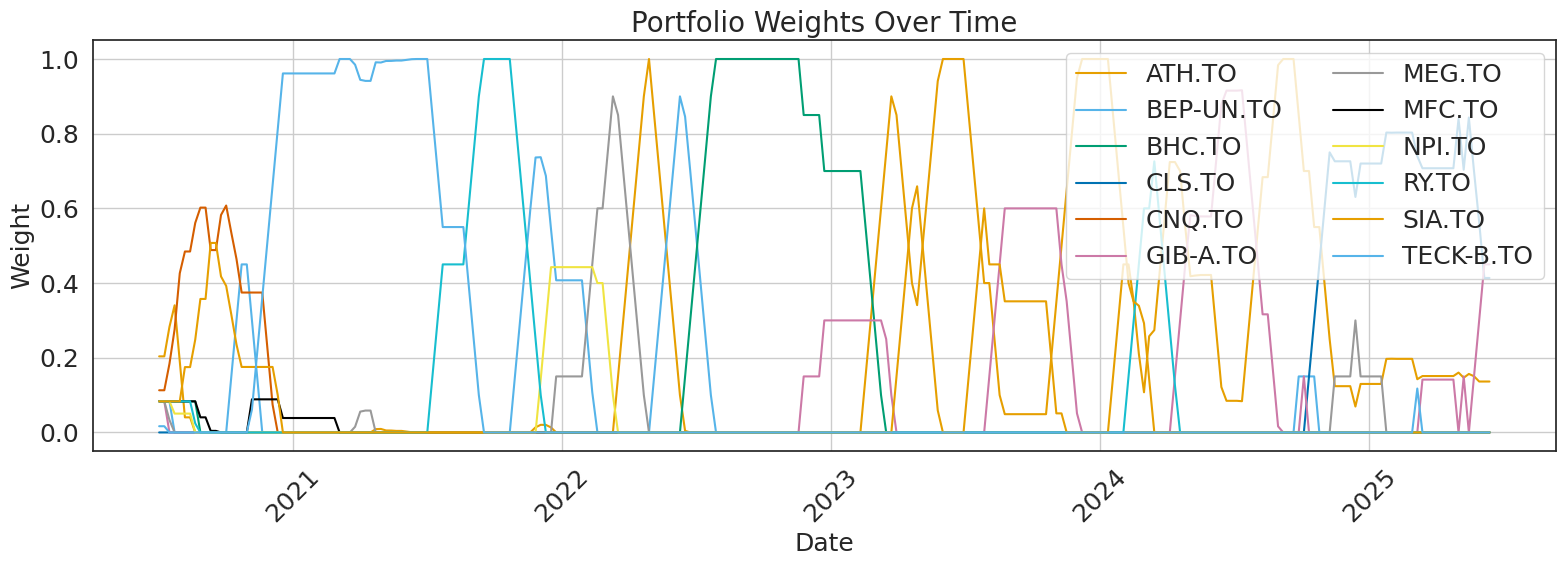

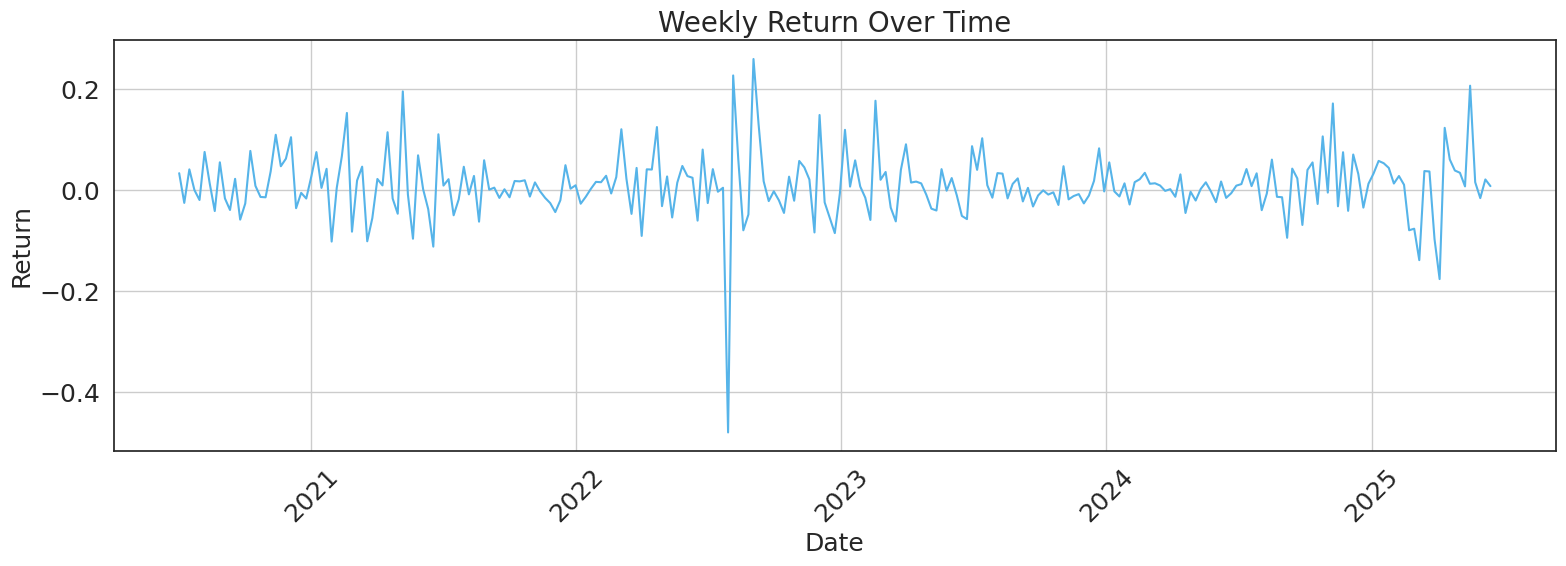

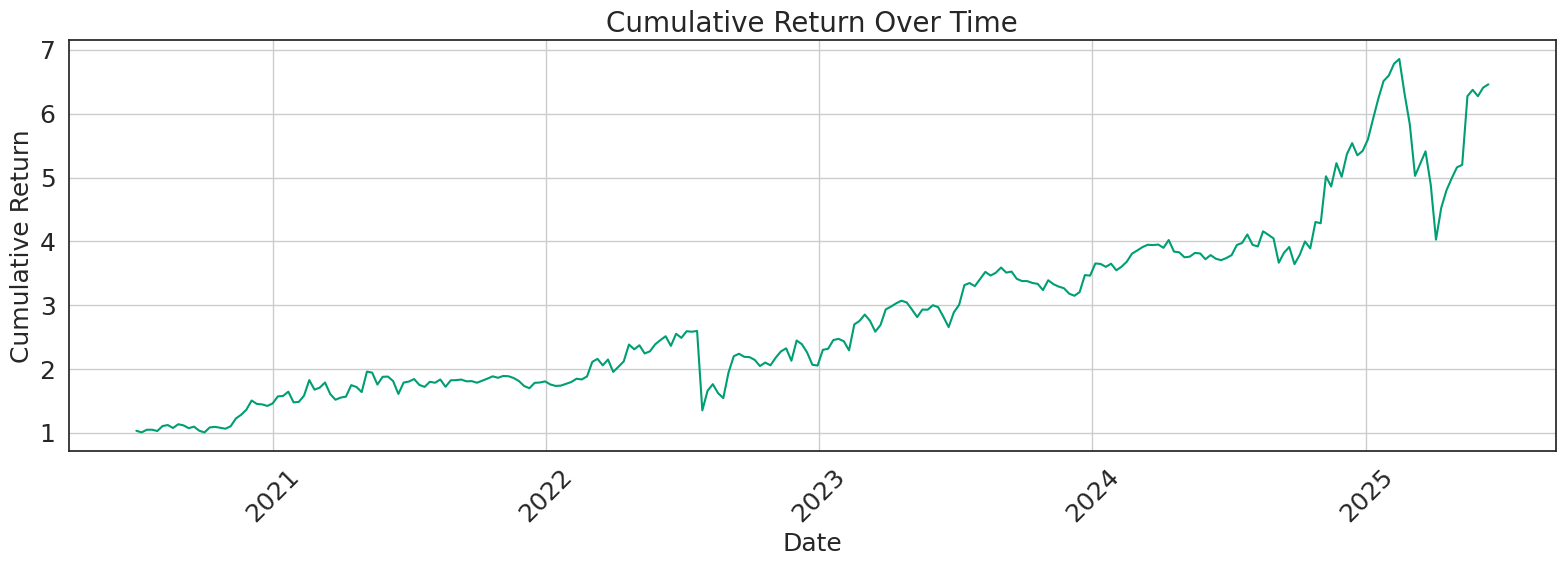

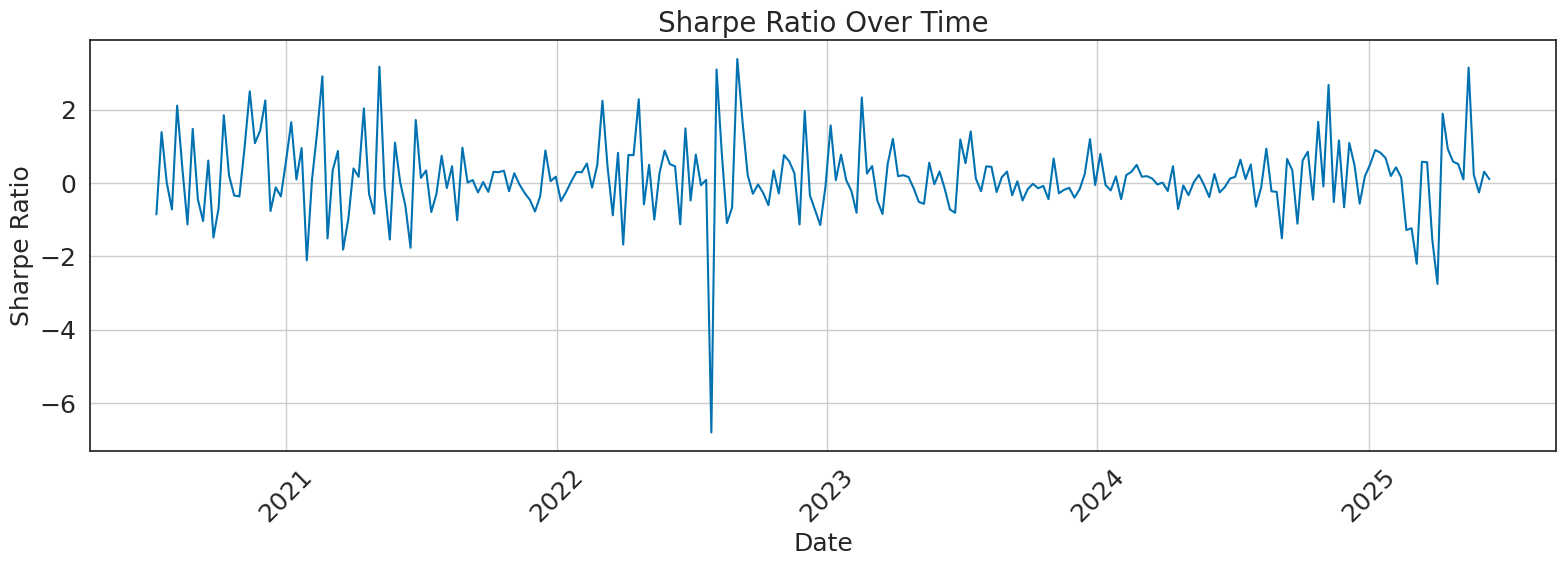

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm
from math import sqrt
from sklearn.linear_model import LinearRegression

# === Assumes you already have: 
# 1. cl_predicted_returns: DataFrame of predicted weekly returns for each stock (columns = stock tickers)
# 2. df_out: DataFrame with actual returns, RFR, MARKET_PREMIUM, MA_Port_12, etc.
df_out = df_out.loc[cl_predicted_returns.index]

stock_columns = cl_predicted_returns.columns
n_assets = len(stock_columns)
dates = cl_predicted_returns.index

# === Initialize ===
turnover_limit = 0.3
previous_weights = np.ones(n_assets) / n_assets
cumulative_return = 1

params = (5, 0, 1)
# params = (5, -1, 2)
def trend_to_exposure(trend_score, a=5, min_exp=-1, max_exp=2):
    return np.clip(a * trend_score, min_exp, max_exp)

# === Helper Functions ===
def run_regression(stock_returns, factors):
    df = pd.concat([stock_returns, factors], axis=1).dropna()
    if df.shape[0] < 10:
        return None
    y = df.iloc[:, 0]
    X = sm.add_constant(df.iloc[:, 1:], has_constant='add')
    return sm.OLS(y, X).fit()

def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

def portfolio_std(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, rf):
    port_return = portfolio_return(weights, expected_returns)
    port_vol = portfolio_std(weights, cov_matrix)
    return -((port_return - rf) / port_vol)

# === Storage ===
signal_weights_history = []
signal_returns_history = []
signal_cumulative_returns_history = []
signal_turnover_history = []
signal_sharpe_ratio_history = []
signal_betas_ma_weights_history = []

def evaluate_strategy(params):
    a, min_exp, max_exp = params
    cumulative_return = 1
    previous_weights = np.ones(n_assets) / n_assets
    # === Rolling Optimization ===
    for i in range(n_assets, len(dates)):
        expected_returns = []
        betas_ma = []

        data_subset = df_out.iloc[:i]

        # Compute recent 12-week average predicted return (portfolio level)
        if i >= 12:
            recent_pred = cl_predicted_returns.iloc[i-4:i].mean(axis=1).values.reshape(-1, 1)
            time = np.arange(4).reshape(-1, 1)

            # Linear trend slope (OLS regression)
            lr_model = LinearRegression().fit(time, recent_pred)
            trend_slope = lr_model.coef_[0][0]  # scalar slope

            # Recent volatility
            recent_vol = np.std(recent_pred)

            # Adjusted trend score: slope normalized by volatility
            trend_score = trend_slope / (recent_vol + 1e-6)  # avoid div by 0
        else:
            trend_score = 0  # not enough data

        expected_returns = cl_predicted_returns.iloc[i].values
        for stock in stock_columns:
            model = run_regression(
                data_subset[stock] - data_subset['RFR'],
                data_subset[['MARKET_PREMIUM', 'MA_Port_12']]
            )
            if model is None or 'const' not in model.params:
                betas_ma.append(0)
            else:
                betas_ma.append(model.params.get('MA_Port_12', 0))

        expected_returns = np.array(expected_returns)
        cov_matrix = data_subset[stock_columns].cov().values
        rf = data_subset['RFR'].iloc[-1]
        betas_ma = np.array(betas_ma)

        print(trend_score, "Trend Score")
        # Exposure Mapping based on trend_score
        # Smoothed exposure mapping (min -1, max 2)
        target_exposure = trend_to_exposure(trend_score, a, min_exp, max_exp)

        print(min(betas_ma))
        print(max(betas_ma))
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda w: turnover_limit - np.sum(np.abs(w - previous_weights))},
            {'type': 'ineq', 'fun': lambda w: np.dot(betas_ma, w) - target_exposure}
        ]
        bounds = [(0, 1)] * n_assets

        result = minimize(
            negative_sharpe_ratio,
            previous_weights,
            args=(expected_returns, cov_matrix, rf),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        weights = result.x if result.success else previous_weights
        weekly_return = np.dot(weights, df_out.iloc[i][stock_columns].values)
        cumulative_return *= (1 + weekly_return)

        # Store results
        signal_weights_history.append(weights)
        signal_turnover_history.append(np.sum(np.abs(weights - previous_weights)))
        signal_betas_ma_weights_history.append(np.dot(weights, betas_ma))
        signal_returns_history.append(weekly_return)
        signal_cumulative_returns_history.append(cumulative_return)
        sharpe = (weekly_return - rf) / np.std(signal_returns_history) if np.std(signal_returns_history) > 0 else None
        signal_sharpe_ratio_history.append(sharpe)
        previous_weights = weights

    sharpe = (np.mean(signal_returns_history) - rf) / np.std(signal_returns_history)
    return -sharpe  # Minimize negative Sharpe

sharpe = evaluate_strategy(params)
print(sharpe)
# === Convert to DataFrames ===
index_trimmed = dates[n_assets:]
signal_weights_df = pd.DataFrame(signal_weights_history, index=index_trimmed, columns=stock_columns)
signal_returns_df = pd.DataFrame(signal_returns_history, index=index_trimmed, columns=['Weekly Return'])
signal_cumulative_df = pd.DataFrame(signal_cumulative_returns_history, index=index_trimmed, columns=['Cumulative Return'])
signal_turnover_df = pd.DataFrame(signal_turnover_history, index=index_trimmed, columns=['Turnover'])
signal_sharpe_df = pd.DataFrame(signal_sharpe_ratio_history, index=index_trimmed, columns=['Sharpe Ratio'])

# Color-blind-friendly colors (Okabe-Ito & Tableau blend)
cb_colors = [
    "#E69F00", "#56B4E9", "#009E73", "#0072B2",
    "#D55E00", "#CC79A7", "#999999", "#000000",
    "#F0E442", "#17becf"
]

# === 1. Portfolio Weights Over Time ===
plt.figure(figsize=(16, 6))
for i, col in enumerate(signal_weights_df.columns):
    plt.plot(signal_weights_df.index, signal_weights_df[col], label=col, color=cb_colors[i % len(cb_colors)])
plt.title('Portfolio Weights Over Time')
plt.ylabel('Weight')
plt.xlabel('Date')
plt.legend(loc='upper right', ncol=2)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 2. Weekly Return Over Time ===
plt.figure(figsize=(16, 6))
plt.plot(signal_returns_df.index, signal_returns_df['Weekly Return'], color=cb_colors[1])
plt.title('Weekly Return Over Time')
plt.ylabel('Return')
plt.xlabel('Date')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 3. Cumulative Return Over Time ===
plt.figure(figsize=(16, 6))
plt.plot(signal_cumulative_df.index, signal_cumulative_df['Cumulative Return'], color=cb_colors[2])
plt.title('Cumulative Return Over Time')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 4. Sharpe Ratio Over Time ===
plt.figure(figsize=(16, 6))
plt.plot(signal_sharpe_df.index, signal_sharpe_df['Sharpe Ratio'], color=cb_colors[3])
plt.title('Sharpe Ratio Over Time')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import optuna

def objective(trial):
    a = trial.suggest_float('a', 1.0, 10.0)
    min_exp = trial.suggest_float('min_exp', -2.0, 0.0)
    max_exp = trial.suggest_float('max_exp', 1.0, 3.0)

    # Run backtest logic here (like evaluate_strategy above)
    neg_sharpe = evaluate_strategy((a, min_exp, max_exp))
    return neg_sharpe  # Negative Sharpe to minimize

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print("Best parameters:", study.best_params)


[I 2025-08-03 14:20:17,328] A new study created in memory with name: no-name-1d0db2f0-a451-454c-935b-e8dace63ebbd


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:20:45,527] Trial 0 finished with value: -0.09169718366328591 and parameters: {'a': 9.595984807321736, 'min_exp': -1.9745232648312867, 'max_exp': 1.1716582066186814}. Best is trial 0 with value: -0.09169718366328591.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:21:13,553] Trial 1 finished with value: -0.09164083738894171 and parameters: {'a': 7.848635155395049, 'min_exp': -0.12359681221538255, 'max_exp': 1.4975020618981671}. Best is trial 0 with value: -0.09169718366328591.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:21:39,237] Trial 2 finished with value: -0.09138683595485206 and parameters: {'a': 7.262245287577088, 'min_exp': -1.0730400343079873, 'max_exp': 1.1319873382462606}. Best is trial 0 with value: -0.09169718366328591.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:22:04,528] Trial 3 finished with value: -0.09096928171273008 and parameters: {'a': 7.161990375253315, 'min_exp': -1.968704506392162, 'max_exp': 1.148773608701885}. Best is trial 0 with value: -0.09169718366328591.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:22:33,799] Trial 4 finished with value: -0.0911140286338648 and parameters: {'a': 2.2657074034290385, 'min_exp': -0.9065973651171031, 'max_exp': 1.5684385193792665}. Best is trial 0 with value: -0.09169718366328591.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:22:57,537] Trial 5 finished with value: -0.09119884289891182 and parameters: {'a': 7.780494593200318, 'min_exp': -0.3337280170083228, 'max_exp': 1.8678445538889936}. Best is trial 0 with value: -0.09169718366328591.


0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Scor

[I 2025-08-03 14:23:23,290] Trial 6 finished with value: -0.091228214951473 and parameters: {'a': 6.7919796177331975, 'min_exp': -0.6863160082140474, 'max_exp': 1.6892578410849033}. Best is trial 0 with value: -0.09169718366328591.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:23:49,177] Trial 7 finished with value: -0.09118202490967611 and parameters: {'a': 9.018724525430779, 'min_exp': -1.7559620756123397, 'max_exp': 1.2037306178768097}. Best is trial 0 with value: -0.09169718366328591.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:24:11,032] Trial 8 finished with value: -0.0913706507557315 and parameters: {'a': 7.056618181984198, 'min_exp': -0.3579074836913674, 'max_exp': 2.6242289204649136}. Best is trial 0 with value: -0.09169718366328591.


-0.729800547440677 Trend Score
-0.23012113062959025
2.1657336681884862
-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend 

[I 2025-08-03 14:24:33,704] Trial 9 finished with value: -0.09134783536421222 and parameters: {'a': 7.815041538609905, 'min_exp': -1.4038973163162094, 'max_exp': 2.0875367868035237}. Best is trial 0 with value: -0.09169718366328591.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:24:56,051] Trial 10 finished with value: -0.09144742648464742 and parameters: {'a': 3.569132304160634, 'min_exp': -1.4317359541109878, 'max_exp': 2.3444363196450446}. Best is trial 0 with value: -0.09169718366328591.


-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Scor

[I 2025-08-03 14:25:23,026] Trial 11 finished with value: -0.09149918775938355 and parameters: {'a': 9.688988361144764, 'min_exp': -0.6380514876802528, 'max_exp': 1.4450973362114685}. Best is trial 0 with value: -0.09169718366328591.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:25:51,145] Trial 12 finished with value: -0.09143624152726822 and parameters: {'a': 4.554803222634865, 'min_exp': -0.0026830162656927836, 'max_exp': 1.410804959643968}. Best is trial 0 with value: -0.09169718366328591.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:26:12,129] Trial 13 finished with value: -0.0916127180852255 and parameters: {'a': 9.946388632376218, 'min_exp': -1.362802227083282, 'max_exp': 2.910896642818193}. Best is trial 0 with value: -0.09169718366328591.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:29:35,170] Trial 14 finished with value: -0.09176608399776441 and parameters: {'a': 5.558761178429306, 'min_exp': -0.03386324503675907, 'max_exp': 1.8586210727229047}. Best is trial 14 with value: -0.09176608399776441.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:29:58,203] Trial 15 finished with value: -0.09191030447726126 and parameters: {'a': 5.608903954211598, 'min_exp': -1.7022267939614233, 'max_exp': 2.115471697096035}. Best is trial 15 with value: -0.09191030447726126.


0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Scor

[I 2025-08-03 14:30:20,247] Trial 16 finished with value: -0.09207897780812045 and parameters: {'a': 5.496956971710701, 'min_exp': -1.118366753175501, 'max_exp': 2.1517424375071736}. Best is trial 16 with value: -0.09207897780812045.


0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Scor

[I 2025-08-03 14:30:41,521] Trial 17 finished with value: -0.09220954095529639 and parameters: {'a': 5.460312270920627, 'min_exp': -1.6343021585504562, 'max_exp': 2.2192985175552877}. Best is trial 17 with value: -0.09220954095529639.


-0.729800547440677 Trend Score
-0.23012113062959025
2.1657336681884862
-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend 

[I 2025-08-03 14:31:04,732] Trial 18 finished with value: -0.09180337944210347 and parameters: {'a': 1.053353261204963, 'min_exp': -1.1404213770405736, 'max_exp': 2.398759065558328}. Best is trial 17 with value: -0.09220954095529639.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:31:25,861] Trial 19 finished with value: -0.09192290915759976 and parameters: {'a': 4.2200297379962795, 'min_exp': -1.666893871906558, 'max_exp': 2.4029870748240865}. Best is trial 17 with value: -0.09220954095529639.


-0.729800547440677 Trend Score
-0.23012113062959025
2.1657336681884862
-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend 

[I 2025-08-03 14:31:47,218] Trial 20 finished with value: -0.09208895049126334 and parameters: {'a': 5.988603314167054, 'min_exp': -1.1907549737855097, 'max_exp': 2.6845075603600193}. Best is trial 17 with value: -0.09220954095529639.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:32:08,820] Trial 21 finished with value: -0.09222686466999298 and parameters: {'a': 4.725225974260788, 'min_exp': -1.234605068014099, 'max_exp': 2.9813927241121316}. Best is trial 21 with value: -0.09222686466999298.


-0.729800547440677 Trend Score
-0.23012113062959025
2.1657336681884862
-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend 

[I 2025-08-03 14:32:31,176] Trial 22 finished with value: -0.09232062765786121 and parameters: {'a': 3.47855064872255, 'min_exp': -1.2846025936507737, 'max_exp': 2.981058773562752}. Best is trial 22 with value: -0.09232062765786121.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:32:55,592] Trial 23 finished with value: -0.09248238692425259 and parameters: {'a': 3.0687132172349707, 'min_exp': -1.5489977156770425, 'max_exp': 2.972029012289358}. Best is trial 23 with value: -0.09248238692425259.


0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Scor

[I 2025-08-03 14:33:17,639] Trial 24 finished with value: -0.09257656887536694 and parameters: {'a': 2.8810072857216054, 'min_exp': -0.8562898879898266, 'max_exp': 2.9963815616040423}. Best is trial 24 with value: -0.09257656887536694.


-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Scor

[I 2025-08-03 14:33:40,078] Trial 25 finished with value: -0.0927054651846498 and parameters: {'a': 2.9508924431762917, 'min_exp': -0.6693715299615465, 'max_exp': 2.7778850266704302}. Best is trial 25 with value: -0.0927054651846498.


-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Scor

[I 2025-08-03 14:34:03,230] Trial 26 finished with value: -0.09273247784768789 and parameters: {'a': 2.5400384295307017, 'min_exp': -0.8430951883527206, 'max_exp': 2.749342806586789}. Best is trial 26 with value: -0.09273247784768789.


0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Scor

[I 2025-08-03 14:34:31,094] Trial 27 finished with value: -0.09249432001621133 and parameters: {'a': 1.7899738165348507, 'min_exp': -0.8704776940453497, 'max_exp': 2.7377884120671303}. Best is trial 26 with value: -0.09273247784768789.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:34:54,681] Trial 28 finished with value: -0.09255130451653577 and parameters: {'a': 2.4379045804032393, 'min_exp': -0.5990112492538093, 'max_exp': 2.7733090079702847}. Best is trial 26 with value: -0.09273247784768789.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:35:19,426] Trial 29 finished with value: -0.09228250514826124 and parameters: {'a': 1.2203028877150761, 'min_exp': -0.8102116937256217, 'max_exp': 2.576164988337676}. Best is trial 26 with value: -0.09273247784768789.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:35:43,502] Trial 30 finished with value: -0.09232873897915866 and parameters: {'a': 2.686788278503032, 'min_exp': -0.5195765634989279, 'max_exp': 2.512158895405375}. Best is trial 26 with value: -0.09273247784768789.


-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Scor

[I 2025-08-03 14:36:08,319] Trial 31 finished with value: -0.09231575937927682 and parameters: {'a': 1.946428028235015, 'min_exp': -0.5171788871214503, 'max_exp': 2.8056752391911175}. Best is trial 26 with value: -0.09273247784768789.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:36:32,820] Trial 32 finished with value: -0.09236500581502992 and parameters: {'a': 2.6674623276003415, 'min_exp': -0.7525475678416145, 'max_exp': 2.8261140416053117}. Best is trial 26 with value: -0.09273247784768789.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:36:55,302] Trial 33 finished with value: -0.09249291275953336 and parameters: {'a': 3.814115463077292, 'min_exp': -1.0162146269307808, 'max_exp': 2.8182703370874704}. Best is trial 26 with value: -0.09273247784768789.


-0.729800547440677 Trend Score
-0.23012113062959025
2.1657336681884862
-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend 

[I 2025-08-03 14:37:18,107] Trial 34 finished with value: -0.09257480653514633 and parameters: {'a': 2.9143221857362445, 'min_exp': -0.5557804400671169, 'max_exp': 2.5197197433440577}. Best is trial 26 with value: -0.09273247784768789.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:37:40,917] Trial 35 finished with value: -0.09269452602968706 and parameters: {'a': 3.057381536014845, 'min_exp': -0.3205511119336265, 'max_exp': 2.5101341468026903}. Best is trial 26 with value: -0.09273247784768789.


0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Scor

[I 2025-08-03 14:38:10,308] Trial 36 finished with value: -0.09266566636361298 and parameters: {'a': 1.6968690060170444, 'min_exp': -0.27911216983721343, 'max_exp': 2.6654057951539287}. Best is trial 26 with value: -0.09273247784768789.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:38:39,021] Trial 37 finished with value: -0.09245064572282666 and parameters: {'a': 1.7173357477014042, 'min_exp': -0.25952208485951817, 'max_exp': 2.262384708301537}. Best is trial 26 with value: -0.09273247784768789.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:39:05,781] Trial 38 finished with value: -0.09246601882275222 and parameters: {'a': 2.1599123820290718, 'min_exp': -0.18162827934149506, 'max_exp': 2.663834536128341}. Best is trial 26 with value: -0.09273247784768789.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:39:33,185] Trial 39 finished with value: -0.09225721265475302 and parameters: {'a': 1.399135058816288, 'min_exp': -0.3893564335402473, 'max_exp': 2.4886168018921935}. Best is trial 26 with value: -0.09273247784768789.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:39:57,064] Trial 40 finished with value: -0.09235874405572456 and parameters: {'a': 3.3563227349868625, 'min_exp': -0.4502508173617508, 'max_exp': 2.6134850863817305}. Best is trial 26 with value: -0.09273247784768789.


-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Scor

[I 2025-08-03 14:40:21,043] Trial 41 finished with value: -0.09246963405529943 and parameters: {'a': 4.2192494393961795, 'min_exp': -0.9468206585457504, 'max_exp': 2.8606100049150527}. Best is trial 26 with value: -0.09273247784768789.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:40:47,206] Trial 42 finished with value: -0.09251598135613903 and parameters: {'a': 2.3384237260561638, 'min_exp': -0.1662246735537511, 'max_exp': 2.729824412342594}. Best is trial 26 with value: -0.09273247784768789.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:41:12,388] Trial 43 finished with value: -0.09263623132935403 and parameters: {'a': 3.088821712713838, 'min_exp': -0.750613652142547, 'max_exp': 2.9089586357451807}. Best is trial 26 with value: -0.09273247784768789.


-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Scor

[I 2025-08-03 14:41:36,322] Trial 44 finished with value: -0.09274498473842621 and parameters: {'a': 3.883226792534346, 'min_exp': -0.7065095888640927, 'max_exp': 2.8944914168231817}. Best is trial 44 with value: -0.09274498473842621.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:42:04,435] Trial 45 finished with value: -0.09247911529485085 and parameters: {'a': 3.9409578905459988, 'min_exp': -0.26309347981832265, 'max_exp': 1.0194128821746866}. Best is trial 44 with value: -0.09274498473842621.


0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Score
-8.088891994577972
16.193216989004267
-0.7806224479484539 Trend Scor

[I 2025-08-03 14:42:31,128] Trial 46 finished with value: -0.09226662700181425 and parameters: {'a': 1.5617268285996309, 'min_exp': -0.665830156687524, 'max_exp': 2.6106293361640334}. Best is trial 44 with value: -0.09274498473842621.


0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Score
-12.388978846156588
18.802903565688972
-0.6068959802158266 Trend Scor

[I 2025-08-03 14:42:57,494] Trial 47 finished with value: -0.09242296169495626 and parameters: {'a': 4.834811810155134, 'min_exp': -0.28829032443898783, 'max_exp': 1.9408953743507062}. Best is trial 44 with value: -0.09274498473842621.


-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Score
-13.607272429431061
21.24261393509542
0.8705862469857494 Trend Scor

[I 2025-08-03 14:43:24,251] Trial 48 finished with value: -0.09247712682491444 and parameters: {'a': 2.147454015322095, 'min_exp': -1.0195625151151282, 'max_exp': 2.4424403688404337}. Best is trial 44 with value: -0.09274498473842621.


-0.859039992727542 Trend Score
-0.2260195134670768
2.1810415497910673
-0.6819571543094011 Trend Score
-0.22605065454237738
2.180541704724078
0.6138768895234139 Trend Score
-0.22615212546468985
2.182263698892246
0.8676880373931464 Trend Score
-26.521247289710196
11.365235773180569
0.8217138701203572 Trend Score
-12.945447508918011
14.999145840093675
0.8480341932826464 Trend Score
-13.859689996358782
17.902254896015574
0.8095451507197499 Trend Score
-14.525966691892883
20.119459949667842
0.8581130003256159 Trend Score
-17.05955767580204
43.745766034844365
0.8637745489544982 Trend Score
-19.533362312982106
41.943736566032605
0.8759323314976615 Trend Score
-18.262957681205886
41.58214739224297
0.8942184351795959 Trend Score
-17.482372652239572
40.34773469898843
0.89062142826895 Trend Score
-18.916815680223017
35.629862612348155
0.8514507254130658 Trend Score
-21.380464877959124
32.3225090364538
0.8697443584873538 Trend Score
-14.34560192639612
20.517133438151152
0.869541244033458 Trend Sco

[I 2025-08-03 14:43:47,497] Trial 49 finished with value: -0.09260123928480204 and parameters: {'a': 8.353413583482086, 'min_exp': -0.43807933976363456, 'max_exp': 2.8854971301927033}. Best is trial 44 with value: -0.09274498473842621.


Best parameters: {'a': 3.883226792534346, 'min_exp': -0.7065095888640927, 'max_exp': 2.8944914168231817}


# Regime Only

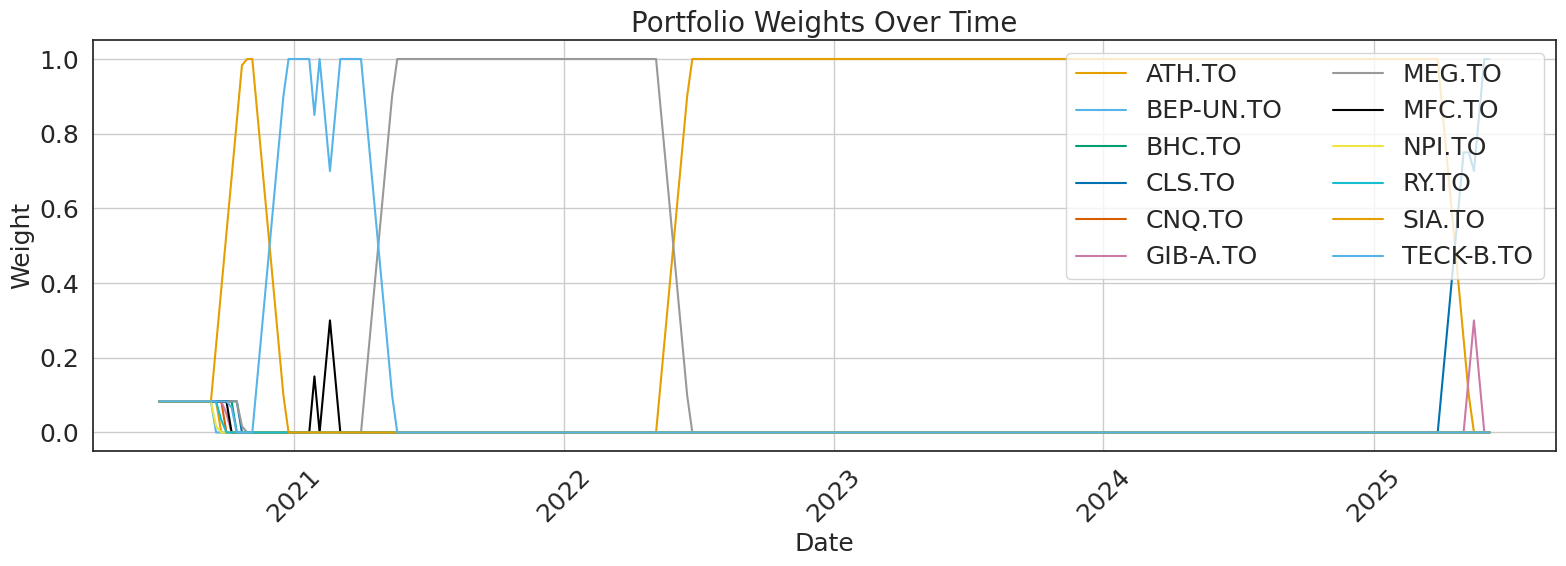

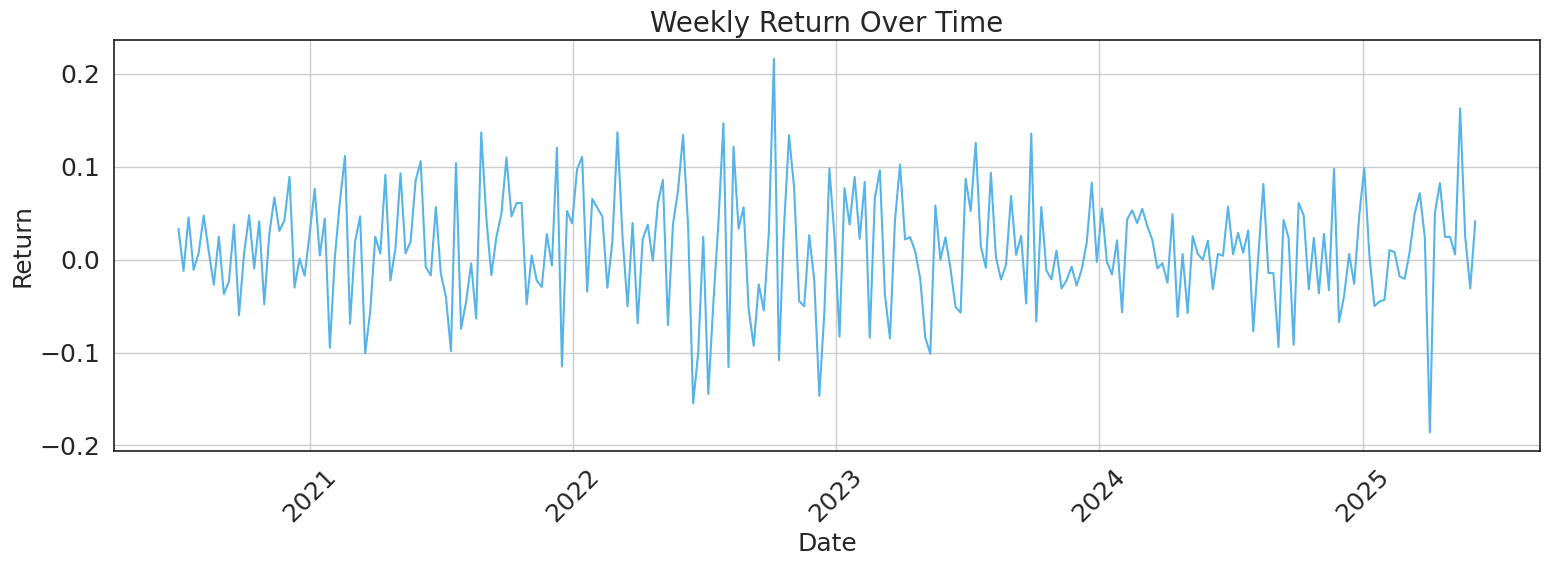

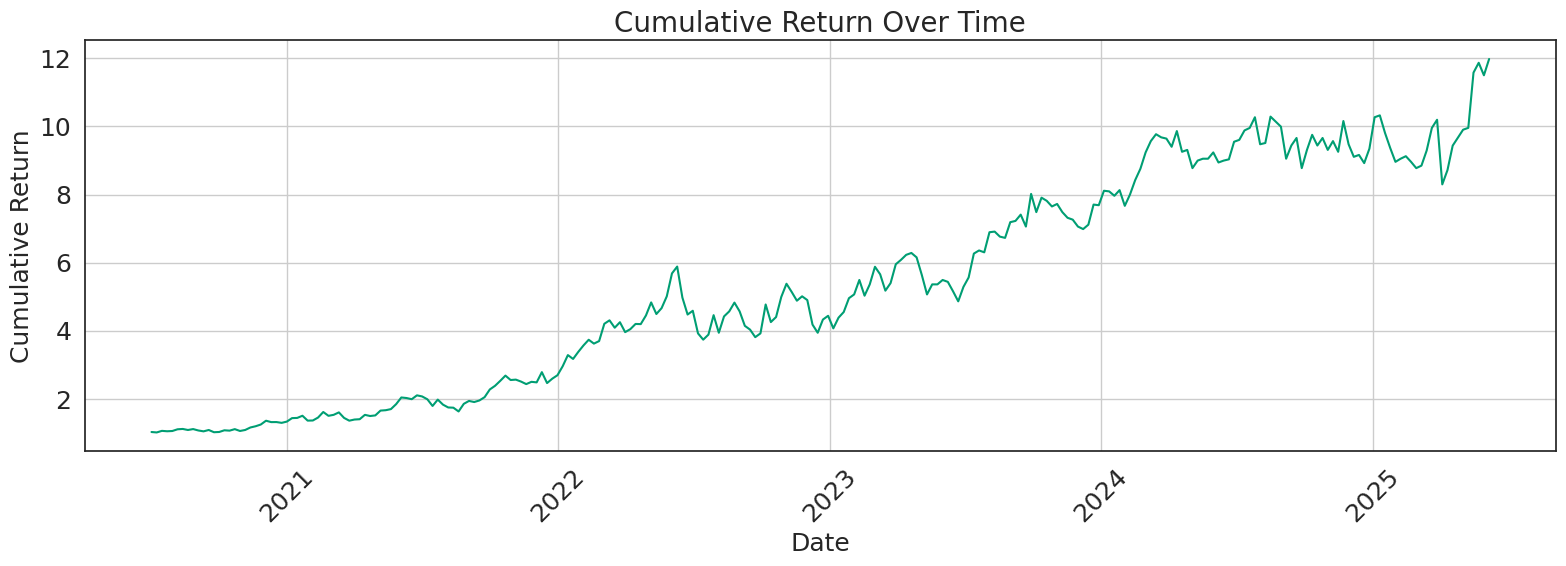

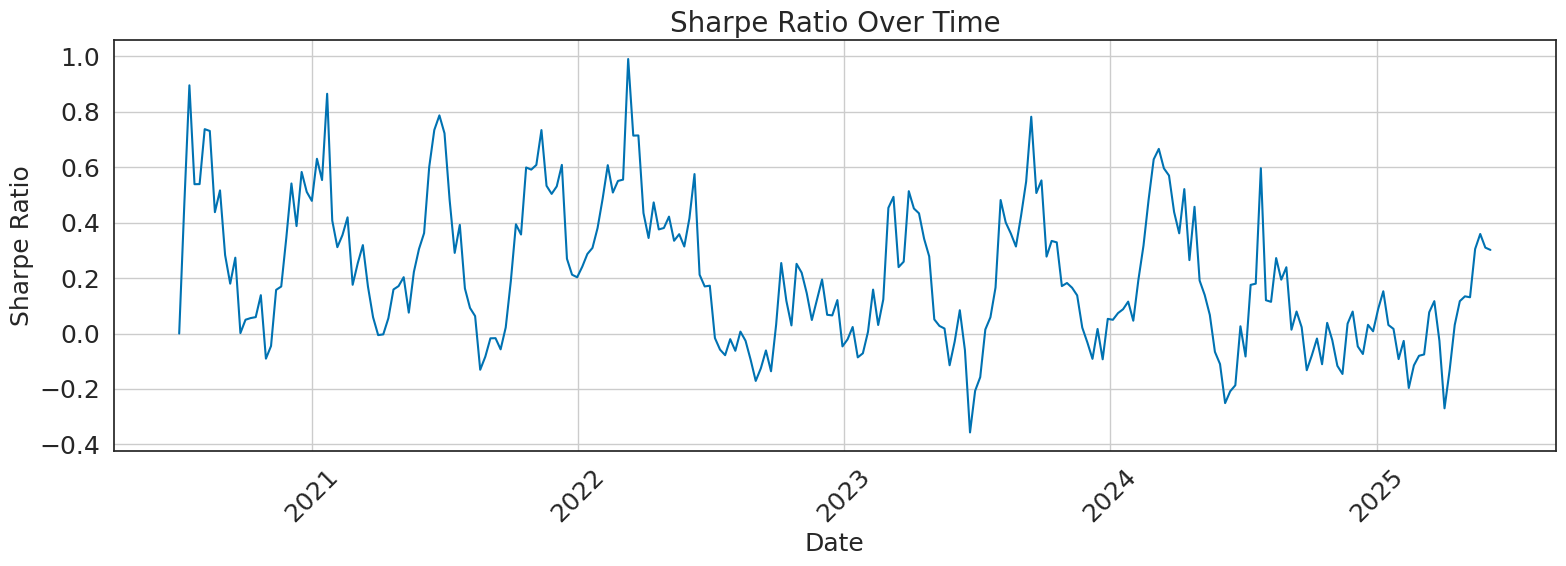

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings

# Suppress runtime warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# === Setup ===
df_out = df_out.loc[cl_predicted_returns.index]
stock_columns = returns.columns
n_assets = len(stock_columns)
initial_weights = np.ones(n_assets) / n_assets
turnover_limit = 0.3
confidence_level = 0.95
dates = cl_predicted_returns.index
previous_weights = initial_weights.copy()
cumulative_return = 1

# === Storage ===
regime_weights_history = []
regime_returns_history = []
regime_cumulative_returns_history = []
regime_turnover_history = []
regime_sharpe_ratio_history = []
regime_only_signals = []

# === Optimization Functions ===
def cvar_objective(weights, historical_returns, confidence_level):
    port_returns = np.dot(historical_returns, weights)
    var = np.percentile(port_returns, 100 * (1 - confidence_level))
    cvar = port_returns[port_returns <= var].mean()
    return cvar  # minimize CVaR

def negative_sharpe_ratio(weights, predicted_returns, cov_matrix, rf):
    port_return = np.dot(weights, predicted_returns)
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return -(port_return - rf) / port_vol

# === Rolling Optimization ===
for i in range(n_assets, len(cl_predicted_returns) - 1):
    current_data = df_out.iloc[i]
    hist_data = df_out.iloc[max(0, i-252):i]
    rf = current_data['RFR']

    # Determine regime (0 = defensive, 1 = aggressive)
    prob_0 = current_data['Prob_0']
    prob_1 = current_data['Prob_1']
    current_regime = 0 if prob_0 > 0.6 else 1

    # Store regime info
    regime_only_signals.append({
        'Date': dates[i],
        'Regime': current_regime,
        'Prob_0': prob_0,
        'Prob_1': prob_1
    })

    predicted_returns = cl_predicted_returns.iloc[i].values
    cov_matrix = hist_data[stock_columns].ewm(span=63).cov().iloc[-n_assets:].values

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: turnover_limit - np.sum(np.abs(w - previous_weights))}
    ]
    bounds = [(0, 1)] * n_assets

    # Regime-specific optimization
    if current_regime == 0:  # Defensive: minimize CVaR
        result = minimize(
            cvar_objective,
            previous_weights,
            args=(hist_data[stock_columns].values, confidence_level),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
    else:  # Aggressive: maximize Sharpe ratio
        result = minimize(
            negative_sharpe_ratio,
            previous_weights,
            args=(predicted_returns, cov_matrix, rf),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

    weights = result.x if result.success else previous_weights.copy()
    weekly_ret = np.dot(weights, df_out.iloc[i][stock_columns].values)
    cumulative_return *= (1 + weekly_ret)

    # Store results
    regime_weights_history.append(weights)
    regime_turnover_history.append(np.sum(np.abs(weights - previous_weights)))
    regime_returns_history.append(weekly_ret)
    regime_cumulative_returns_history.append(cumulative_return)

    rolling_window = regime_returns_history[-12:] if len(regime_returns_history) >= 12 else regime_returns_history
    sharpe = (np.mean(rolling_window) - rf) / np.std(rolling_window) if np.std(rolling_window) > 0 else 0
    regime_sharpe_ratio_history.append(sharpe)

    previous_weights = weights.copy()

# === Results DataFrames ===
index = dates[n_assets:n_assets+len(regime_weights_history)]
regime_weights_df = pd.DataFrame(regime_weights_history, index=index, columns=stock_columns)
regime_sharpe_df = pd.DataFrame(regime_sharpe_ratio_history, index=index, columns=['Sharpe Ratio'])
regime_returns_df = pd.DataFrame(regime_returns_history, index=index, columns=['Weekly Return'])
regime_turnover_df = pd.DataFrame(regime_turnover_history, index=index, columns=['Turnover'])
regime_cumulative_df = pd.DataFrame(regime_cumulative_returns_history, index=index, columns=['Cumulative Return'])
regime_signals_df = pd.DataFrame(regime_only_signals).set_index('Date')[:len(regime_weights_df)]

# Color-blind-friendly colors (Okabe-Ito & Tableau blend)
cb_colors = [
    "#E69F00", "#56B4E9", "#009E73", "#0072B2",
    "#D55E00", "#CC79A7", "#999999", "#000000",
    "#F0E442", "#17becf"
]

# === 1. Portfolio Weights Over Time ===
plt.figure(figsize=(16, 6))
for i, col in enumerate(regime_weights_df.columns):
    plt.plot(regime_weights_df.index, regime_weights_df[col], label=col, color=cb_colors[i % len(cb_colors)])
plt.title('Portfolio Weights Over Time')
plt.ylabel('Weight')
plt.xlabel('Date')
plt.legend(loc='upper right', ncol=2)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 2. Weekly Return Over Time ===
plt.figure(figsize=(16, 6))
plt.plot(regime_returns_df.index, regime_returns_df['Weekly Return'], color=cb_colors[1])
plt.title('Weekly Return Over Time')
plt.ylabel('Return')
plt.xlabel('Date')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 3. Cumulative Return Over Time ===
plt.figure(figsize=(16, 6))
plt.plot(regime_cumulative_df.index, regime_cumulative_df['Cumulative Return'], color=cb_colors[2])
plt.title('Cumulative Return Over Time')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 4. Sharpe Ratio Over Time ===
plt.figure(figsize=(16, 6))
plt.plot(regime_sharpe_df.index, regime_sharpe_df['Sharpe Ratio'], color=cb_colors[3])
plt.title('Sharpe Ratio Over Time')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
cl_predicted_returns

Ticker        ATH.TO BEP-UN.TO    BHC.TO    CLS.TO    CNQ.TO  GIB-A.TO  \
Date                                                                     
2023-04-07  0.054677  0.001518  0.023062  0.017376  0.013146  -0.01238   
2023-06-02 -0.043558  0.008879  0.022987 -0.010372 -0.001813   0.06887   
2023-07-28  0.015977 -0.007749 -0.069371 -0.004902  0.021411  0.005399   
2023-09-22  0.033357  -0.01058 -0.080205 -0.011932  0.054428 -0.002523   
2023-11-17  0.028272  0.015018  0.062448  0.098862  -0.00676 -0.022458   
2024-01-12 -0.000126 -0.067015 -0.015457  0.036865 -0.006557  0.005722   
2024-03-08 -0.029544  0.068717 -0.012358 -0.005542  0.009769 -0.010739   
2024-05-03 -0.023119  0.023533 -0.019797 -0.007044 -0.015188 -0.009887   
2024-06-28  0.020318 -0.024139 -0.023598 -0.045757 -0.045267  0.016824   
2024-08-23 -0.012552  0.001166 -0.027044  0.025687  0.012975  0.000908   
2024-10-18  0.042523  0.002862  0.114838   0.00329 -0.008697 -0.023084   
2024-12-13  0.017934 -0.020286  0.042306  0.039494  0.011486 -0.012235   
2025-02-07  0.020699 -0.037026  0.004038 -0.025744  0.012645  0.002973   
2025-04-04  0.002113 -0.024066 -0.071101 -0.013318  -0.00235  0.012241   
2025-05-30  0.071054 -0.014442 -0.047222 -0.013015  0.005462  -0.03508   

Ticker        MEG.TO    MFC.TO    NPI.TO     RY.TO    SIA.TO TECK-B.TO  
Date                                                                    
2023-04-07  0.005245 -0.008195  0.010873 -0.005116  0.040758  0.076214  
2023-06-02  0.017263  0.014662  0.000002  0.005826  0.007863  0.028759  
2023-07-28  0.011114   0.00293  0.006334  0.010978 -0.003587 -0.040853  
2023-09-22  0.072268 -0.008039 -0.040052  0.014582 -0.019451   0.02382  
2023-11-17  0.011489  0.000864 -0.037772 -0.006919 -0.016938  0.024366  
2024-01-12  0.008067  0.028316 -0.056606  0.024713  -0.01455 -0.032045  
2024-03-08  0.000558 -0.018432 -0.026949   -0.0208  0.045874  0.017161  
2024-05-03  0.003443 -0.033947  0.013196  0.016734  0.006212  0.072583  
2024-06-28  0.006817  0.017552  0.031386 -0.004776 -0.004061  -0.02616  
2024-08-23 -0.010655  0.030369 -0.003817 -0.004514  0.012857 -0.027227  
2024-10-18  -0.03214   0.01555  -0.01094  0.019708  0.017938 -0.049858  
2024-12-13   0.06661  0.007852 -0.022709  0.014996  0.011076  0.007223  
2025-02-07  0.000238 -0.017021  0.029582  0.003089  0.020091 -0.005013  
2025-04-04 -0.008945  0.003232    -0.028 -0.005205  0.002502  0.059024  
2025-05-30 -0.019746 -0.005379 -0.009892 -0.008202 -0.000723   0.02141

# Performance metrics

In [32]:
def calculate_performance_metrics(returns_series, name="", rf_series=None, benchmark_returns=None, frequency="monthly"):
    """
    Calculate portfolio performance metrics, with accurate duration-based CAGR.

    Parameters:
    - returns_series (pd.Series): periodic returns (weekly or monthly), with datetime index
    - name (str): strategy name
    - rf_series (pd.Series or float, optional): risk-free rate aligned or scalar
    - benchmark_returns (pd.Series, optional): benchmark series
    - frequency (str): "monthly" or "weekly"

    Returns:
    - pd.Series: performance metrics
    """
    # Annualization factor
    if frequency == "monthly":
        periods_per_year = 12
    elif frequency == "weekly":
        periods_per_year = 52
    else:
        raise ValueError("Frequency must be 'monthly' or 'weekly'")

    # Ensure datetime index
    if not isinstance(returns_series.index, pd.DatetimeIndex):
        raise ValueError("returns_series must have a DatetimeIndex")

    # Compute time span in years (accounting for missing months/weeks)
    start_date = returns_series.index[0]
    end_date = returns_series.index[-1]
    total_days = (end_date - start_date).days
    years = total_days / 365.25  # Use float division for partial years

    # Align and subtract risk-free rate
    if isinstance(rf_series, pd.Series):
        rf_series = rf_series.reindex_like(returns_series).ffill()
        excess_returns = returns_series - rf_series
        avg_rf = rf_series.mean()
    else:
        default_rf = (1 + 0.026) ** (1 / periods_per_year) - 1  # 2.6% risk-free rate, monthly -> periods_per_year  # Default 2.6% annual
        excess_returns = returns_series - default_rf
        avg_rf = default_rf

    # Cumulative return and CAGR
    cumulative_return = (1 + returns_series).prod()
    cagr = cumulative_return ** (1 / years) - 1

    # Volatility and Sharpe ratio
    ann_vol = returns_series.std() * np.sqrt(periods_per_year)
    sharpe = excess_returns.mean() / (returns_series.std() + 1e-8) * np.sqrt(periods_per_year)

    # Max drawdown
    wealth_index = (1 + returns_series).cumprod()
    max_dd = (wealth_index / wealth_index.cummax() - 1).min()

    # Cvar 95
    # Optional tail risk
    VaR_95 = np.percentile(returns_series, 5)
    CVaR_95 = returns_series[returns_series <= VaR_95].mean()
    
    # Tracking error (if benchmark given)
    # if benchmark_returns is not None:
    aligned_benchmark = benchmark_returns.reindex_like(returns_series).ffill()
    active_returns = returns_series - aligned_benchmark
    tracking_error = active_returns.std() * np.sqrt(periods_per_year)
    # else:
    #     tracking_error = np.nan

    return pd.Series({
        "CAGR": cagr,
        "Volatility": ann_vol,
        "Cvar 95": CVaR_95,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd,
        "Total Return": cumulative_return - 1,
        "Tracking Error": tracking_error,
        "Avg Risk-Free Rate": (1 + avg_rf) ** periods_per_year - 1
    }, name=name)


In [140]:
def compute_rpd(weights_df: pd.DataFrame, returns_df: pd.DataFrame, window: int = 12) -> pd.DataFrame:
    """
    Compute Risk Parity Deviation (RPD) using manual rolling covariance computation.

    Parameters:
    - weights_df: DataFrame of portfolio weights (index: dates, columns: assets)
    - returns_df: DataFrame of asset returns (same shape and index as weights_df)
    - window: lookback period for estimating covariance matrix

    Returns:
    - DataFrame with RPD time series
    """
    # Align and clean data
    weights_df = weights_df.dropna()
    returns_df = returns_df.loc[weights_df.index].dropna()
    
    weights_df = weights_df.loc[weights_df.index.intersection(returns_df.index)]
    returns_df = returns_df.loc[weights_df.index]

    rpd_values = []
    rpd_index = []

    for i in range(window - 1, len(weights_df)):
        t = weights_df.index[i]
        weights = weights_df.iloc[i].values
        ret_window = returns_df.iloc[i - window + 1:i + 1]

        if ret_window.isnull().values.any():
            rpd_values.append(np.nan)
            rpd_index.append(t)
            continue

        cov_matrix = ret_window.cov().values

        if np.isnan(cov_matrix).any() or np.all(weights == 0):
            rpd_values.append(np.nan)
            rpd_index.append(t)
            continue

        port_var = np.dot(weights, np.dot(cov_matrix, weights))
        if port_var == 0:
            rpd_values.append(np.nan)
            rpd_index.append(t)
            continue

        marginal_contrib = np.dot(cov_matrix, weights)
        risk_contributions = weights * marginal_contrib
        normalized_rc = risk_contributions / port_var
        ideal = 1.0 / len(weights)
        rpd = np.sum(np.abs(normalized_rc - ideal))

        rpd_values.append(rpd)
        rpd_index.append(t)

    return pd.DataFrame({'RPD': rpd_values}, index=rpd_index)


## RPD

In [143]:
# Compute RPDs
mv_rpd_df = compute_rpd(weights_df, returns)
signal_rpd_df = compute_rpd(signal_weights_df, returns)
regime_rpd_df = compute_rpd(regime_weights_df, returns)
hs_rpd_df = compute_rpd(hs_weights_df, returns)

# Drop NaNs and show time series (optional)
# print("=== Signal RPD Time Series ===")
# print(signal_rpd_df.dropna().head())

# print("=== Regime RPD Time Series ===")
# print(regime_rpd_df.dropna().head())

# print("=== Hybrid RPD Time Series ===")
# print(hs_rpd_df.dropna().head())

# print("=== Equal Weight RPD Time Series ===")
# print(equal_rpd_df.dropna().head())

# Compute average RPD over time
overall_mv_rpd = mv_rpd_df['RPD'].mean()
overall_signal_rpd = signal_rpd_df['RPD'].mean()
overall_hybrid_rpd = hs_rpd_df['RPD'].mean()
overall_regime_rpd = regime_rpd_df['RPD'].mean()
# Display results
print("\n=== Overall RPD (Lower is Closer to Risk Parity) ===")
print(f"Mean-variance  RPD: {overall_mv_rpd:.2f}")
print(f"Signal-based  RPD: {overall_signal_rpd:.2f}")
print(f"Regime-based  RPD: {overall_regime_rpd:.2f}")
print(f"Hybrid-based  RPD: {overall_hybrid_rpd:.2f}")


=== Overall RPD (Lower is Closer to Risk Parity) ===
Mean-variance  RPD: 1.80
Signal-based  RPD: 1.73
Regime-based  RPD: 1.80
Hybrid-based  RPD: 1.79


In [ ]:
# === Ensure datetime index alignment ===
for df in [regime_returns_df, returns_df, signal_returns_df, hs_returns_df, rf_weekly, sptsx_returns]:
    df.index = pd.to_datetime(df.index)

# Align all return series to a common index
common_index = regime_returns_df.index
rf_series = rf_weekly.loc[common_index].ffill()
sptsx_aligned = sptsx_returns.loc[common_index].ffill()

# === Strategy return series mapping ===
strategy_returns = {
    "CNN-LSTM + Regime Portfolio": regime_returns_df.squeeze(),
    "CNN-LSTM Mean-Var Portfolio": returns_df.squeeze(),
    "CNN-LSTM Signal Portfolio": signal_returns_df.squeeze(),
    "CNN-LSTM Hybrid Score Portfolio": hs_returns_df.squeeze()
}

# === Compute metrics in a loop ===
metrics_list = []
for name, returns in strategy_returns.items():
    metrics = calculate_performance_metrics(
        returns_series=returns,
        name=name,
        rf_series=rf_series,
        benchmark_returns=sptsx_returns_series,
        frequency="weekly"
    )
    metrics_list.append(metrics)

# === Combine and display ===
metrics_df = pd.concat(metrics_list, axis=1).T.round(4)
metrics_df

CAGR  Volatility  Cvar 95  Sharpe Ratio  \
CNN-LSTM + Regime Portfolio      0.6556      0.4389  -0.1200        1.2995   
CNN-LSTM Mean-Var Portfolio      0.4216      0.4611  -0.1255        0.9261   
CNN-LSTM Signal Portfolio        0.4584      0.4679  -0.1335        0.9951   
CNN-LSTM Hybrid Score Portfolio  0.6896      0.4491  -0.1194        1.3241   

                                 Max Drawdown  Total Return  Tracking Error  \
CNN-LSTM + Regime Portfolio           -0.3643       10.9800          0.3950   
CNN-LSTM Mean-Var Portfolio           -0.4979        4.6942          0.4046   
CNN-LSTM Signal Portfolio             -0.4793        5.4616          0.4496   
CNN-LSTM Hybrid Score Portfolio       -0.3657       12.2415          0.4044   

                                 Avg Risk-Free Rate  
CNN-LSTM + Regime Portfolio                  0.0287  
CNN-LSTM Mean-Var Portfolio                  0.0288  
CNN-LSTM Signal Portfolio                    0.0288  
CNN-LSTM Hybrid Score Portfolio              0.0287

## Merge every strategy into a single dataframe

In [174]:
# === Load returns ===
assignment23_returns = pd.read_csv('all_returns_df_2.csv', index_col='Date', parse_dates=True)

# === Extract & rename strategies from assignment ===
assignment_strategies = {
    'Equal-Weight': assignment23_returns['Equal-Weight'],
    'MPT Optimized': assignment23_returns['MPT Optimized'],
    'QR Score': assignment23_returns['QR Score'],
    'Hybrid': assignment23_returns['Hybrid'],
    'Signal Only': assignment23_returns['Signal Only'],
    'Regime Only': assignment23_returns['Regime Only']
}

# === Deep learning portfolios (ensure datetime index) ===
dl_strategies = {
    'CNN-LSTM Regime Portfolio': regime_returns_df.squeeze(),
    'CNN-LSTM Mean-Var Portfolio': returns_df.squeeze(),
    'CNN-LSTM Signal Portfolio': signal_returns_df.squeeze(),
    'CNN-LSTM Hybrid Score Portfolio': hs_returns_df.squeeze()
}

# Ensure all deep learning indices are datetime
for df in dl_strategies.values():
    df.index = pd.to_datetime(df.index)

# === Combine all strategies ===
all_returns_df = pd.concat(
    [series.rename(name) for name, series in {**assignment_strategies, **dl_strategies}.items()],
    axis=1,
    join='outer'
)

# Optional: ensure index is sorted
all_returns_df.sort_index(inplace=True)

# Preview
all_returns_df.head(15)


Equal-Weight  MPT Optimized  QR Score    Hybrid  Signal Only  \
Date                                                                       
2020-02-29     -0.100622      -0.262745 -0.073277       NaN          NaN   
2020-03-31     -0.303137       0.162518 -0.364913       NaN          NaN   
2020-04-30      0.212832       0.006104  0.175765       NaN          NaN   
2020-05-31      0.004076      -0.019645 -0.013231       NaN          NaN   
2020-06-30      0.056105       0.104078  0.141103       NaN          NaN   
2020-07-03           NaN            NaN       NaN  0.033245     0.036807   
2020-07-10           NaN            NaN       NaN -0.022295    -0.009046   
2020-07-17           NaN            NaN       NaN  0.032229     0.040521   
2020-07-24           NaN            NaN       NaN  0.010253    -0.011778   
2020-07-31      0.036055       0.025401  0.012073 -0.024435     0.011774   
2020-08-07           NaN            NaN       NaN  0.086203     0.029646   
2020-08-14           NaN            NaN       NaN  0.043647    -0.011343   
2020-08-21           NaN            NaN       NaN -0.062910     0.000798   
2020-08-28           NaN            NaN       NaN  0.024334     0.004793   
2020-08-31      0.029056       0.143110  0.020882       NaN          NaN   

            Regime Only  CNN-LSTM Regime Portfolio  \
Date                                                 
2020-02-29          NaN                        NaN   
2020-03-31          NaN                        NaN   
2020-04-30          NaN                        NaN   
2020-05-31          NaN                        NaN   
2020-06-30          NaN                        NaN   
2020-07-03     0.033243                   0.033045   
2020-07-10    -0.022292                  -0.012083   
2020-07-17     0.033703                   0.045396   
2020-07-24     0.013636                  -0.010907   
2020-07-31    -0.011269                   0.007023   
2020-08-07     0.100322                   0.047425   
2020-08-14     0.007018                   0.008935   
2020-08-21    -0.053204                  -0.027140   
2020-08-28     0.032653                   0.024566   
2020-08-31          NaN                        NaN   

            CNN-LSTM Mean-Var Portfolio  CNN-LSTM Signal Portfolio  \
Date                                                                 
2020-02-29                          NaN                        NaN   
2020-03-31                          NaN                        NaN   
2020-04-30                          NaN                        NaN   
2020-05-31                          NaN                        NaN   
2020-06-30                          NaN                        NaN   
2020-07-03                     0.034347                   0.033696   
2020-07-10                    -0.027677                  -0.025021   
2020-07-17                     0.036607                   0.041288   
2020-07-24                     0.014110                   0.000318   
2020-07-31                    -0.016708                  -0.019345   
2020-08-07                     0.129213                   0.075724   
2020-08-14                     0.011224                   0.013852   
2020-08-21                    -0.054754                  -0.041170   
2020-08-28                     0.032485                   0.055232   
2020-08-31                          NaN                        NaN   

            CNN-LSTM Hybrid Score Portfolio  
Date                                         
2020-02-29                              NaN  
2020-03-31                              NaN  
2020-04-30                              NaN  
2020-05-31                              NaN  
2020-06-30                              NaN  
2020-07-03                         0.033045  
2020-07-10                        -0.012083  
2020-07-17                         0.045396  
2020-07-24                        -0.010907  
2020-07-31                         0.007023  
2020-08-07                         0.057310  
2020-08-14 

In [120]:
signal_turnover_avg = signal_turnover_df.mean()
regime_returns_avg = regime_turnover_df.mean()
mv_turnover_avg = turnover_df.mean()
hs_turnover_avg = hs_turnover_df.mean()

turnover_df = pd.DataFrame({
    'Signal Only': signal_turnover_avg,
    'Regime Only': regime_returns_avg,
    'Mean-Var Portfolio': mv_turnover_avg,
    'Hybrid': hs_turnover_avg,
})

turnover_df

Signal Only  Regime Only  Mean-Var Portfolio    Hybrid
Turnover     0.155181     0.047804            0.072716  0.038762

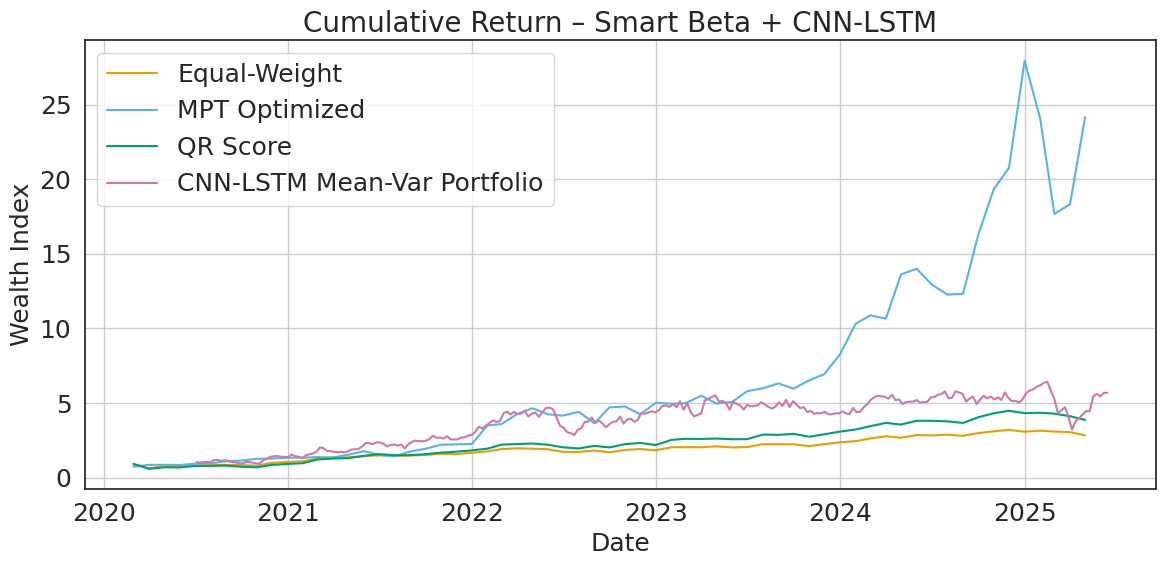

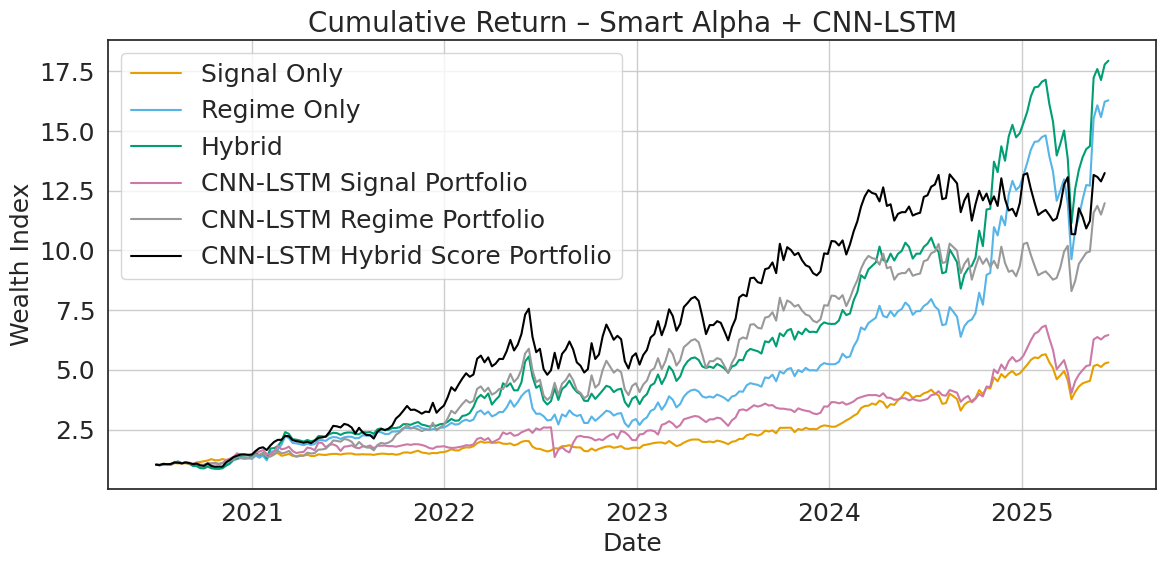

In [175]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Color-blind-friendly palette (CUD) ===
cud_colors = [
    "#E69F00", "#56B4E9", "#009E73",
    "#CC79A7",
    "#999999", "#000000"
]

plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})
# === Load returns if not loaded already ===
# all_returns_df = pd.read_csv('all_returns_df_2.csv', index_col='Date', parse_dates=True)

# === Smart Beta Portfolios ===
smart_beta_names = [
    "Equal-Weight", "MPT Optimized", "QR Score",
    "CNN-LSTM Mean-Var Portfolio"
]

# === Smart Alpha Portfolios ===
smart_alpha_names = [
    "Signal Only", "Regime Only", "Hybrid",
    "CNN-LSTM Signal Portfolio", "CNN-LSTM Regime Portfolio", "CNN-LSTM Hybrid Score Portfolio"
]

# === Function to plot ===
def plot_group(returns_df, strategy_list, title, color_list):
    plt.figure(figsize=(12, 6))
    for i, name in enumerate(strategy_list):
        series = returns_df[name].dropna()
        wealth = (1 + series).cumprod()
        plt.plot(wealth.index, wealth, label=name, color=color_list[i % len(color_list)])
    plt.title(f'Cumulative Return – {title}', fontsize=20)
    plt.ylabel('Wealth Index', fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=18)
    plt.tight_layout()
    plt.show()

# === Plot Smart Beta ===
plot_group(all_returns_df, smart_beta_names, 'Smart Beta + CNN-LSTM', cud_colors)

# === Plot Smart Alpha ===
plot_group(all_returns_df, smart_alpha_names, 'Smart Alpha + CNN-LSTM', cud_colors)


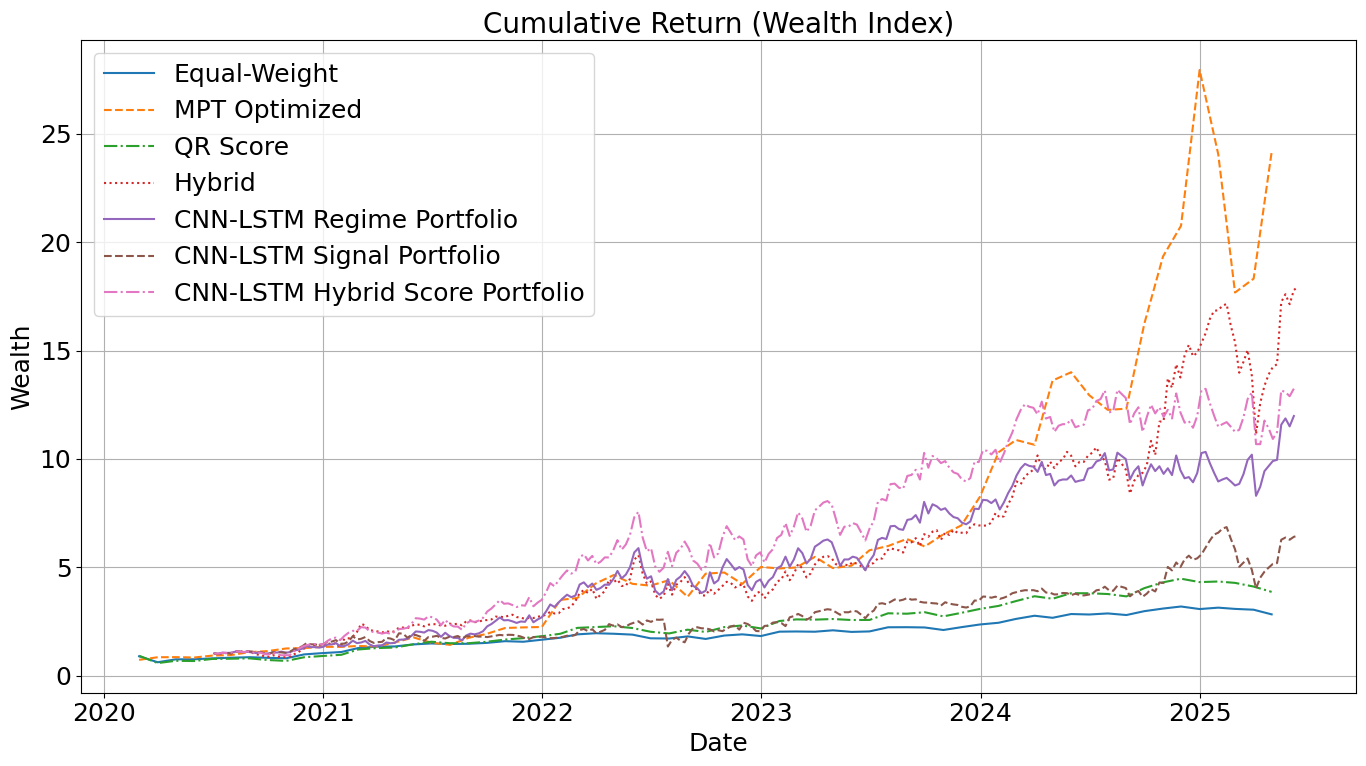

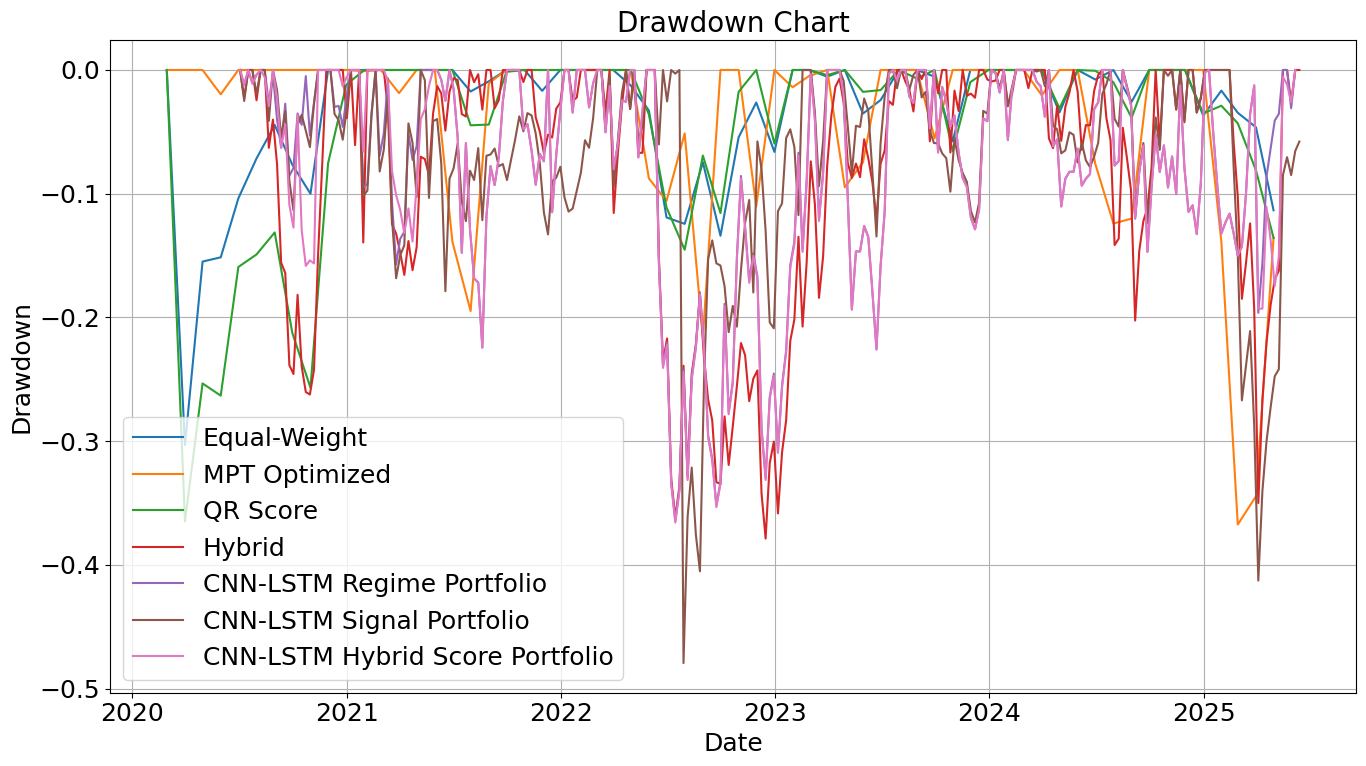

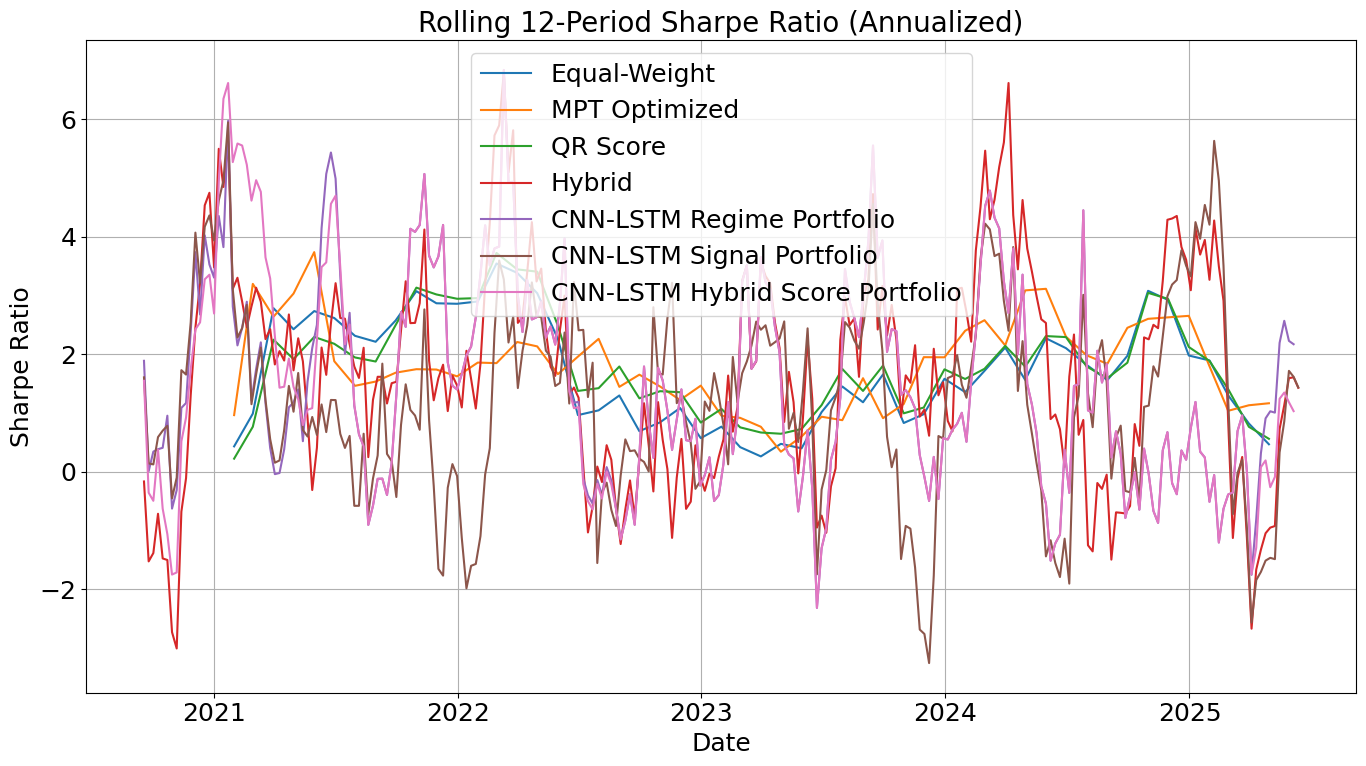

In [129]:
# Define known weekly strategies
monthly_strategies = {"Equal-Weight", "MPT Optimized", "QR Score"}

# Storage for plots
wealth_indices = {}
drawdowns = {}
rolling_sharpes = {}

# Rolling window (use 12 for both weekly and monthly)
rolling_window = 12  

# Loop through each strategy
for col in all_returns_df.columns:
    if not(col in ['Signal Only', 'Regime Only','CNN-LSTM Mean-Var Portfolio']):
        series = all_returns_df[col].dropna()
        if len(series) < rolling_window:
            continue

        # Determine annualization factor
        is_monthly = col in monthly_strategies
        ann_factor = np.sqrt(12) if is_monthly else np.sqrt(52)

        # Cumulative wealth
        wealth = (1 + series).cumprod()
        wealth_indices[col] = wealth

        # Drawdown
        peak = wealth.cummax()
        drawdown = (wealth / peak) - 1
        drawdowns[col] = drawdown

        # Rolling Sharpe Ratio (risk-free assumed ≈ 0)
        rolling_mean = series.rolling(window=rolling_window).mean()
        rolling_std = series.rolling(window=rolling_window).std()
        rolling_sharpe = (rolling_mean / rolling_std) * ann_factor
        rolling_sharpes[col] = rolling_sharpe

# Color-blind-friendly palette (no yellow)
cud_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf"
]
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':']

plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# === Plot Cumulative Return (Wealth Index) ===
plt.figure(figsize=(14, 8))
for i, (name, series) in enumerate(wealth_indices.items()):
    plt.plot(series.index, series, label=name, color=cud_colors[i % len(cud_colors)],
             linestyle=line_styles[i % len(line_styles)])
plt.title('Cumulative Return (Wealth Index)', fontsize=20)
plt.ylabel('Wealth')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot Drawdowns ===
plt.figure(figsize=(14, 8))
for i, (name, dd) in enumerate(drawdowns.items()):
    plt.plot(dd.index, dd, label=name, color=cud_colors[i % len(cud_colors)])
plt.title('Drawdown Chart', fontsize=20)
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot Rolling Sharpe Ratios ===
plt.figure(figsize=(14, 8))
for i, (name, sharpe) in enumerate(rolling_sharpes.items()):
    plt.plot(sharpe.index, sharpe, label=name, color=cud_colors[i % len(cud_colors)])
plt.title(f'Rolling {rolling_window}-Period Sharpe Ratio (Annualized)', fontsize=20)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## CAGR vs Risk

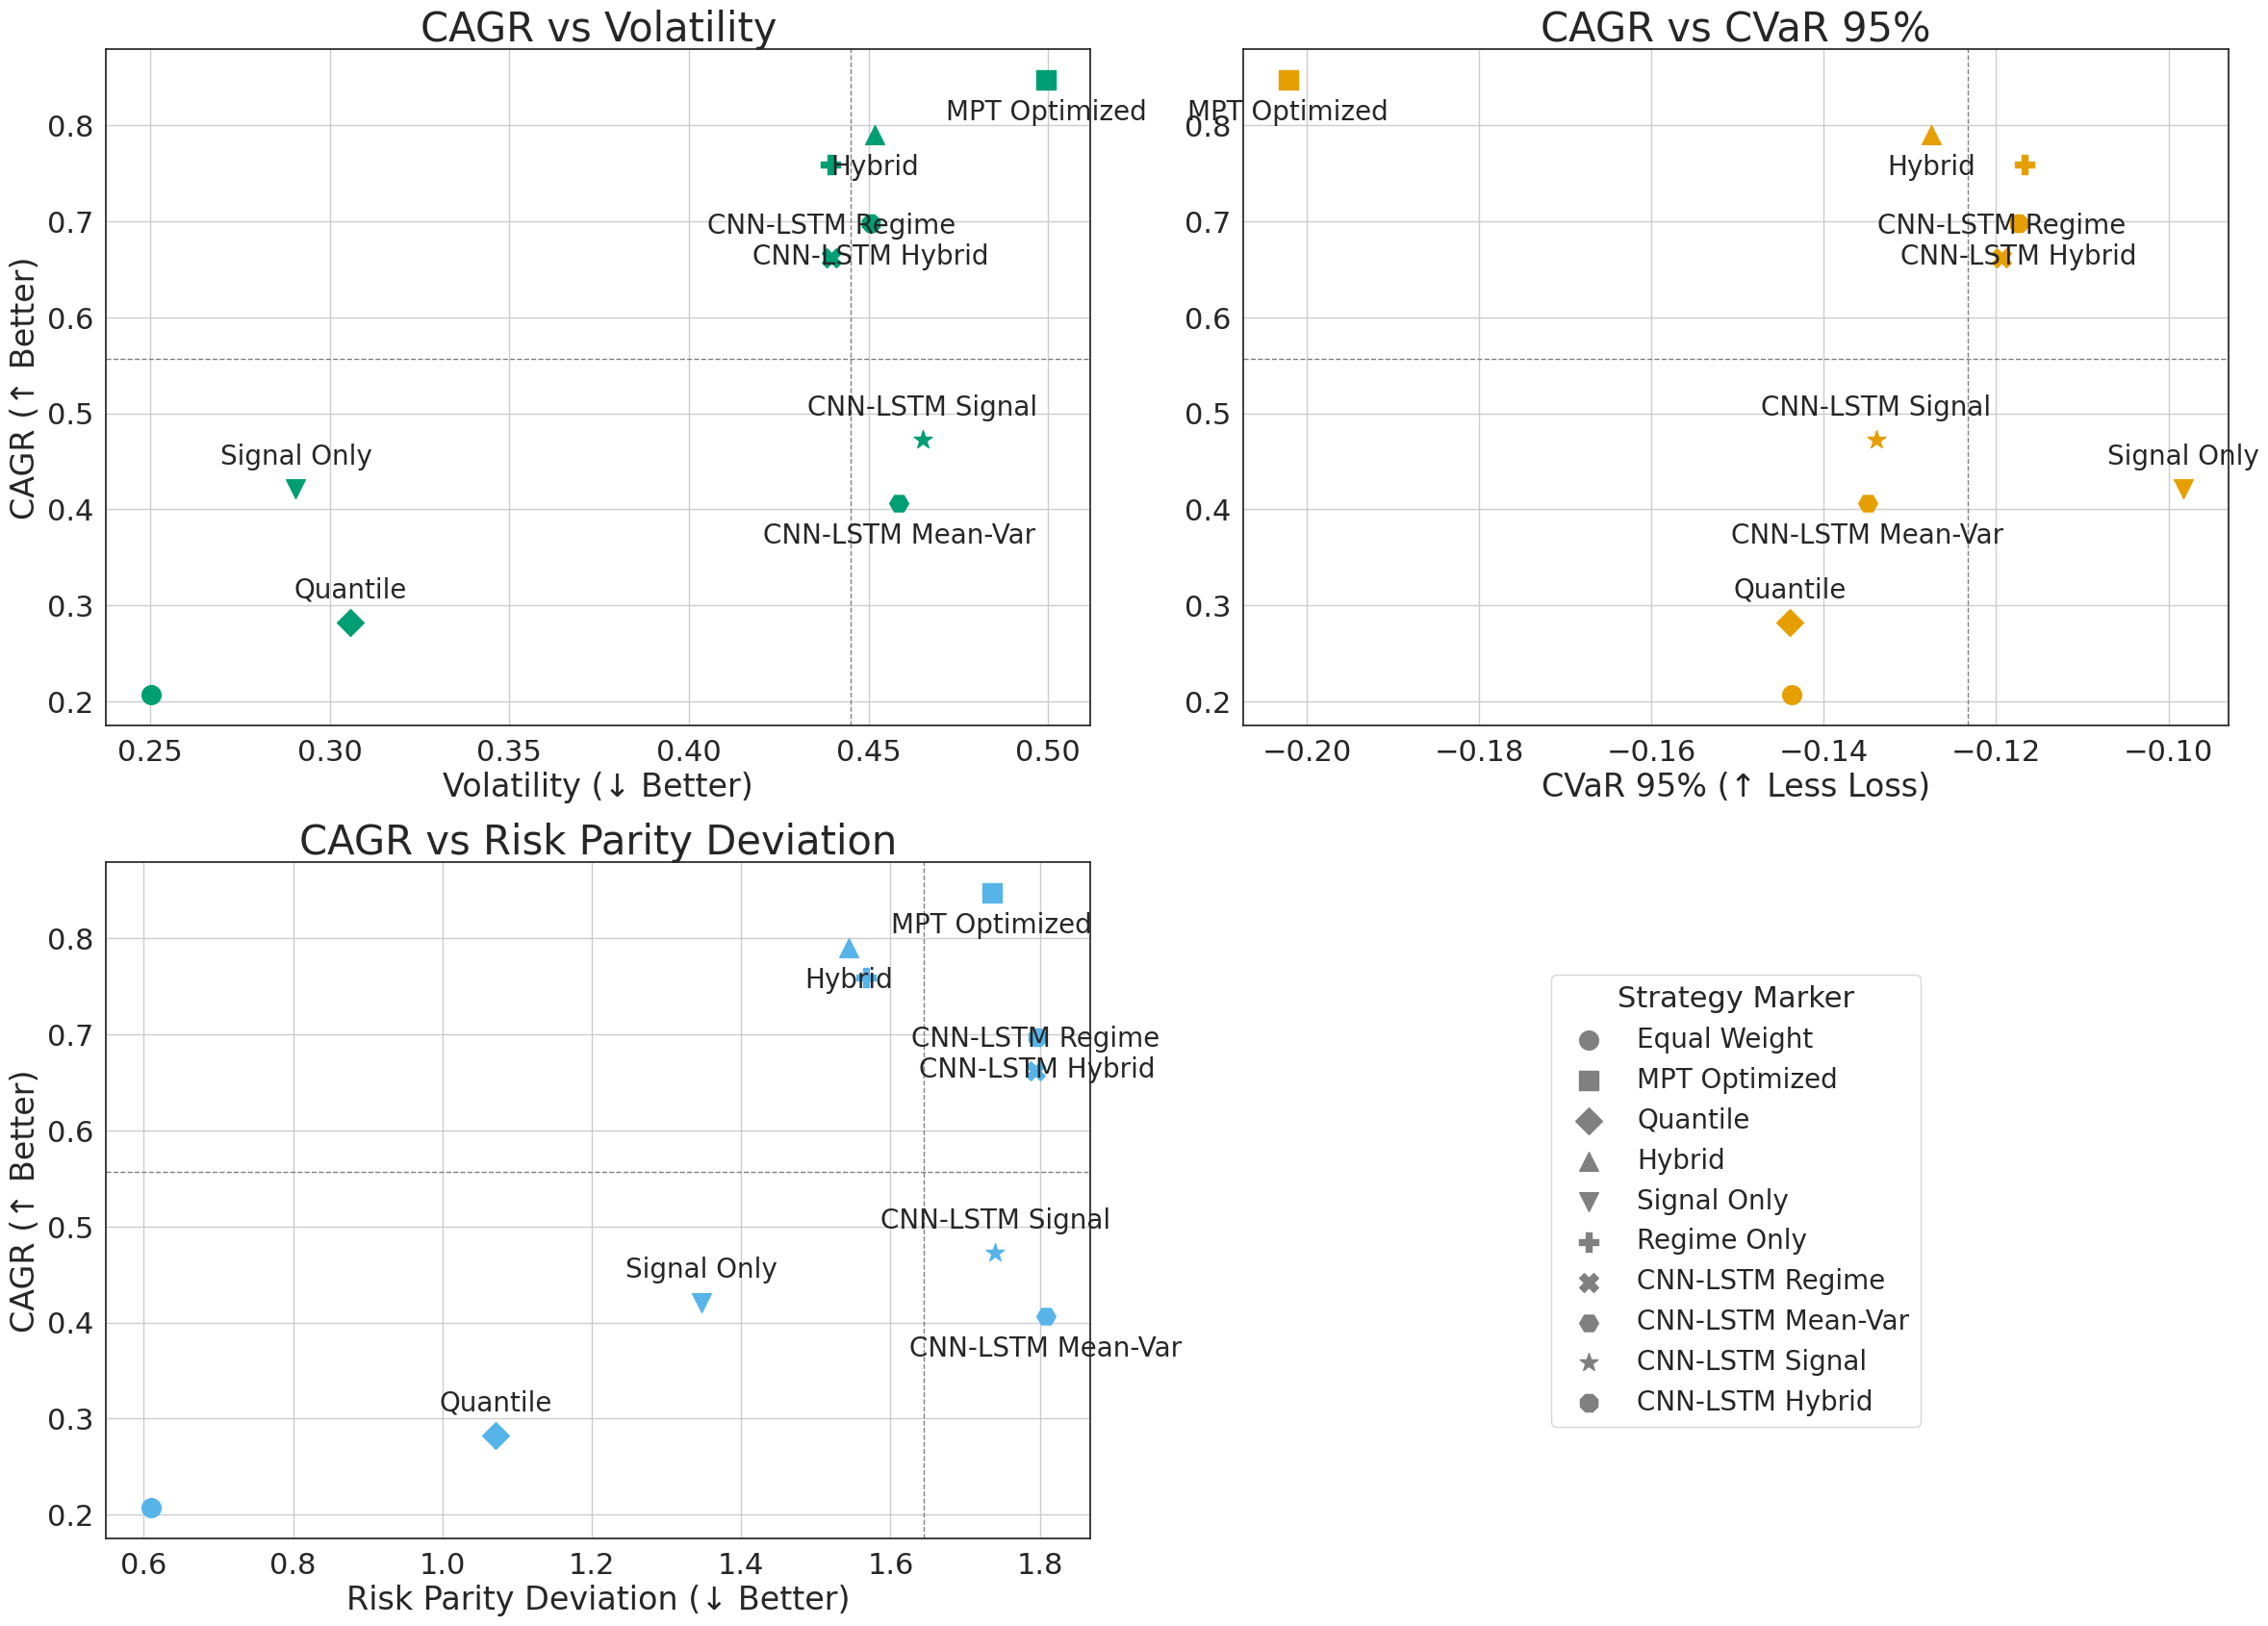

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Strategy Performance Summary
data = {
    "Strategy": [
        "Equal Weight", "MPT Optimized", "Quantile",
        "Hybrid", "Signal Only", "Regime Only",
        "CNN-LSTM Regime", "CNN-LSTM Mean-Var",
        "CNN-LSTM Signal", "CNN-LSTM Hybrid"
    ],
    "CAGR": [0.2234, 0.8522, 0.2995, 0.7949, 0.4020, 0.7568,
             0.6556, 0.4216, 0.4584, 0.6896],
    "Volatility": [0.2527, 0.4989, 0.3051, 0.4494, 0.2918, 0.4411,
                   0.4389, 0.4611, 0.4679, 0.4491],
    "RPD": [0.60, 1.73, 1.08, 1.55, 1.35, 1.56, 1.80, 1.80, 1.73, 1.79],
    "CVaR 95%": [-0.1409, -0.2102, -0.1524, -0.1211, -0.0895, -0.1191,
                 -0.1200, -0.1255, -0.1335, -0.1194]
}
df = pd.DataFrame(data)

# Get medians
cagr_median = df["CAGR"].median()
vol_median = df["Volatility"].median()
cvar_median = df["CVaR 95%"].median()
rpd_median = df["RPD"].median()

# Marker styles for each strategy
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', 'H', '*', '8']

# Jitter function
def jitter(values, amount=0.005):
    return values + np.random.uniform(-amount, amount, size=len(values))

# Apply jitter
vol_jitter = jitter(df["Volatility"], amount=0.005)
cvar_jitter = jitter(df["CVaR 95%"], amount=0.010)
rpd_jitter = jitter(df["RPD"], amount=0.015)
cagr_jitter = jitter(df["CAGR"], amount=0.020)

# Create 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(24, 18))
title_fontsize = 30
label_fontsize = 24
tick_fontsize = 22
annot_fontsize = 20
scatter_size = 200

# Highlighted strategies
highlight_strategies = {
    "MPT Optimized", "Hybrid", "CNN-LSTM Hybrid",
    "CNN-LSTM Regime", "CNN-LSTM Mean-Var", "CNN-LSTM Signal",
    "Signal Only", "Quantile"
}

# === 1. CAGR vs Volatility ===
axs[0, 0].axhline(cagr_median, color='gray', linestyle='--', lw=1)
axs[0, 0].axvline(vol_median, color='gray', linestyle='--', lw=1)
for i, strat in enumerate(df["Strategy"]):
    axs[0, 0].scatter(vol_jitter[i], cagr_jitter[i], s=scatter_size, color="#009E73", marker=markers[i])
    if strat in highlight_strategies:
        offset = 0.02 if i % 2 == 0 else -0.02
        va = 'bottom' if i % 2 == 0 else 'top'
        axs[0, 0].annotate(strat, (vol_jitter[i], cagr_jitter[i] + offset),
                           fontsize=annot_fontsize, ha='center', va=va)
axs[0, 0].set_title("CAGR vs Volatility", fontsize=title_fontsize)
axs[0, 0].set_xlabel("Volatility (↓ Better)", fontsize=label_fontsize)
axs[0, 0].set_ylabel("CAGR (↑ Better)", fontsize=label_fontsize)
axs[0, 0].tick_params(labelsize=tick_fontsize)
axs[0, 0].grid(True)

# === 2. CAGR vs CVaR 95% ===
axs[0, 1].axhline(cagr_median, color='gray', linestyle='--', lw=1)
axs[0, 1].axvline(cvar_median, color='gray', linestyle='--', lw=1)
for i, strat in enumerate(df["Strategy"]):
    axs[0, 1].scatter(cvar_jitter[i], cagr_jitter[i], s=scatter_size, color="#E69F00", marker=markers[i])
    if strat in highlight_strategies:
        offset = 0.02 if i % 2 == 0 else -0.02
        va = 'bottom' if i % 2 == 0 else 'top'
        axs[0, 1].annotate(strat, (cvar_jitter[i], cagr_jitter[i] + offset),
                           fontsize=annot_fontsize, ha='center', va=va)
axs[0, 1].set_title("CAGR vs CVaR 95%", fontsize=title_fontsize)
axs[0, 1].set_xlabel("CVaR 95% (↑ Less Loss)", fontsize=label_fontsize)
axs[0, 1].tick_params(labelsize=tick_fontsize)
axs[0, 1].grid(True)

# === 3. CAGR vs RPD ===
axs[1, 0].axhline(cagr_median, color='gray', linestyle='--', lw=1)
axs[1, 0].axvline(rpd_median, color='gray', linestyle='--', lw=1)
for i, strat in enumerate(df["Strategy"]):
    axs[1, 0].scatter(rpd_jitter[i], cagr_jitter[i], s=scatter_size, color="#56B4E9", marker=markers[i])
    if strat in highlight_strategies:
        offset = 0.02 if i % 2 == 0 else -0.02
        va = 'bottom' if i % 2 == 0 else 'top'
        axs[1, 0].annotate(strat, (rpd_jitter[i], cagr_jitter[i] + offset),
                           fontsize=annot_fontsize, ha='center', va=va)
axs[1, 0].set_title("CAGR vs Risk Parity Deviation", fontsize=title_fontsize)
axs[1, 0].set_xlabel("Risk Parity Deviation (↓ Better)", fontsize=label_fontsize)
axs[1, 0].set_ylabel("CAGR (↑ Better)", fontsize=label_fontsize)
axs[1, 0].tick_params(labelsize=tick_fontsize)
axs[1, 0].grid(True)

# === 4. Marker Legend ===
axs[1, 1].axis('off')
for i, strat in enumerate(df["Strategy"]):
    axs[1, 1].scatter([], [], marker=markers[i], s=scatter_size, label=strat, color='gray')
axs[1, 1].legend(loc='center', fontsize=20, title="Strategy Marker", title_fontsize=22)

# Final layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## Paired t-test on monthly excess returns

In [212]:
import itertools
import pandas as pd
import numpy as np
from scipy import stats

# ========= 1) Helper: compound any frequency to MONTHLY simple returns =========
def to_monthly_compounded(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert simple returns at any frequency (daily/weekly/etc.) to MONTHLY simple returns
    by compounding within each calendar month. If already monthly, this is a no-op.
    Requires a DatetimeIndex.
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a pandas DatetimeIndex.")
    df = df.sort_index()
    monthly = (1.0 + df).groupby(pd.Grouper(freq="M")).prod() - 1.0
    return monthly

# ========= 2) Paired t-test on excess returns (not on Sharpe directly) =========
def paired_ttest_excess_returns(returns_a: pd.Series,
                                returns_b: pd.Series,
                                rf: float | pd.Series = 0.0):
    """
    Paired t-test on the mean of excess return differences: (r_a - rf) - (r_b - rf).
    - returns_a, returns_b: monthly simple returns (same frequency); will be pairwise-aligned.
    - rf: monthly risk-free rate per period; can be scalar or a Series aligned by index.
    Returns: sharpe_diff (for reference), t_stat, p_value, n_obs
    """
    pair = pd.concat({"A": returns_a, "B": returns_b}, axis=1).dropna(how="any")
    n = len(pair)
    if n < 3:  # need at least a few points to run a t-test
        return np.nan, np.nan, np.nan, n

    # Handle rf as scalar or Series
    if isinstance(rf, pd.Series):
        rf = rf.reindex(pair.index).fillna(method="ffill").fillna(method="bfill")
        excess_a = pair["A"] - rf
        excess_b = pair["B"] - rf
    else:
        excess_a = pair["A"] - rf
        excess_b = pair["B"] - rf

    # Sharpe ratios (for reporting only; significance is based on mean difference t-test)
    sr_a = excess_a.mean() / excess_a.std(ddof=1)
    sr_b = excess_b.mean() / excess_b.std(ddof=1)
    sharpe_diff = sr_a - sr_b

    # Paired t-test on excess returns
    t_stat, p_val = stats.ttest_rel(excess_a, excess_b)

    return sharpe_diff, t_stat, p_val, n

# ====================== 3) MAIN: harmonize + pairwise tests ======================
# Input:
# all_returns_df: wide DataFrame of simple returns with a DatetimeIndex (mixed frequencies allowed).
# Columns should be your strategy names (Table 4).

# A) Convert to MONTHLY compounded returns
all_returns_monthly = to_monthly_compounded(all_returns_df)

# Optional: monthly risk-free (as scalar or Series). If available as a Series, align by index.
# Example as scalar (0.0 per month):
monthly_rf = 0.0

# If you have a Series, it should be a DatetimeIndex with monthly frequency (or resampleable):
# monthly_rf_series = ...  # e.g., a pandas Series of monthly risk-free rates
# monthly_rf = monthly_rf_series

strategy_names = all_returns_monthly.columns.tolist()

# Prepare outputs
ttest_results = []
pval_matrix = pd.DataFrame(np.nan, index=strategy_names, columns=strategy_names)

for strat_a, strat_b in itertools.combinations(strategy_names, 2):
    sharpe_diff, t_stat, p_val, n_obs = paired_ttest_excess_returns(
        all_returns_monthly[strat_a],
        all_returns_monthly[strat_b],
        rf=monthly_rf
    )

    # Fill symmetric p-value matrix
    pval_matrix.loc[strat_a, strat_b] = p_val
    pval_matrix.loc[strat_b, strat_a] = p_val

    ttest_results.append({
        "Strategy A": strat_a,
        "Strategy B": strat_b,
        "Sharpe Diff (reporting only)": sharpe_diff,
        "t-stat (mean excess return diff)": t_stat,
        "p-value": p_val,
        "Significant (95%)": (p_val < 0.05) if pd.notna(p_val) else np.nan,
        "N overlapping months": n_obs
    })

ttest_df = pd.DataFrame(ttest_results).sort_values("p-value")

# ====================== 4) Outputs ======================
print("P-value matrix (paired t-test on monthly excess returns):")
# pval_matrix

# print("\nDetailed paired t-test results:")
ttest_df

/tmp/ipykernel_1102796/2037112973.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = (1.0 + df).groupby(pd.Grouper(freq="M")).prod() - 1.0


P-value matrix (paired t-test on monthly excess returns):


Strategy A                       Strategy B  \
2                  Equal-Weight                           Hybrid   
4                  Equal-Weight                      Regime Only   
8                  Equal-Weight  CNN-LSTM Hybrid Score Portfolio   
17                     QR Score                           Hybrid   
5                  Equal-Weight        CNN-LSTM Regime Portfolio   
0                  Equal-Weight                    MPT Optimized   
24                       Hybrid                      Signal Only   
19                     QR Score                      Regime Only   
30                  Signal Only                      Regime Only   
1                  Equal-Weight                         QR Score   
23                     QR Score  CNN-LSTM Hybrid Score Portfolio   
9                 MPT Optimized                         QR Score   
11                MPT Optimized                      Signal Only   
34                  Signal Only  CNN-LSTM Hybrid Score Portfolio   
20                     QR Score        CNN-LSTM Regime Portfolio   
31                  Signal Only        CNN-LSTM Regime Portfolio   
27                       Hybrid      CNN-LSTM Mean-Var Portfolio   
36                  Regime Only      CNN-LSTM Mean-Var Portfolio   
7                  Equal-Weight        CNN-LSTM Signal Portfolio   
6                  Equal-Weight      CNN-LSTM Mean-Var Portfolio   
15                MPT Optimized        CNN-LSTM Signal Portfolio   
14                MPT Optimized      CNN-LSTM Mean-Var Portfolio   
3                  Equal-Weight                      Signal Only   
28                       Hybrid        CNN-LSTM Signal Portfolio   
37                  Regime Only        CNN-LSTM Signal Portfolio   
43  CNN-LSTM Mean-Var Portfolio  CNN-LSTM Hybrid Score Portfolio   
13                MPT Optimized        CNN-LSTM Regime Portfolio   
22                     QR Score        CNN-LSTM Signal Portfolio   
21                     QR Score      CNN-LSTM Mean-Var Portfolio   
39    CNN-LSTM Regime Portfolio      CNN-LSTM Mean-Var Portfolio   
26                       Hybrid        CNN-LSTM Regime Portfolio   
16                MPT Optimized  CNN-LSTM Hybrid Score Portfolio   
33                  Signal Only        CNN-LSTM Signal Portfolio   
44    CNN-LSTM Signal Portfolio  CNN-LSTM Hybrid Score Portfolio   
32                  Signal Only      CNN-LSTM Mean-Var Portfolio   
41    CNN-LSTM Regime Portfolio  CNN-LSTM Hybrid Score Portfolio   
35                  Regime Only        CNN-LSTM Regime Portfolio   
29                       Hybrid  CNN-LSTM Hybrid Score Portfolio   
40    CNN-LSTM Regime Portfolio        CNN-LSTM Signal Portfolio   
12                MPT Optimized                      Regime Only   
10                MPT Optimized                           Hybrid   
25                       Hybrid                      Regime Only   
38                  Regime Only  CNN-LSTM Hybrid Score Portfolio   
18                     QR Score                      Signal Only   
42  CNN-LSTM Mean-Var Portfolio        CNN-LSTM Signal Portfolio   

    Sharpe Diff (reporting only)  t-stat (mean excess return diff)   p-value  \
2                      -0.177374                         -2.635068  0.010540   
4                      -0.157973                         -2.419173  0.018409   
8                      -0.151957                         -2.312789  0.023961   
17                     -0.151496                         -2.195425  0.031766   
5                      -0.176967                         -2.065557  0.042925   
0                      -0.156287                         -1.998534  0.049911   
24                      0.003131                          1.975606  0.052515   
19                     -0.132095                         -1.961013  0.054232   
30                      0.016269                         -1.893835  0.062768   
1                      -0.025878                         -1.761580  0.082916   
23          

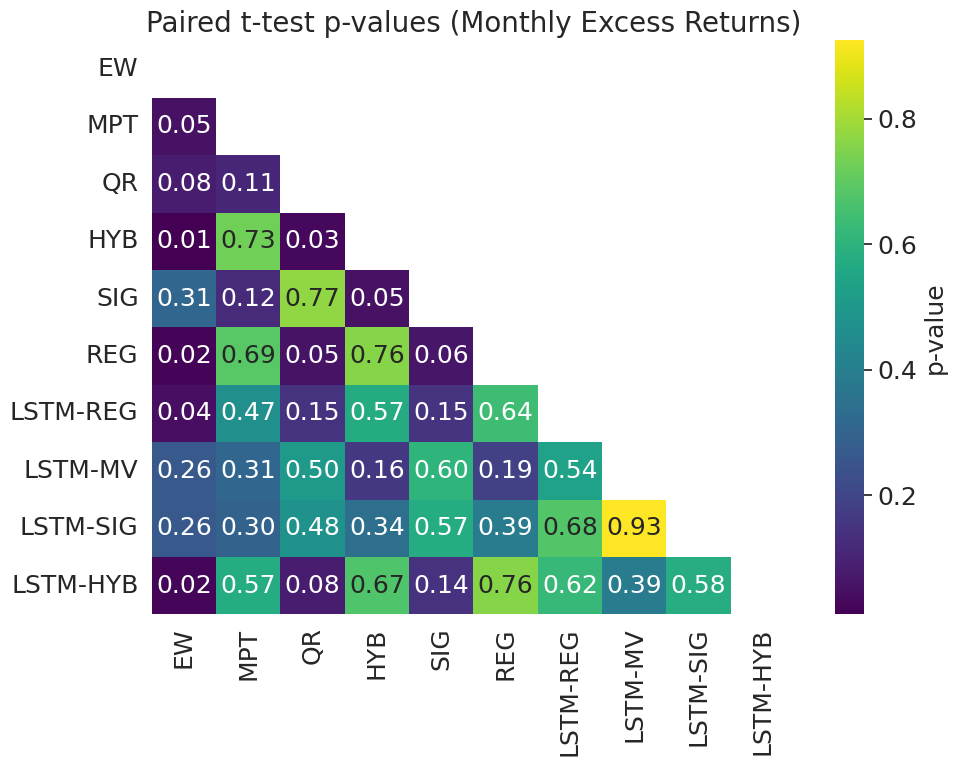

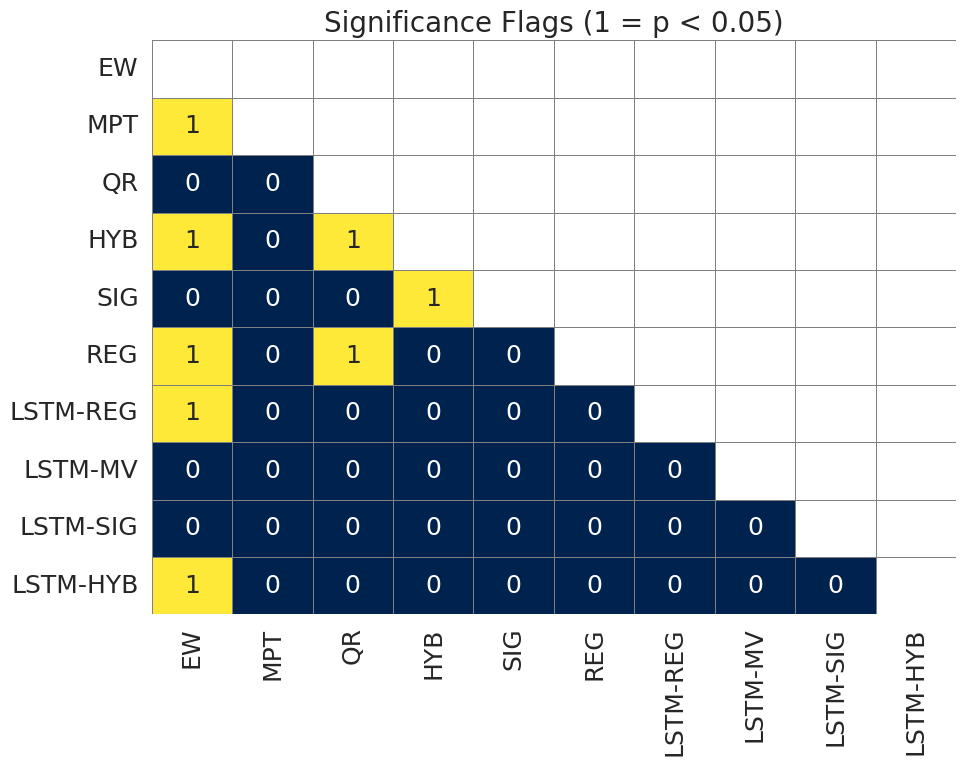

In [216]:
# Mapping from long names to short codes
name_map = {
    "Equal-Weight": "EW",
    "MPT Optimized": "MPT",
    "QR Score": "QR",
    "Hybrid": "HYB",
    "Signal Only": "SIG",
    "Regime Only": "REG",
    "CNN-LSTM Regime Portfolio": "LSTM-REG",
    "CNN-LSTM Mean-Var Portfolio": "LSTM-MV",
    "CNN-LSTM Signal Portfolio": "LSTM-SIG",
    "CNN-LSTM Hybrid Score Portfolio": "LSTM-HYB"
}

# Apply renaming for both index and columns
pval_matrix_short = pval_matrix.rename(index=name_map, columns=name_map)

# Create significance matrix (1 = significant, 0 = not)
significance_matrix_short = (pval_matrix_short < 0.06).astype(int)

# Option 1: Show raw p-values
plt.figure(figsize=(10, 8))
sns.heatmap(pval_matrix_short.astype(float),
            mask=mask,
            annot=True, fmt=".2f",
            cmap="viridis",
            cbar_kws={'label': 'p-value'})
plt.title("Paired t-test p-values (Monthly Excess Returns)")
plt.tight_layout()
plt.show()

# === Mask upper triangle for cleaner plot ===
mask = np.triu(np.ones_like(significance_matrix_short, dtype=bool))

# Option 2: Show significance flags (1=Significant, 0=Not Significant)
plt.figure(figsize=(10, 8))
sns.heatmap(significance_matrix_short,
            mask=mask,
            annot=True, fmt="d",
            cmap="cividis",
            cbar_kws={'label': 'p-value'},
            linewidths=0.5,
            linecolor='grey',
            cbar=False)
plt.title("Significance Flags (1 = p < 0.05)")
plt.tight_layout()
plt.show()
